# Mountain Car with Policy Gradient

<img src="mountaincar.gif" alt="environment">

In [1]:
import numpy as np
from rlglue import *
import time
from plot_utils import *
from sklearn.neighbors import KNeighborsRegressor
from dl_utils import *

***
<a name='2'></a>

In [2]:
class MountainCar(Environment):
    
    def env_init(self, env_info={}):
        reward = None
        observation = None
        is_terminal = None
        self.reward_obs_term = (reward, observation, is_terminal)

        self.rand_generator = np.random.RandomState(env_info.get("seed"))
        
        self.left_bound = -1.2
        self.right_bound = 0.5
        self.actions = ['FULL THROTTLE REVERSE', 'ZERO THROTTLE', 'FULL THROTTLE FORWARD']
        
    def env_start(self):
        reward = 0.
        
        position = np.random.uniform(-0.6, -0.4)
        velocity = 0.
        self.current_state = (position, velocity)
        state = self.current_state
        
        is_terminal = False
        
        self.reward_obs_term = [reward, state, is_terminal]
        return self.reward_obs_term[1]
    
    def env_step(self, action):
        position, velocity = self.current_state
        
        velocity = self.env_bound_velocity(velocity + 0.001*(action-1) - 0.0025*np.cos(3*position))
        position = self.env_bound_position(position + velocity)
        
        reward = -1
        is_terminal = False
        
        if position == self.left_bound:
            velocity = 0.
        elif position == self.right_bound:    
            reward = 0.
            is_terminal = True
        
        self.current_state = (position, velocity)
        
        self.reward_obs_term = [reward, self.current_state, is_terminal]

        return self.reward_obs_term

    def env_cleanup(self):
        self.current_state = None
        
    def env_bound_velocity(self, velocity):
        if velocity > 0.07:
            return 0.07
        if velocity < -0.07:
            return -0.07
        return velocity

    def env_bound_position(self, position):
        if position > 0.5:
            return 0.5
        if position < -1.2:
            return -1.2
        return position

***
<a name='3'></a>

In [3]:
class MonteCarloEvaluation(Agent):
    
    def agent_init(self, agent_info={}):
        self.rand_generator = np.random.RandomState(agent_info.get('seed'))
        
        self.discount = agent_info.get("discount")
        self.policy = agent_info.get("policy")

        self.v = VFunction()
        self.episodes = []

    def agent_start(self, state):
        self.episode_data = []
        
        self.episodes.append([])
        self.episodes[-1].append(state)

        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_step(self, reward, state):
        self.episode_data.append((self.last_state, self.last_action, reward))
        
        self.episodes[-1].append(state)

        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action

        return action

    def agent_end(self, reward):
        self.episode_data.append((self.last_state, self.last_action, reward))
        
        X_train = []
        Y_train = []
        
        target = 0
        for i in range(len(self.episode_data)-1, -1, -1):
            s, a, r = self.episode_data[i]
            X_train.append([s[0], s[1]])
            target = r + self.discount*target
            Y_train.append([target])   
            
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        
        self.v.fit(X_train, Y_train, epochs=100)
        
    def agent_cleanup(self):
        self.last_state = None

    def agent_action(self, state):
        position, velocity = state
        p = self.policy.predict(np.array([[position, velocity]]))
        return self.rand_generator.choice(range(p.shape[1]), p=p.flatten())

***
<a name='4'></a>

In [4]:
class PolicyEvaluation(RLGlue):
    
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        history = []
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode)
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {}'.format(episode+1, num_episodes, self.num_steps))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))
                history.append(self.num_steps)
        self.rl_cleanup()
        return self.agent.v, np.array(history)

***
<a name='5'></a>

In [5]:
class TestPolicy():
    
    def predict(self, inputs):
        return np.repeat(np.array([[1/3, 1/3, 1/3]]), inputs.shape[0], 0)

In [6]:
test_policy = TestPolicy() 

In [7]:
plot_animation(test_policy, 'test_policy.gif')

***
<a name='6'></a>

In [8]:
env_info = {}

mountain_car = MountainCar()

In [9]:
agent_info = {"discount": 1.,
              "policy": test_policy}

montecarlo_evaluation = MonteCarloEvaluation()

In [10]:
num_episodes = 5000
max_steps_this_episode = 10000 

policy_evaluation = PolicyEvaluation(env=mountain_car, 
                                     agent=montecarlo_evaluation)

value_function, history = policy_evaluation.rl_run(env_info=env_info,
                                                   agent_info=agent_info,
                                                   num_episodes=num_episodes,
                                                   max_steps_this_episode=max_steps_this_episode)

Episode: 1/5000 - Steps: 10000
----- 1.515s -----
Episode: 2/5000 - Steps: 10000
----- 1.498s -----
Episode: 3/5000 - Steps: 10000
----- 1.55s -----
Episode: 4/5000 - Steps: 10000
----- 1.479s -----
Episode: 5/5000 - Steps: 10000
----- 1.482s -----
Episode: 6/5000 - Steps: 10000
----- 1.507s -----
Episode: 7/5000 - Steps: 10000
----- 1.565s -----
Episode: 8/5000 - Steps: 10000
----- 1.504s -----
Episode: 9/5000 - Steps: 10000
----- 1.589s -----
Episode: 10/5000 - Steps: 10000
----- 1.667s -----
Episode: 11/5000 - Steps: 10000
----- 1.498s -----
Episode: 12/5000 - Steps: 10000
----- 1.687s -----
Episode: 13/5000 - Steps: 10000
----- 1.544s -----
Episode: 14/5000 - Steps: 3437
----- 0.791s -----
Episode: 15/5000 - Steps: 10000
----- 1.496s -----
Episode: 16/5000 - Steps: 10000
----- 1.556s -----
Episode: 17/5000 - Steps: 10000
----- 1.571s -----
Episode: 18/5000 - Steps: 10000
----- 1.578s -----
Episode: 19/5000 - Steps: 10000
----- 1.675s -----
Episode: 20/5000 - Steps: 2724
----- 0.767

Episode: 162/5000 - Steps: 10000
----- 1.531s -----
Episode: 163/5000 - Steps: 10000
----- 1.574s -----
Episode: 164/5000 - Steps: 10000
----- 1.577s -----
Episode: 165/5000 - Steps: 10000
----- 1.599s -----
Episode: 166/5000 - Steps: 3208
----- 0.784s -----
Episode: 167/5000 - Steps: 10000
----- 1.479s -----
Episode: 168/5000 - Steps: 2338
----- 0.741s -----
Episode: 169/5000 - Steps: 3945
----- 0.948s -----
Episode: 170/5000 - Steps: 10000
----- 1.711s -----
Episode: 171/5000 - Steps: 10000
----- 1.518s -----
Episode: 172/5000 - Steps: 10000
----- 1.521s -----
Episode: 173/5000 - Steps: 10000
----- 1.576s -----
Episode: 174/5000 - Steps: 10000
----- 1.529s -----
Episode: 175/5000 - Steps: 10000
----- 1.508s -----
Episode: 176/5000 - Steps: 10000
----- 1.488s -----
Episode: 177/5000 - Steps: 10000
----- 1.615s -----
Episode: 178/5000 - Steps: 2265
----- 0.776s -----
Episode: 179/5000 - Steps: 10000
----- 1.496s -----
Episode: 180/5000 - Steps: 10000
----- 1.445s -----
Episode: 181/500

Episode: 321/5000 - Steps: 10000
----- 1.464s -----
Episode: 322/5000 - Steps: 5454
----- 1.002s -----
Episode: 323/5000 - Steps: 10000
----- 1.469s -----
Episode: 324/5000 - Steps: 2314
----- 0.787s -----
Episode: 325/5000 - Steps: 10000
----- 1.452s -----
Episode: 326/5000 - Steps: 10000
----- 1.45s -----
Episode: 327/5000 - Steps: 10000
----- 1.425s -----
Episode: 328/5000 - Steps: 10000
----- 1.426s -----
Episode: 329/5000 - Steps: 10000
----- 1.46s -----
Episode: 330/5000 - Steps: 10000
----- 1.435s -----
Episode: 331/5000 - Steps: 3037
----- 0.788s -----
Episode: 332/5000 - Steps: 10000
----- 1.546s -----
Episode: 333/5000 - Steps: 10000
----- 1.516s -----
Episode: 334/5000 - Steps: 10000
----- 1.555s -----
Episode: 335/5000 - Steps: 3644
----- 0.847s -----
Episode: 336/5000 - Steps: 10000
----- 1.462s -----
Episode: 337/5000 - Steps: 10000
----- 1.455s -----
Episode: 338/5000 - Steps: 10000
----- 1.484s -----
Episode: 339/5000 - Steps: 10000
----- 1.544s -----
Episode: 340/5000 

Episode: 480/5000 - Steps: 10000
----- 1.444s -----
Episode: 481/5000 - Steps: 10000
----- 1.488s -----
Episode: 482/5000 - Steps: 10000
----- 1.414s -----
Episode: 483/5000 - Steps: 10000
----- 1.401s -----
Episode: 484/5000 - Steps: 10000
----- 1.42s -----
Episode: 485/5000 - Steps: 10000
----- 1.494s -----
Episode: 486/5000 - Steps: 10000
----- 1.412s -----
Episode: 487/5000 - Steps: 3885
----- 0.826s -----
Episode: 488/5000 - Steps: 10000
----- 1.443s -----
Episode: 489/5000 - Steps: 10000
----- 1.409s -----
Episode: 490/5000 - Steps: 10000
----- 1.404s -----
Episode: 491/5000 - Steps: 10000
----- 1.401s -----
Episode: 492/5000 - Steps: 10000
----- 1.413s -----
Episode: 493/5000 - Steps: 10000
----- 1.588s -----
Episode: 494/5000 - Steps: 4388
----- 0.962s -----
Episode: 495/5000 - Steps: 10000
----- 1.455s -----
Episode: 496/5000 - Steps: 8776
----- 1.352s -----
Episode: 497/5000 - Steps: 10000
----- 1.403s -----
Episode: 498/5000 - Steps: 10000
----- 1.405s -----
Episode: 499/500

Episode: 639/5000 - Steps: 10000
----- 1.415s -----
Episode: 640/5000 - Steps: 10000
----- 1.532s -----
Episode: 641/5000 - Steps: 3291
----- 0.808s -----
Episode: 642/5000 - Steps: 10000
----- 1.394s -----
Episode: 643/5000 - Steps: 10000
----- 1.394s -----
Episode: 644/5000 - Steps: 5552
----- 0.986s -----
Episode: 645/5000 - Steps: 10000
----- 1.436s -----
Episode: 646/5000 - Steps: 10000
----- 1.409s -----
Episode: 647/5000 - Steps: 10000
----- 1.407s -----
Episode: 648/5000 - Steps: 5999
----- 1.139s -----
Episode: 649/5000 - Steps: 10000
----- 1.396s -----
Episode: 650/5000 - Steps: 10000
----- 1.394s -----
Episode: 651/5000 - Steps: 10000
----- 1.425s -----
Episode: 652/5000 - Steps: 10000
----- 1.406s -----
Episode: 653/5000 - Steps: 10000
----- 1.431s -----
Episode: 654/5000 - Steps: 5158
----- 1.028s -----
Episode: 655/5000 - Steps: 10000
----- 1.405s -----
Episode: 656/5000 - Steps: 10000
----- 1.565s -----
Episode: 657/5000 - Steps: 10000
----- 1.412s -----
Episode: 658/500

Episode: 798/5000 - Steps: 10000
----- 1.4s -----
Episode: 799/5000 - Steps: 9044
----- 1.295s -----
Episode: 800/5000 - Steps: 10000
----- 1.408s -----
Episode: 801/5000 - Steps: 10000
----- 1.499s -----
Episode: 802/5000 - Steps: 8758
----- 1.322s -----
Episode: 803/5000 - Steps: 5953
----- 1.02s -----
Episode: 804/5000 - Steps: 10000
----- 1.421s -----
Episode: 805/5000 - Steps: 4889
----- 0.976s -----
Episode: 806/5000 - Steps: 10000
----- 1.521s -----
Episode: 807/5000 - Steps: 10000
----- 1.398s -----
Episode: 808/5000 - Steps: 10000
----- 1.402s -----
Episode: 809/5000 - Steps: 10000
----- 1.433s -----
Episode: 810/5000 - Steps: 10000
----- 1.395s -----
Episode: 811/5000 - Steps: 10000
----- 1.403s -----
Episode: 812/5000 - Steps: 10000
----- 1.387s -----
Episode: 813/5000 - Steps: 10000
----- 1.516s -----
Episode: 814/5000 - Steps: 10000
----- 1.393s -----
Episode: 815/5000 - Steps: 10000
----- 1.395s -----
Episode: 816/5000 - Steps: 10000
----- 1.43s -----
Episode: 817/5000 - 

Episode: 957/5000 - Steps: 10000
----- 1.417s -----
Episode: 958/5000 - Steps: 10000
----- 1.409s -----
Episode: 959/5000 - Steps: 4528
----- 0.89s -----
Episode: 960/5000 - Steps: 10000
----- 1.45s -----
Episode: 961/5000 - Steps: 10000
----- 1.449s -----
Episode: 962/5000 - Steps: 10000
----- 1.475s -----
Episode: 963/5000 - Steps: 10000
----- 1.463s -----
Episode: 964/5000 - Steps: 10000
----- 1.557s -----
Episode: 965/5000 - Steps: 7727
----- 1.234s -----
Episode: 966/5000 - Steps: 10000
----- 1.397s -----
Episode: 967/5000 - Steps: 10000
----- 1.394s -----
Episode: 968/5000 - Steps: 10000
----- 1.403s -----
Episode: 969/5000 - Steps: 10000
----- 1.402s -----
Episode: 970/5000 - Steps: 10000
----- 1.408s -----
Episode: 971/5000 - Steps: 10000
----- 1.574s -----
Episode: 972/5000 - Steps: 7811
----- 1.205s -----
Episode: 973/5000 - Steps: 10000
----- 1.404s -----
Episode: 974/5000 - Steps: 7353
----- 1.158s -----
Episode: 975/5000 - Steps: 10000
----- 1.398s -----
Episode: 976/5000 

Episode: 1114/5000 - Steps: 10000
----- 1.446s -----
Episode: 1115/5000 - Steps: 10000
----- 1.401s -----
Episode: 1116/5000 - Steps: 10000
----- 1.556s -----
Episode: 1117/5000 - Steps: 1302
----- 0.558s -----
Episode: 1118/5000 - Steps: 10000
----- 1.417s -----
Episode: 1119/5000 - Steps: 10000
----- 1.423s -----
Episode: 1120/5000 - Steps: 10000
----- 1.416s -----
Episode: 1121/5000 - Steps: 5666
----- 1.023s -----
Episode: 1122/5000 - Steps: 10000
----- 1.404s -----
Episode: 1123/5000 - Steps: 10000
----- 1.402s -----
Episode: 1124/5000 - Steps: 3911
----- 0.824s -----
Episode: 1125/5000 - Steps: 10000
----- 1.413s -----
Episode: 1126/5000 - Steps: 10000
----- 1.606s -----
Episode: 1127/5000 - Steps: 10000
----- 1.487s -----
Episode: 1128/5000 - Steps: 10000
----- 1.497s -----
Episode: 1129/5000 - Steps: 4349
----- 0.927s -----
Episode: 1130/5000 - Steps: 10000
----- 1.423s -----
Episode: 1131/5000 - Steps: 10000
----- 1.426s -----
Episode: 1132/5000 - Steps: 10000
----- 1.407s ---

Episode: 1270/5000 - Steps: 10000
----- 1.434s -----
Episode: 1271/5000 - Steps: 1640
----- 0.6s -----
Episode: 1272/5000 - Steps: 5933
----- 1.008s -----
Episode: 1273/5000 - Steps: 10000
----- 1.448s -----
Episode: 1274/5000 - Steps: 10000
----- 1.42s -----
Episode: 1275/5000 - Steps: 10000
----- 1.451s -----
Episode: 1276/5000 - Steps: 10000
----- 1.576s -----
Episode: 1277/5000 - Steps: 10000
----- 1.42s -----
Episode: 1278/5000 - Steps: 10000
----- 1.419s -----
Episode: 1279/5000 - Steps: 10000
----- 1.378s -----
Episode: 1280/5000 - Steps: 10000
----- 1.405s -----
Episode: 1281/5000 - Steps: 4648
----- 0.913s -----
Episode: 1282/5000 - Steps: 4962
----- 0.941s -----
Episode: 1283/5000 - Steps: 10000
----- 1.399s -----
Episode: 1284/5000 - Steps: 9753
----- 1.355s -----
Episode: 1285/5000 - Steps: 10000
----- 1.591s -----
Episode: 1286/5000 - Steps: 1705
----- 0.619s -----
Episode: 1287/5000 - Steps: 10000
----- 1.409s -----
Episode: 1288/5000 - Steps: 10000
----- 1.439s -----
Epi

Episode: 1426/5000 - Steps: 10000
----- 1.408s -----
Episode: 1427/5000 - Steps: 10000
----- 1.606s -----
Episode: 1428/5000 - Steps: 10000
----- 1.413s -----
Episode: 1429/5000 - Steps: 10000
----- 1.413s -----
Episode: 1430/5000 - Steps: 2252
----- 0.67s -----
Episode: 1431/5000 - Steps: 10000
----- 1.417s -----
Episode: 1432/5000 - Steps: 10000
----- 1.457s -----
Episode: 1433/5000 - Steps: 10000
----- 1.408s -----
Episode: 1434/5000 - Steps: 10000
----- 1.446s -----
Episode: 1435/5000 - Steps: 10000
----- 1.601s -----
Episode: 1436/5000 - Steps: 10000
----- 1.469s -----
Episode: 1437/5000 - Steps: 10000
----- 1.437s -----
Episode: 1438/5000 - Steps: 10000
----- 1.418s -----
Episode: 1439/5000 - Steps: 7046
----- 1.136s -----
Episode: 1440/5000 - Steps: 10000
----- 1.394s -----
Episode: 1441/5000 - Steps: 10000
----- 1.422s -----
Episode: 1442/5000 - Steps: 10000
----- 1.584s -----
Episode: 1443/5000 - Steps: 10000
----- 1.406s -----
Episode: 1444/5000 - Steps: 10000
----- 1.419s --

Episode: 1582/5000 - Steps: 10000
----- 1.446s -----
Episode: 1583/5000 - Steps: 10000
----- 1.473s -----
Episode: 1584/5000 - Steps: 2485
----- 0.7s -----
Episode: 1585/5000 - Steps: 10000
----- 1.406s -----
Episode: 1586/5000 - Steps: 10000
----- 1.425s -----
Episode: 1587/5000 - Steps: 10000
----- 1.397s -----
Episode: 1588/5000 - Steps: 10000
----- 1.4s -----
Episode: 1589/5000 - Steps: 10000
----- 1.599s -----
Episode: 1590/5000 - Steps: 6056
----- 1.039s -----
Episode: 1591/5000 - Steps: 10000
----- 1.419s -----
Episode: 1592/5000 - Steps: 7397
----- 1.164s -----
Episode: 1593/5000 - Steps: 10000
----- 1.423s -----
Episode: 1594/5000 - Steps: 10000
----- 1.422s -----
Episode: 1595/5000 - Steps: 5333
----- 1.007s -----
Episode: 1596/5000 - Steps: 10000
----- 1.452s -----
Episode: 1597/5000 - Steps: 10000
----- 1.472s -----
Episode: 1598/5000 - Steps: 10000
----- 1.649s -----
Episode: 1599/5000 - Steps: 10000
----- 1.412s -----
Episode: 1600/5000 - Steps: 3876
----- 0.833s -----
Ep

Episode: 1738/5000 - Steps: 10000
----- 1.4s -----
Episode: 1739/5000 - Steps: 10000
----- 1.596s -----
Episode: 1740/5000 - Steps: 10000
----- 1.4s -----
Episode: 1741/5000 - Steps: 10000
----- 1.39s -----
Episode: 1742/5000 - Steps: 10000
----- 1.45s -----
Episode: 1743/5000 - Steps: 10000
----- 1.474s -----
Episode: 1744/5000 - Steps: 10000
----- 1.469s -----
Episode: 1745/5000 - Steps: 7030
----- 1.187s -----
Episode: 1746/5000 - Steps: 8047
----- 1.224s -----
Episode: 1747/5000 - Steps: 10000
----- 1.591s -----
Episode: 1748/5000 - Steps: 10000
----- 1.39s -----
Episode: 1749/5000 - Steps: 10000
----- 1.426s -----
Episode: 1750/5000 - Steps: 4456
----- 0.891s -----
Episode: 1751/5000 - Steps: 10000
----- 1.408s -----
Episode: 1752/5000 - Steps: 10000
----- 1.403s -----
Episode: 1753/5000 - Steps: 1967
----- 0.634s -----
Episode: 1754/5000 - Steps: 10000
----- 1.392s -----
Episode: 1755/5000 - Steps: 10000
----- 1.396s -----
Episode: 1756/5000 - Steps: 6983
----- 1.125s -----
Episo

Episode: 1894/5000 - Steps: 2735
----- 0.716s -----
Episode: 1895/5000 - Steps: 10000
----- 1.649s -----
Episode: 1896/5000 - Steps: 6452
----- 1.088s -----
Episode: 1897/5000 - Steps: 10000
----- 1.456s -----
Episode: 1898/5000 - Steps: 10000
----- 1.414s -----
Episode: 1899/5000 - Steps: 10000
----- 1.46s -----
Episode: 1900/5000 - Steps: 10000
----- 1.451s -----
Episode: 1901/5000 - Steps: 10000
----- 1.4s -----
Episode: 1902/5000 - Steps: 10000
----- 1.399s -----
Episode: 1903/5000 - Steps: 10000
----- 1.398s -----
Episode: 1904/5000 - Steps: 10000
----- 1.608s -----
Episode: 1905/5000 - Steps: 10000
----- 1.391s -----
Episode: 1906/5000 - Steps: 10000
----- 1.404s -----
Episode: 1907/5000 - Steps: 2484
----- 0.693s -----
Episode: 1908/5000 - Steps: 10000
----- 1.395s -----
Episode: 1909/5000 - Steps: 10000
----- 1.397s -----
Episode: 1910/5000 - Steps: 8637
----- 1.311s -----
Episode: 1911/5000 - Steps: 4294
----- 0.876s -----
Episode: 1912/5000 - Steps: 10000
----- 1.439s -----
E

Episode: 2050/5000 - Steps: 10000
----- 1.439s -----
Episode: 2051/5000 - Steps: 10000
----- 1.429s -----
Episode: 2052/5000 - Steps: 10000
----- 1.403s -----
Episode: 2053/5000 - Steps: 10000
----- 1.402s -----
Episode: 2054/5000 - Steps: 10000
----- 1.402s -----
Episode: 2055/5000 - Steps: 6578
----- 1.322s -----
Episode: 2056/5000 - Steps: 3921
----- 0.828s -----
Episode: 2057/5000 - Steps: 10000
----- 1.391s -----
Episode: 2058/5000 - Steps: 10000
----- 1.412s -----
Episode: 2059/5000 - Steps: 10000
----- 1.391s -----
Episode: 2060/5000 - Steps: 6921
----- 1.121s -----
Episode: 2061/5000 - Steps: 3684
----- 0.81s -----
Episode: 2062/5000 - Steps: 10000
----- 1.405s -----
Episode: 2063/5000 - Steps: 6567
----- 1.13s -----
Episode: 2064/5000 - Steps: 10000
----- 1.669s -----
Episode: 2065/5000 - Steps: 10000
----- 1.408s -----
Episode: 2066/5000 - Steps: 6947
----- 1.146s -----
Episode: 2067/5000 - Steps: 10000
----- 1.397s -----
Episode: 2068/5000 - Steps: 10000
----- 1.408s -----
E

Episode: 2206/5000 - Steps: 10000
----- 1.438s -----
Episode: 2207/5000 - Steps: 8504
----- 1.303s -----
Episode: 2208/5000 - Steps: 3330
----- 0.775s -----
Episode: 2209/5000 - Steps: 10000
----- 1.402s -----
Episode: 2210/5000 - Steps: 10000
----- 1.413s -----
Episode: 2211/5000 - Steps: 10000
----- 1.676s -----
Episode: 2212/5000 - Steps: 10000
----- 1.404s -----
Episode: 2213/5000 - Steps: 10000
----- 1.4s -----
Episode: 2214/5000 - Steps: 10000
----- 1.355s -----
Episode: 2215/5000 - Steps: 6433
----- 1.074s -----
Episode: 2216/5000 - Steps: 10000
----- 1.499s -----
Episode: 2217/5000 - Steps: 10000
----- 1.475s -----
Episode: 2218/5000 - Steps: 10000
----- 1.417s -----
Episode: 2219/5000 - Steps: 10000
----- 1.713s -----
Episode: 2220/5000 - Steps: 10000
----- 1.488s -----
Episode: 2221/5000 - Steps: 10000
----- 1.405s -----
Episode: 2222/5000 - Steps: 10000
----- 1.39s -----
Episode: 2223/5000 - Steps: 10000
----- 1.399s -----
Episode: 2224/5000 - Steps: 10000
----- 1.408s -----

Episode: 2362/5000 - Steps: 10000
----- 1.403s -----
Episode: 2363/5000 - Steps: 10000
----- 1.401s -----
Episode: 2364/5000 - Steps: 10000
----- 1.476s -----
Episode: 2365/5000 - Steps: 3089
----- 0.776s -----
Episode: 2366/5000 - Steps: 3940
----- 0.833s -----
Episode: 2367/5000 - Steps: 10000
----- 1.4s -----
Episode: 2368/5000 - Steps: 10000
----- 1.662s -----
Episode: 2369/5000 - Steps: 6932
----- 1.128s -----
Episode: 2370/5000 - Steps: 10000
----- 1.433s -----
Episode: 2371/5000 - Steps: 10000
----- 1.422s -----
Episode: 2372/5000 - Steps: 10000
----- 1.412s -----
Episode: 2373/5000 - Steps: 10000
----- 1.394s -----
Episode: 2374/5000 - Steps: 10000
----- 1.392s -----
Episode: 2375/5000 - Steps: 6565
----- 1.101s -----
Episode: 2376/5000 - Steps: 10000
----- 1.646s -----
Episode: 2377/5000 - Steps: 9665
----- 1.375s -----
Episode: 2378/5000 - Steps: 3839
----- 0.829s -----
Episode: 2379/5000 - Steps: 10000
----- 1.402s -----
Episode: 2380/5000 - Steps: 9131
----- 1.326s -----
Ep

Episode: 2518/5000 - Steps: 10000
----- 1.46s -----
Episode: 2519/5000 - Steps: 10000
----- 1.44s -----
Episode: 2520/5000 - Steps: 10000
----- 1.409s -----
Episode: 2521/5000 - Steps: 10000
----- 1.391s -----
Episode: 2522/5000 - Steps: 10000
----- 1.651s -----
Episode: 2523/5000 - Steps: 10000
----- 1.415s -----
Episode: 2524/5000 - Steps: 10000
----- 1.4s -----
Episode: 2525/5000 - Steps: 10000
----- 1.43s -----
Episode: 2526/5000 - Steps: 10000
----- 1.41s -----
Episode: 2527/5000 - Steps: 10000
----- 1.405s -----
Episode: 2528/5000 - Steps: 10000
----- 1.401s -----
Episode: 2529/5000 - Steps: 10000
----- 1.651s -----
Episode: 2530/5000 - Steps: 10000
----- 1.439s -----
Episode: 2531/5000 - Steps: 10000
----- 1.441s -----
Episode: 2532/5000 - Steps: 10000
----- 1.451s -----
Episode: 2533/5000 - Steps: 10000
----- 1.414s -----
Episode: 2534/5000 - Steps: 10000
----- 1.444s -----
Episode: 2535/5000 - Steps: 5341
----- 0.971s -----
Episode: 2536/5000 - Steps: 10000
----- 1.393s -----


Episode: 2674/5000 - Steps: 2227
----- 0.67s -----
Episode: 2675/5000 - Steps: 10000
----- 1.477s -----
Episode: 2676/5000 - Steps: 10000
----- 1.386s -----
Episode: 2677/5000 - Steps: 10000
----- 1.425s -----
Episode: 2678/5000 - Steps: 10000
----- 1.46s -----
Episode: 2679/5000 - Steps: 9120
----- 1.34s -----
Episode: 2680/5000 - Steps: 10000
----- 1.72s -----
Episode: 2681/5000 - Steps: 10000
----- 1.388s -----
Episode: 2682/5000 - Steps: 10000
----- 1.399s -----
Episode: 2683/5000 - Steps: 10000
----- 1.406s -----
Episode: 2684/5000 - Steps: 10000
----- 1.395s -----
Episode: 2685/5000 - Steps: 10000
----- 1.407s -----
Episode: 2686/5000 - Steps: 10000
----- 1.704s -----
Episode: 2687/5000 - Steps: 10000
----- 1.402s -----
Episode: 2688/5000 - Steps: 10000
----- 1.393s -----
Episode: 2689/5000 - Steps: 10000
----- 1.396s -----
Episode: 2690/5000 - Steps: 10000
----- 1.393s -----
Episode: 2691/5000 - Steps: 6637
----- 1.119s -----
Episode: 2692/5000 - Steps: 10000
----- 1.446s -----


Episode: 2830/5000 - Steps: 1810
----- 0.632s -----
Episode: 2831/5000 - Steps: 10000
----- 1.425s -----
Episode: 2832/5000 - Steps: 10000
----- 1.409s -----
Episode: 2833/5000 - Steps: 1342
----- 0.563s -----
Episode: 2834/5000 - Steps: 10000
----- 1.407s -----
Episode: 2835/5000 - Steps: 4536
----- 0.904s -----
Episode: 2836/5000 - Steps: 10000
----- 1.418s -----
Episode: 2837/5000 - Steps: 10000
----- 1.392s -----
Episode: 2838/5000 - Steps: 6065
----- 1.033s -----
Episode: 2839/5000 - Steps: 10000
----- 1.682s -----
Episode: 2840/5000 - Steps: 10000
----- 1.407s -----
Episode: 2841/5000 - Steps: 10000
----- 1.44s -----
Episode: 2842/5000 - Steps: 10000
----- 1.478s -----
Episode: 2843/5000 - Steps: 3114
----- 0.762s -----
Episode: 2844/5000 - Steps: 3925
----- 0.872s -----
Episode: 2845/5000 - Steps: 10000
----- 1.44s -----
Episode: 2846/5000 - Steps: 10000
----- 1.417s -----
Episode: 2847/5000 - Steps: 10000
----- 1.723s -----
Episode: 2848/5000 - Steps: 10000
----- 1.407s -----
E

Episode: 2986/5000 - Steps: 10000
----- 1.742s -----
Episode: 2987/5000 - Steps: 10000
----- 1.414s -----
Episode: 2988/5000 - Steps: 10000
----- 1.406s -----
Episode: 2989/5000 - Steps: 10000
----- 1.397s -----
Episode: 2990/5000 - Steps: 10000
----- 1.405s -----
Episode: 2991/5000 - Steps: 10000
----- 1.393s -----
Episode: 2992/5000 - Steps: 1951
----- 0.627s -----
Episode: 2993/5000 - Steps: 10000
----- 1.434s -----
Episode: 2994/5000 - Steps: 10000
----- 1.703s -----
Episode: 2995/5000 - Steps: 3825
----- 0.829s -----
Episode: 2996/5000 - Steps: 10000
----- 1.432s -----
Episode: 2997/5000 - Steps: 10000
----- 1.446s -----
Episode: 2998/5000 - Steps: 10000
----- 1.443s -----
Episode: 2999/5000 - Steps: 10000
----- 1.457s -----
Episode: 3000/5000 - Steps: 10000
----- 1.453s -----
Episode: 3001/5000 - Steps: 10000
----- 1.711s -----
Episode: 3002/5000 - Steps: 10000
----- 1.409s -----
Episode: 3003/5000 - Steps: 8543
----- 1.293s -----
Episode: 3004/5000 - Steps: 4288
----- 0.861s ---

Episode: 3142/5000 - Steps: 10000
----- 1.411s -----
Episode: 3143/5000 - Steps: 10000
----- 1.396s -----
Episode: 3144/5000 - Steps: 10000
----- 1.71s -----
Episode: 3145/5000 - Steps: 10000
----- 1.395s -----
Episode: 3146/5000 - Steps: 10000
----- 1.487s -----
Episode: 3147/5000 - Steps: 10000
----- 1.466s -----
Episode: 3148/5000 - Steps: 5558
----- 1.052s -----
Episode: 3149/5000 - Steps: 10000
----- 1.402s -----
Episode: 3150/5000 - Steps: 10000
----- 1.473s -----
Episode: 3151/5000 - Steps: 10000
----- 1.399s -----
Episode: 3152/5000 - Steps: 10000
----- 1.703s -----
Episode: 3153/5000 - Steps: 10000
----- 1.407s -----
Episode: 3154/5000 - Steps: 10000
----- 1.441s -----
Episode: 3155/5000 - Steps: 10000
----- 1.4s -----
Episode: 3156/5000 - Steps: 7420
----- 1.154s -----
Episode: 3157/5000 - Steps: 10000
----- 1.394s -----
Episode: 3158/5000 - Steps: 10000
----- 1.39s -----
Episode: 3159/5000 - Steps: 1896
----- 0.627s -----
Episode: 3160/5000 - Steps: 9464
----- 1.351s -----
E

Episode: 3298/5000 - Steps: 10000
----- 1.385s -----
Episode: 3299/5000 - Steps: 10000
----- 1.417s -----
Episode: 3300/5000 - Steps: 10000
----- 1.444s -----
Episode: 3301/5000 - Steps: 5647
----- 1.002s -----
Episode: 3302/5000 - Steps: 10000
----- 1.439s -----
Episode: 3303/5000 - Steps: 10000
----- 1.452s -----
Episode: 3304/5000 - Steps: 10000
----- 1.425s -----
Episode: 3305/5000 - Steps: 10000
----- 1.725s -----
Episode: 3306/5000 - Steps: 10000
----- 1.388s -----
Episode: 3307/5000 - Steps: 10000
----- 1.395s -----
Episode: 3308/5000 - Steps: 10000
----- 1.401s -----
Episode: 3309/5000 - Steps: 10000
----- 1.445s -----
Episode: 3310/5000 - Steps: 10000
----- 1.398s -----
Episode: 3311/5000 - Steps: 10000
----- 1.735s -----
Episode: 3312/5000 - Steps: 10000
----- 1.389s -----
Episode: 3313/5000 - Steps: 8911
----- 1.287s -----
Episode: 3314/5000 - Steps: 10000
----- 1.442s -----
Episode: 3315/5000 - Steps: 10000
----- 1.428s -----
Episode: 3316/5000 - Steps: 10000
----- 1.462s -

Episode: 3454/5000 - Steps: 10000
----- 1.401s -----
Episode: 3455/5000 - Steps: 10000
----- 1.757s -----
Episode: 3456/5000 - Steps: 10000
----- 1.405s -----
Episode: 3457/5000 - Steps: 10000
----- 1.476s -----
Episode: 3458/5000 - Steps: 10000
----- 1.377s -----
Episode: 3459/5000 - Steps: 4005
----- 0.835s -----
Episode: 3460/5000 - Steps: 10000
----- 1.399s -----
Episode: 3461/5000 - Steps: 10000
----- 1.44s -----
Episode: 3462/5000 - Steps: 10000
----- 1.408s -----
Episode: 3463/5000 - Steps: 8177
----- 1.247s -----
Episode: 3464/5000 - Steps: 10000
----- 1.836s -----
Episode: 3465/5000 - Steps: 10000
----- 1.398s -----
Episode: 3466/5000 - Steps: 10000
----- 1.469s -----
Episode: 3467/5000 - Steps: 10000
----- 1.442s -----
Episode: 3468/5000 - Steps: 3679
----- 0.86s -----
Episode: 3469/5000 - Steps: 7730
----- 1.205s -----
Episode: 3470/5000 - Steps: 10000
----- 1.405s -----
Episode: 3471/5000 - Steps: 10000
----- 1.405s -----
Episode: 3472/5000 - Steps: 6278
----- 1.391s -----


Episode: 3610/5000 - Steps: 8009
----- 1.236s -----
Episode: 3611/5000 - Steps: 10000
----- 1.433s -----
Episode: 3612/5000 - Steps: 3561
----- 0.799s -----
Episode: 3613/5000 - Steps: 10000
----- 1.459s -----
Episode: 3614/5000 - Steps: 10000
----- 1.423s -----
Episode: 3615/5000 - Steps: 10000
----- 1.401s -----
Episode: 3616/5000 - Steps: 10000
----- 1.399s -----
Episode: 3617/5000 - Steps: 10000
----- 1.821s -----
Episode: 3618/5000 - Steps: 10000
----- 1.439s -----
Episode: 3619/5000 - Steps: 10000
----- 1.413s -----
Episode: 3620/5000 - Steps: 10000
----- 1.443s -----
Episode: 3621/5000 - Steps: 10000
----- 1.468s -----
Episode: 3622/5000 - Steps: 10000
----- 1.433s -----
Episode: 3623/5000 - Steps: 5652
----- 1.046s -----
Episode: 3624/5000 - Steps: 10000
----- 1.452s -----
Episode: 3625/5000 - Steps: 10000
----- 1.785s -----
Episode: 3626/5000 - Steps: 3156
----- 0.78s -----
Episode: 3627/5000 - Steps: 5954
----- 1.023s -----
Episode: 3628/5000 - Steps: 10000
----- 1.422s -----

Episode: 3766/5000 - Steps: 9678
----- 1.394s -----
Episode: 3767/5000 - Steps: 10000
----- 1.422s -----
Episode: 3768/5000 - Steps: 10000
----- 1.856s -----
Episode: 3769/5000 - Steps: 10000
----- 1.412s -----
Episode: 3770/5000 - Steps: 10000
----- 1.395s -----
Episode: 3771/5000 - Steps: 10000
----- 1.419s -----
Episode: 3772/5000 - Steps: 10000
----- 1.398s -----
Episode: 3773/5000 - Steps: 10000
----- 1.406s -----
Episode: 3774/5000 - Steps: 10000
----- 1.415s -----
Episode: 3775/5000 - Steps: 10000
----- 1.88s -----
Episode: 3776/5000 - Steps: 10000
----- 1.41s -----
Episode: 3777/5000 - Steps: 10000
----- 1.407s -----
Episode: 3778/5000 - Steps: 10000
----- 1.401s -----
Episode: 3779/5000 - Steps: 10000
----- 1.451s -----
Episode: 3780/5000 - Steps: 10000
----- 1.429s -----
Episode: 3781/5000 - Steps: 7753
----- 1.276s -----
Episode: 3782/5000 - Steps: 10000
----- 1.902s -----
Episode: 3783/5000 - Steps: 10000
----- 1.453s -----
Episode: 3784/5000 - Steps: 10000
----- 1.409s ---

Episode: 3922/5000 - Steps: 10000
----- 1.42s -----
Episode: 3923/5000 - Steps: 10000
----- 1.406s -----
Episode: 3924/5000 - Steps: 10000
----- 1.413s -----
Episode: 3925/5000 - Steps: 10000
----- 1.414s -----
Episode: 3926/5000 - Steps: 10000
----- 1.412s -----
Episode: 3927/5000 - Steps: 10000
----- 1.804s -----
Episode: 3928/5000 - Steps: 10000
----- 1.461s -----
Episode: 3929/5000 - Steps: 10000
----- 1.445s -----
Episode: 3930/5000 - Steps: 10000
----- 1.407s -----
Episode: 3931/5000 - Steps: 10000
----- 1.413s -----
Episode: 3932/5000 - Steps: 10000
----- 1.443s -----
Episode: 3933/5000 - Steps: 8826
----- 1.327s -----
Episode: 3934/5000 - Steps: 2692
----- 0.763s -----
Episode: 3935/5000 - Steps: 10000
----- 1.992s -----
Episode: 3936/5000 - Steps: 10000
----- 1.423s -----
Episode: 3937/5000 - Steps: 10000
----- 1.403s -----
Episode: 3938/5000 - Steps: 10000
----- 1.419s -----
Episode: 3939/5000 - Steps: 4616
----- 0.913s -----
Episode: 3940/5000 - Steps: 10000
----- 1.412s ---

Episode: 4078/5000 - Steps: 10000
----- 1.421s -----
Episode: 4079/5000 - Steps: 10000
----- 1.413s -----
Episode: 4080/5000 - Steps: 10000
----- 2.396s -----
Episode: 4081/5000 - Steps: 10000
----- 1.564s -----
Episode: 4082/5000 - Steps: 10000
----- 1.437s -----
Episode: 4083/5000 - Steps: 10000
----- 1.423s -----
Episode: 4084/5000 - Steps: 8155
----- 1.256s -----
Episode: 4085/5000 - Steps: 10000
----- 1.416s -----
Episode: 4086/5000 - Steps: 10000
----- 1.421s -----
Episode: 4087/5000 - Steps: 10000
----- 2.03s -----
Episode: 4088/5000 - Steps: 10000
----- 1.424s -----
Episode: 4089/5000 - Steps: 10000
----- 1.433s -----
Episode: 4090/5000 - Steps: 10000
----- 1.442s -----
Episode: 4091/5000 - Steps: 10000
----- 1.465s -----
Episode: 4092/5000 - Steps: 10000
----- 1.416s -----
Episode: 4093/5000 - Steps: 10000
----- 1.415s -----
Episode: 4094/5000 - Steps: 10000
----- 1.86s -----
Episode: 4095/5000 - Steps: 10000
----- 1.426s -----
Episode: 4096/5000 - Steps: 986
----- 0.512s ----

Episode: 4234/5000 - Steps: 10000
----- 2.434s -----
Episode: 4235/5000 - Steps: 8698
----- 1.358s -----
Episode: 4236/5000 - Steps: 7973
----- 1.224s -----
Episode: 4237/5000 - Steps: 10000
----- 1.417s -----
Episode: 4238/5000 - Steps: 10000
----- 1.398s -----
Episode: 4239/5000 - Steps: 10000
----- 1.415s -----
Episode: 4240/5000 - Steps: 5091
----- 0.961s -----
Episode: 4241/5000 - Steps: 10000
----- 1.412s -----
Episode: 4242/5000 - Steps: 10000
----- 2.96s -----
Episode: 4243/5000 - Steps: 10000
----- 1.396s -----
Episode: 4244/5000 - Steps: 5051
----- 0.942s -----
Episode: 4245/5000 - Steps: 10000
----- 1.416s -----
Episode: 4246/5000 - Steps: 10000
----- 1.449s -----
Episode: 4247/5000 - Steps: 10000
----- 1.409s -----
Episode: 4248/5000 - Steps: 10000
----- 1.414s -----
Episode: 4249/5000 - Steps: 10000
----- 1.412s -----
Episode: 4250/5000 - Steps: 10000
----- 2.057s -----
Episode: 4251/5000 - Steps: 10000
----- 1.469s -----
Episode: 4252/5000 - Steps: 10000
----- 1.433s ----

Episode: 4390/5000 - Steps: 10000
----- 1.432s -----
Episode: 4391/5000 - Steps: 10000
----- 1.465s -----
Episode: 4392/5000 - Steps: 10000
----- 1.48s -----
Episode: 4393/5000 - Steps: 10000
----- 1.407s -----
Episode: 4394/5000 - Steps: 10000
----- 1.402s -----
Episode: 4395/5000 - Steps: 10000
----- 1.399s -----
Episode: 4396/5000 - Steps: 10000
----- 3.257s -----
Episode: 4397/5000 - Steps: 10000
----- 1.423s -----
Episode: 4398/5000 - Steps: 10000
----- 1.439s -----
Episode: 4399/5000 - Steps: 10000
----- 1.404s -----
Episode: 4400/5000 - Steps: 10000
----- 1.405s -----
Episode: 4401/5000 - Steps: 10000
----- 1.396s -----
Episode: 4402/5000 - Steps: 10000
----- 1.4s -----
Episode: 4403/5000 - Steps: 10000
----- 1.408s -----
Episode: 4404/5000 - Steps: 10000
----- 3.235s -----
Episode: 4405/5000 - Steps: 10000
----- 1.408s -----
Episode: 4406/5000 - Steps: 6610
----- 1.1s -----
Episode: 4407/5000 - Steps: 10000
----- 1.412s -----
Episode: 4408/5000 - Steps: 10000
----- 1.405s -----

Episode: 4546/5000 - Steps: 10000
----- 1.416s -----
Episode: 4547/5000 - Steps: 10000
----- 1.405s -----
Episode: 4548/5000 - Steps: 10000
----- 1.42s -----
Episode: 4549/5000 - Steps: 10000
----- 1.416s -----
Episode: 4550/5000 - Steps: 10000
----- 1.419s -----
Episode: 4551/5000 - Steps: 10000
----- 1.413s -----
Episode: 4552/5000 - Steps: 10000
----- 5.041s -----
Episode: 4553/5000 - Steps: 10000
----- 1.5s -----
Episode: 4554/5000 - Steps: 10000
----- 1.456s -----
Episode: 4555/5000 - Steps: 10000
----- 1.412s -----
Episode: 4556/5000 - Steps: 10000
----- 1.414s -----
Episode: 4557/5000 - Steps: 10000
----- 1.401s -----
Episode: 4558/5000 - Steps: 10000
----- 1.413s -----
Episode: 4559/5000 - Steps: 4297
----- 0.871s -----
Episode: 4560/5000 - Steps: 10000
----- 5.104s -----
Episode: 4561/5000 - Steps: 10000
----- 1.413s -----
Episode: 4562/5000 - Steps: 2439
----- 0.686s -----
Episode: 4563/5000 - Steps: 8876
----- 1.352s -----
Episode: 4564/5000 - Steps: 10000
----- 1.398s -----

Episode: 4702/5000 - Steps: 10000
----- 1.415s -----
Episode: 4703/5000 - Steps: 10000
----- 1.416s -----
Episode: 4704/5000 - Steps: 10000
----- 1.412s -----
Episode: 4705/5000 - Steps: 10000
----- 5.174s -----
Episode: 4706/5000 - Steps: 10000
----- 1.428s -----
Episode: 4707/5000 - Steps: 9763
----- 1.39s -----
Episode: 4708/5000 - Steps: 10000
----- 1.413s -----
Episode: 4709/5000 - Steps: 10000
----- 1.404s -----
Episode: 4710/5000 - Steps: 10000
----- 1.432s -----
Episode: 4711/5000 - Steps: 10000
----- 1.444s -----
Episode: 4712/5000 - Steps: 10000
----- 5.084s -----
Episode: 4713/5000 - Steps: 7209
----- 1.176s -----
Episode: 4714/5000 - Steps: 10000
----- 1.402s -----
Episode: 4715/5000 - Steps: 10000
----- 1.399s -----
Episode: 4716/5000 - Steps: 10000
----- 1.396s -----
Episode: 4717/5000 - Steps: 10000
----- 1.411s -----
Episode: 4718/5000 - Steps: 10000
----- 1.427s -----
Episode: 4719/5000 - Steps: 10000
----- 5.201s -----
Episode: 4720/5000 - Steps: 10000
----- 1.4s ----

Episode: 4858/5000 - Steps: 3916
----- 0.836s -----
Episode: 4859/5000 - Steps: 6207
----- 1.128s -----
Episode: 4860/5000 - Steps: 10000
----- 1.412s -----
Episode: 4861/5000 - Steps: 6092
----- 1.046s -----
Episode: 4862/5000 - Steps: 10000
----- 1.42s -----
Episode: 4863/5000 - Steps: 5742
----- 1.043s -----
Episode: 4864/5000 - Steps: 3962
----- 0.845s -----
Episode: 4865/5000 - Steps: 10000
----- 5.362s -----
Episode: 4866/5000 - Steps: 10000
----- 1.413s -----
Episode: 4867/5000 - Steps: 10000
----- 1.418s -----
Episode: 4868/5000 - Steps: 10000
----- 1.457s -----
Episode: 4869/5000 - Steps: 10000
----- 1.397s -----
Episode: 4870/5000 - Steps: 10000
----- 1.407s -----
Episode: 4871/5000 - Steps: 10000
----- 1.398s -----
Episode: 4872/5000 - Steps: 10000
----- 5.381s -----
Episode: 4873/5000 - Steps: 5893
----- 1.038s -----
Episode: 4874/5000 - Steps: 10000
----- 1.398s -----
Episode: 4875/5000 - Steps: 10000
----- 1.406s -----
Episode: 4876/5000 - Steps: 10000
----- 1.411s -----


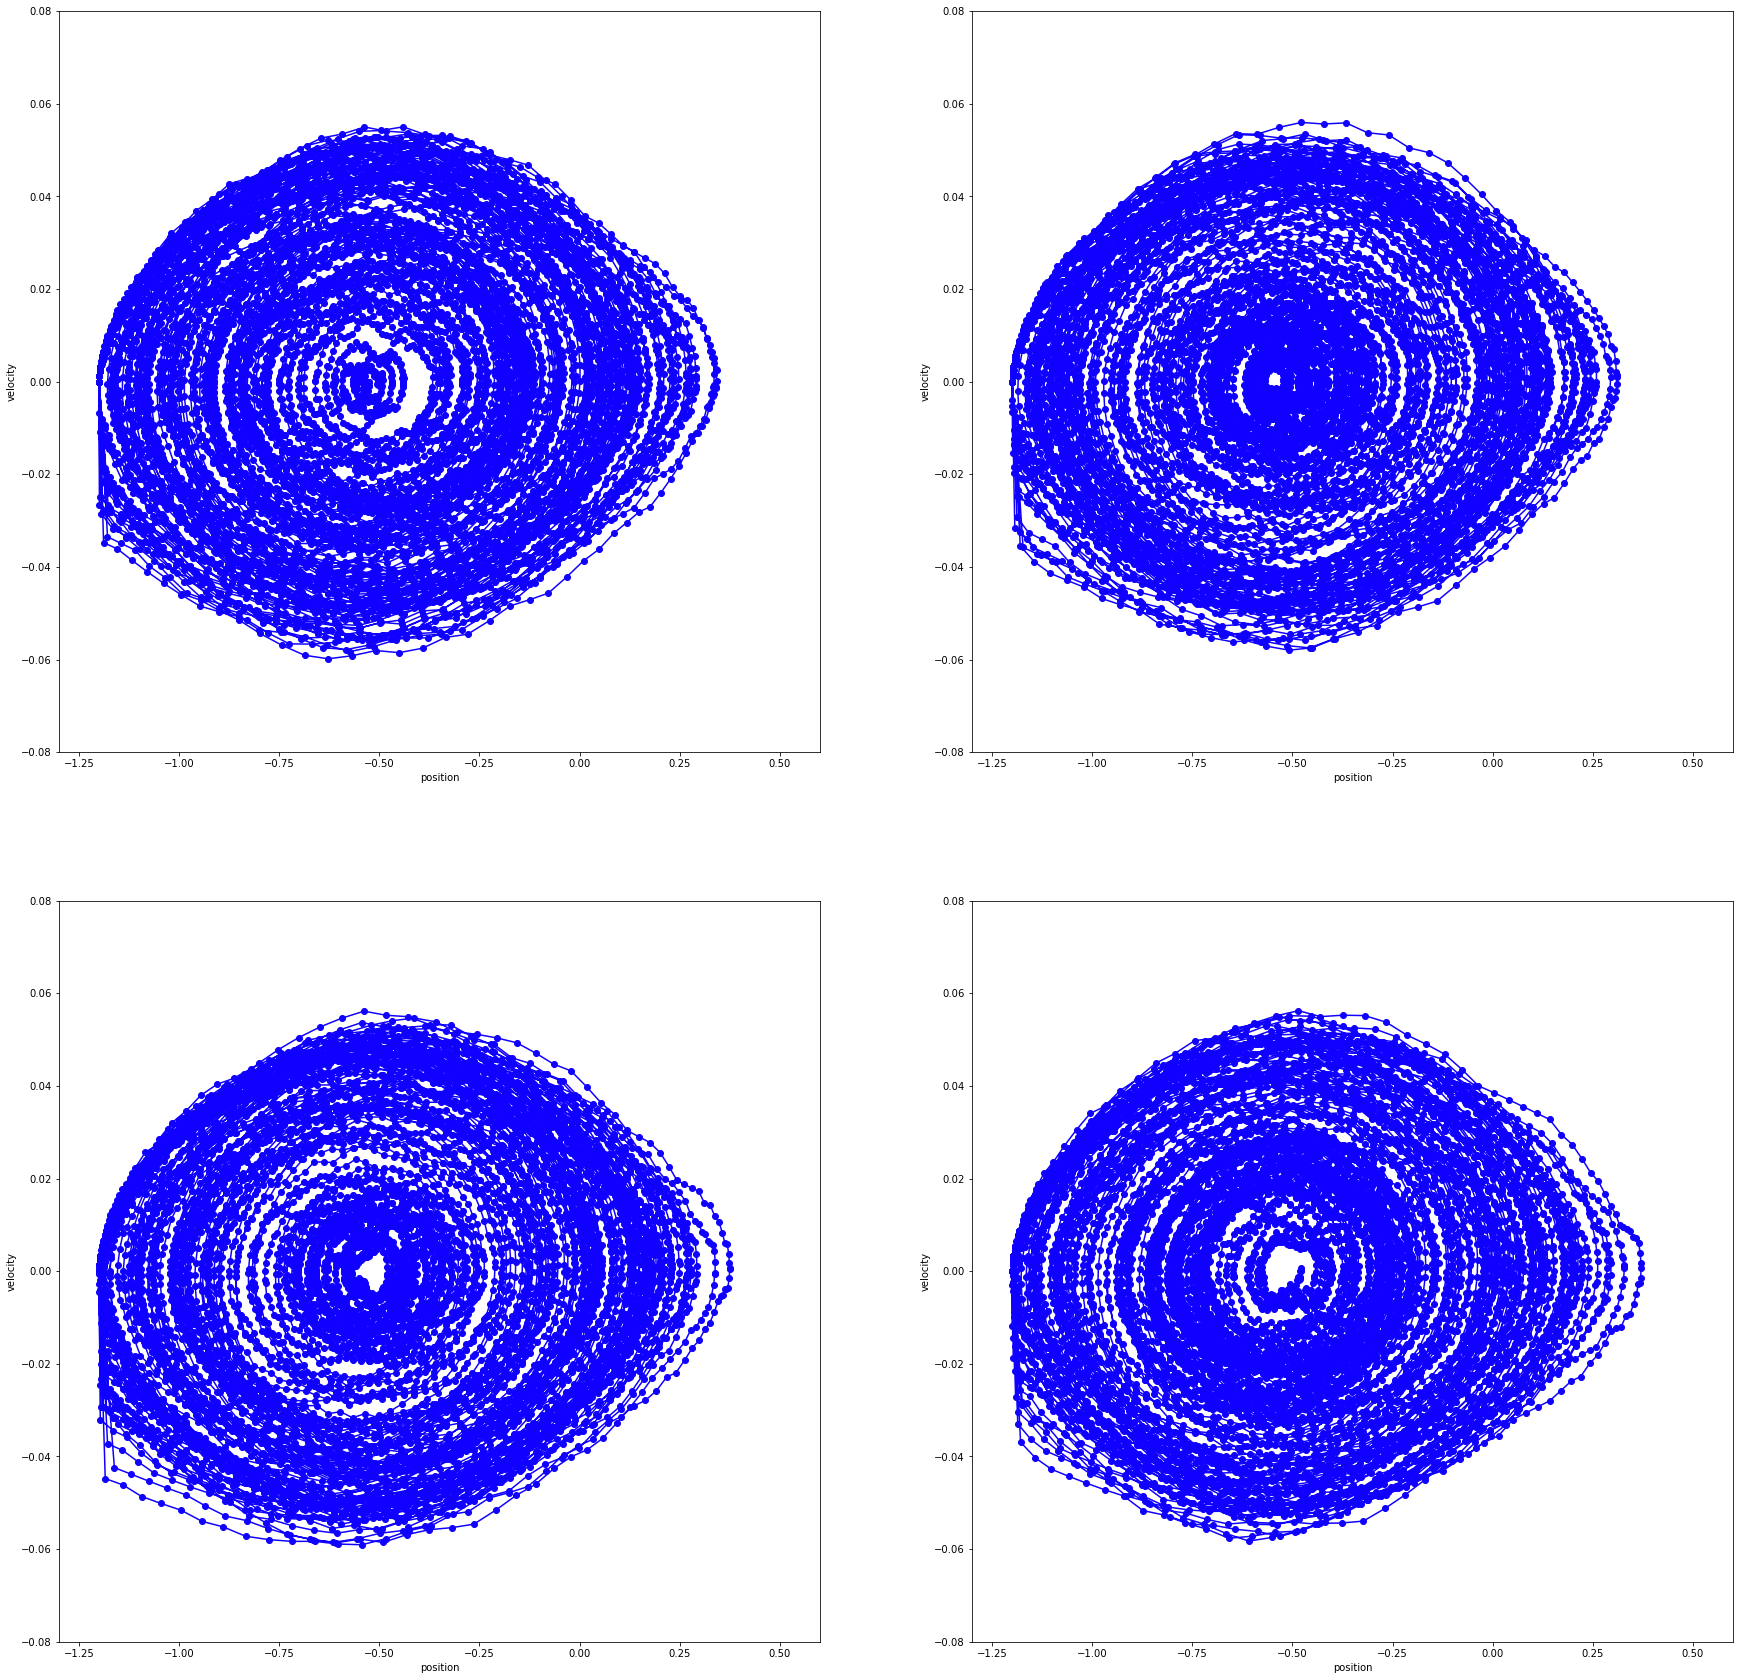

In [11]:
plot_phasespace_matrix(policy_evaluation, 2, 2)

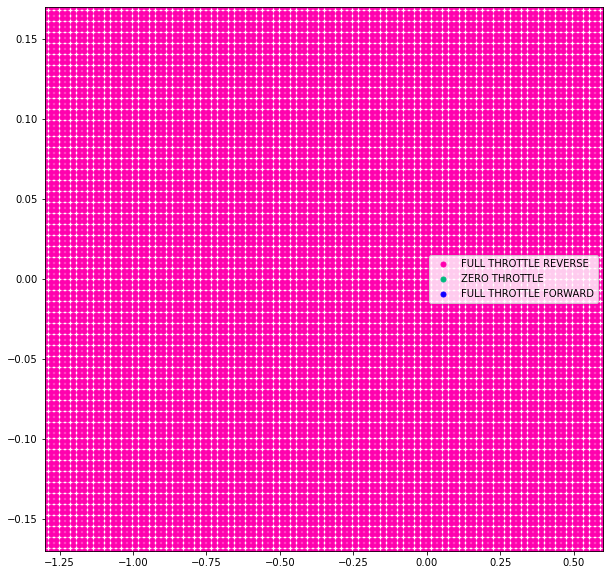

In [10]:
plot_policy_actions(policy_evaluation.agent.policy)

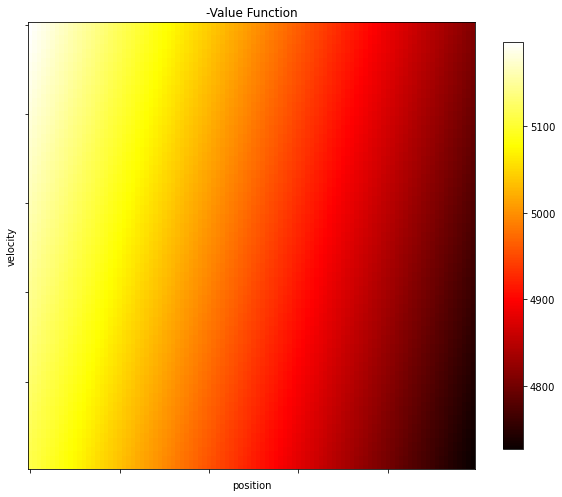

In [11]:
plot_valuefunction(value_function)

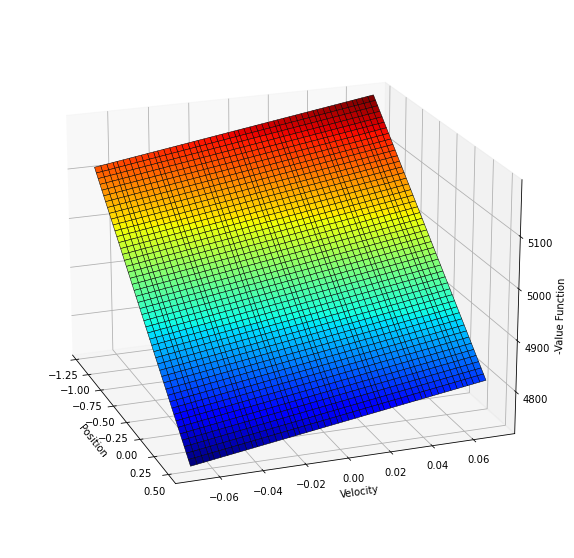

In [12]:
plot_valuefunction3d(value_function)

***

***
<a name='7'></a>

In [12]:
class DiscretizedMountainCar(MountainCar):
    
    def env_init(self, env_info={}):
        super().env_init(env_info)
        self.states = agent_info.get("states")
        
    def env_start(self):
        reward = 0.
        
        position = np.random.uniform(-0.6, -0.4)
        velocity = 0.
        self.current_state = self.env_discretize((position, velocity))
        state = self.current_state
        
        is_terminal = False
        
        self.reward_obs_term = [reward, state, is_terminal]
        return self.reward_obs_term[1]
    
    def env_step(self, action):
        position, velocity = self.current_state
        
        velocity = self.env_bound_velocity(velocity + 0.001*(action-1) - 0.0025*np.cos(3*position))
        position = self.env_bound_position(position + velocity)
        
        reward = -1
        is_terminal = False
        
        if position == self.left_bound:
            velocity = 0.
        elif position == self.right_bound:    
            reward = 0.
            is_terminal = True
        
        self.current_state = self.env_discretize((position, velocity))
        
        self.reward_obs_term = [reward, self.current_state, is_terminal]

        return self.reward_obs_term

    def env_discretize(self, state):
        s = np.array([[state[0],state[1]]])
        idx = np.argmin(np.sum(np.square(s-self.states), axis=1))
        return self.states[idx,0], self.states[idx,1]

***
<a name='8'></a>

In [13]:
class QLearning(Agent):
    
    def agent_init(self, agent_info={}):
        self.discount = agent_info.get("discount")
        self.step_size = agent_info.get("step_size")
        self.num_actions = agent_info.get("num_actions")

        self.states = agent_info.get("states")
        
        self.epsilon = agent_info.get("epsilon")
        self.decay_factor = agent_info.get("decay_factor")
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        
        self.q = {(x,y):np.zeros(self.num_actions) for x,y in self.states}
        
        self.policy = {(x,y):np.ones(self.num_actions)/self.num_actions for x,y in self.states}
            
    def agent_start(self, state):
        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_step(self, reward, state):
        action = self.agent_action(state)
        target = reward + self.discount*np.max(self.q[state])
        self.q[self.last_state][self.last_action] = self.q[self.last_state][self.last_action] + self.step_size*(target-self.q[self.last_state][self.last_action])
        
        self.agent_improvement(self.last_state)
        
        self.last_state = state
        self.last_action = action
        return action

    def agent_end(self, reward):
        target = reward
        self.q[self.last_state][self.last_action] = self.q[self.last_state][self.last_action] + self.step_size*(target-self.q[self.last_state][self.last_action])
            
    def agent_cleanup(self):
        self.last_state = None
        self.last_action = None
                          
    def agent_action(self, state):
        return self.rand_generator.choice(range(self.num_actions), p=self.policy[state])
    
    def agent_improvement(self, state):
        self.epsilon = self.decay_factor*self.epsilon

        idx = self.agent_argmax(state)

        self.policy[state] = np.zeros(self.num_actions)
        self.policy[state][idx] = 1.
        d1 = self.epsilon/self.num_actions
        d2 = 1-(self.num_actions-1)*d1
        self.policy[state] = d1*(np.ones(self.num_actions)-self.policy[state]) + d2*self.policy[state]

    def agent_argmax(self, state):
        q_max = np.max(self.q[state])
        y = 1-np.square(np.sign(self.q[state]-q_max))
        y = y/np.sum(y)
        return self.rand_generator.choice(self.num_actions, p=y)

***
<a name='9'></a>

In [14]:
class PolicyControl(RLGlue):
    
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        history = []
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode)
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {} - Epsilon: {}'.format(episode+1, num_episodes, self.num_steps, self.agent.epsilon))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))
                history.append(self.num_steps)
        self.rl_cleanup()
        return self.agent.policy, np.array(history)

***
<a name='10'></a>

In [15]:
states = []
for x in np.round(np.linspace(-1.2, 0.5, 100), 3):
    for v in np.round(np.linspace(-0.07, 0.07, 100), 3):
        states.append([x,v])
states = np.array(states)

env_info = {"states": states}

discretized_mountain_car = DiscretizedMountainCar()

In [16]:
agent_info = {"discount": 1.,
              "step_size": 0.5,
              "states": states,
              "num_actions": 3,
              "epsilon": 0.9,
              "decay_factor": 0.9999}

q_learning = QLearning()

In [17]:
num_episodes = 10000
max_steps_this_episode = float('inf')

policy_control = PolicyControl(env=discretized_mountain_car, 
                               agent=q_learning)

initial_policy, history = policy_control.rl_run(env_info=env_info,
                                                agent_info=agent_info,
                                                num_episodes=num_episodes,
                                                max_steps_this_episode=max_steps_this_episode)

Episode: 1/10000 - Steps: 7368 - Epsilon: 0.4308060228786805
----- 1.242s -----
Episode: 2/10000 - Steps: 2342 - Epsilon: 0.34088535557247285
----- 0.415s -----
Episode: 3/10000 - Steps: 4503 - Epsilon: 0.21730973989220953
----- 0.812s -----
Episode: 4/10000 - Steps: 3145 - Epsilon: 0.1586829184524609
----- 0.568s -----
Episode: 5/10000 - Steps: 5398 - Epsilon: 0.09249744298587247
----- 0.977s -----
Episode: 6/10000 - Steps: 4784 - Epsilon: 0.05733189405543267
----- 0.86s -----
Episode: 7/10000 - Steps: 9616 - Epsilon: 0.021918017291108104
----- 1.717s -----
Episode: 8/10000 - Steps: 2375 - Epsilon: 0.01728600362693131
----- 0.43s -----
Episode: 9/10000 - Steps: 1977 - Epsilon: 0.01418644958573397
----- 0.367s -----
Episode: 10/10000 - Steps: 6922 - Epsilon: 0.007100410840154301
----- 1.261s -----
Episode: 11/10000 - Steps: 1473 - Epsilon: 0.006128470980970724
----- 0.268s -----
Episode: 12/10000 - Steps: 7188 - Epsilon: 0.0029868202180693536
----- 1.334s -----
Episode: 13/10000 - Step

Episode: 100/10000 - Steps: 1415 - Epsilon: 5.385760887298378e-09
----- 0.258s -----
Episode: 101/10000 - Steps: 560 - Epsilon: 5.092942729977177e-09
----- 0.101s -----
Episode: 102/10000 - Steps: 1168 - Epsilon: 4.531939382340832e-09
----- 0.206s -----
Episode: 103/10000 - Steps: 1108 - Epsilon: 4.057002628963444e-09
----- 0.194s -----
Episode: 104/10000 - Steps: 957 - Epsilon: 3.687097827215877e-09
----- 0.168s -----
Episode: 105/10000 - Steps: 643 - Epsilon: 3.4578134612749262e-09
----- 0.113s -----
Episode: 106/10000 - Steps: 1225 - Epsilon: 3.0594351924289975e-09
----- 0.216s -----
Episode: 107/10000 - Steps: 768 - Epsilon: 2.8335390725539693e-09
----- 0.134s -----
Episode: 108/10000 - Steps: 656 - Epsilon: 2.6538813022552566e-09
----- 0.116s -----
Episode: 109/10000 - Steps: 761 - Epsilon: 2.459650853900945e-09
----- 0.133s -----
Episode: 110/10000 - Steps: 599 - Epsilon: 2.3168683400147446e-09
----- 0.106s -----
Episode: 111/10000 - Steps: 406 - Epsilon: 2.2249053941441437e-09
-

Episode: 198/10000 - Steps: 453 - Epsilon: 3.275411851861088e-12
----- 0.083s -----
Episode: 199/10000 - Steps: 546 - Epsilon: 3.10167067050603e-12
----- 0.096s -----
Episode: 200/10000 - Steps: 614 - Epsilon: 2.9172396011422766e-12
----- 0.108s -----
Episode: 201/10000 - Steps: 533 - Epsilon: 2.7660910960259996e-12
----- 0.094s -----
Episode: 202/10000 - Steps: 742 - Epsilon: 2.5685241202249965e-12
----- 0.131s -----
Episode: 203/10000 - Steps: 759 - Epsilon: 2.381016914460852e-12
----- 0.134s -----
Episode: 204/10000 - Steps: 573 - Epsilon: 2.2486382510053413e-12
----- 0.101s -----
Episode: 205/10000 - Steps: 1066 - Epsilon: 2.021458914979681e-12
----- 0.189s -----
Episode: 206/10000 - Steps: 1242 - Epsilon: 1.7855264120241826e-12
----- 0.218s -----
Episode: 207/10000 - Steps: 689 - Epsilon: 1.666807033337621e-12
----- 0.122s -----
Episode: 208/10000 - Steps: 466 - Epsilon: 1.5910712238413374e-12
----- 0.082s -----
Episode: 209/10000 - Steps: 495 - Epsilon: 1.5143783805641725e-12
---

Episode: 297/10000 - Steps: 842 - Epsilon: 7.630060589711472e-15
----- 0.152s -----
Episode: 298/10000 - Steps: 402 - Epsilon: 7.330133885263834e-15
----- 0.074s -----
Episode: 299/10000 - Steps: 409 - Epsilon: 7.037068948830077e-15
----- 0.075s -----
Episode: 300/10000 - Steps: 790 - Epsilon: 6.503157288855012e-15
----- 0.142s -----
Episode: 301/10000 - Steps: 442 - Epsilon: 6.222586090811992e-15
----- 0.08s -----
Episode: 302/10000 - Steps: 383 - Epsilon: 5.989354721965378e-15
----- 0.069s -----
Episode: 303/10000 - Steps: 610 - Epsilon: 5.6354704730963666e-15
----- 0.109s -----
Episode: 304/10000 - Steps: 410 - Epsilon: 5.4096185935381634e-15
----- 0.074s -----
Episode: 305/10000 - Steps: 694 - Epsilon: 5.047409416697284e-15
----- 0.124s -----
Episode: 306/10000 - Steps: 429 - Epsilon: 4.83592771189956e-15
----- 0.078s -----
Episode: 307/10000 - Steps: 709 - Epsilon: 4.50536741319703e-15
----- 0.127s -----
Episode: 308/10000 - Steps: 577 - Epsilon: 4.253178408712338e-15
----- 0.104s

Episode: 395/10000 - Steps: 727 - Epsilon: 4.6311756003093475e-17
----- 0.128s -----
Episode: 396/10000 - Steps: 380 - Epsilon: 4.458930103274889e-17
----- 0.068s -----
Episode: 397/10000 - Steps: 797 - Epsilon: 4.1177416498305933e-17
----- 0.139s -----
Episode: 398/10000 - Steps: 544 - Epsilon: 3.90009984718426e-17
----- 0.097s -----
Episode: 399/10000 - Steps: 660 - Epsilon: 3.6513569273649e-17
----- 0.117s -----
Episode: 400/10000 - Steps: 434 - Epsilon: 3.496619673691226e-17
----- 0.077s -----
Episode: 401/10000 - Steps: 699 - Epsilon: 3.2608673036295186e-17
----- 0.124s -----
Episode: 402/10000 - Steps: 255 - Epsilon: 3.179080277248642e-17
----- 0.045s -----
Episode: 403/10000 - Steps: 431 - Epsilon: 3.045270659738463e-17
----- 0.076s -----
Episode: 404/10000 - Steps: 723 - Epsilon: 2.833141519636375e-17
----- 0.127s -----
Episode: 405/10000 - Steps: 551 - Epsilon: 2.681518995707178e-17
----- 0.098s -----
Episode: 406/10000 - Steps: 589 - Epsilon: 2.5283843027030097e-17
----- 0.10

Episode: 493/10000 - Steps: 433 - Epsilon: 4.607338741618047e-19
----- 0.076s -----
Episode: 494/10000 - Steps: 443 - Epsilon: 4.408119585571631e-19
----- 0.078s -----
Episode: 495/10000 - Steps: 469 - Epsilon: 4.2065627300295927e-19
----- 0.083s -----
Episode: 496/10000 - Steps: 458 - Epsilon: 4.0186401545305396e-19
----- 0.081s -----
Episode: 497/10000 - Steps: 494 - Epsilon: 3.825316122325569e-19
----- 0.086s -----
Episode: 498/10000 - Steps: 628 - Epsilon: 3.5928220319172773e-19
----- 0.111s -----
Episode: 499/10000 - Steps: 222 - Epsilon: 3.514287738716659e-19
----- 0.04s -----
Episode: 500/10000 - Steps: 670 - Epsilon: 3.2868627049935586e-19
----- 0.118s -----
Episode: 501/10000 - Steps: 316 - Epsilon: 3.184935219632481e-19
----- 0.055s -----
Episode: 502/10000 - Steps: 520 - Epsilon: 3.0238454658219594e-19
----- 0.092s -----
Episode: 503/10000 - Steps: 476 - Epsilon: 2.8835638564135503e-19
----- 0.083s -----
Episode: 504/10000 - Steps: 878 - Epsilon: 2.641435697074751e-19
----- 

Episode: 591/10000 - Steps: 708 - Epsilon: 6.120871800417223e-21
----- 0.125s -----
Episode: 592/10000 - Steps: 422 - Epsilon: 5.8685197635522826e-21
----- 0.075s -----
Episode: 593/10000 - Steps: 399 - Epsilon: 5.639528383995077e-21
----- 0.071s -----
Episode: 594/10000 - Steps: 420 - Epsilon: 5.408102797724241e-21
----- 0.074s -----
Episode: 595/10000 - Steps: 463 - Epsilon: 5.163920288473612e-21
----- 0.081s -----
Episode: 596/10000 - Steps: 316 - Epsilon: 5.003784177887212e-21
----- 0.055s -----
Episode: 597/10000 - Steps: 378 - Epsilon: 4.8186440768509106e-21
----- 0.067s -----
Episode: 598/10000 - Steps: 395 - Epsilon: 4.632471868402411e-21
----- 0.07s -----
Episode: 599/10000 - Steps: 492 - Epsilon: 4.410500395262633e-21
----- 0.088s -----
Episode: 600/10000 - Steps: 327 - Epsilon: 4.2690295136232276e-21
----- 0.058s -----
Episode: 601/10000 - Steps: 444 - Epsilon: 4.084030245303112e-21
----- 0.079s -----
Episode: 602/10000 - Steps: 540 - Epsilon: 3.869717902210678e-21
----- 0.0

Episode: 690/10000 - Steps: 485 - Epsilon: 1.2122686692129563e-22
----- 0.087s -----
Episode: 691/10000 - Steps: 293 - Epsilon: 1.1773805255409194e-22
----- 0.052s -----
Episode: 692/10000 - Steps: 291 - Epsilon: 1.1437251689395308e-22
----- 0.052s -----
Episode: 693/10000 - Steps: 563 - Epsilon: 1.0812176037525979e-22
----- 0.1s -----
Episode: 694/10000 - Steps: 412 - Epsilon: 1.0376782460945036e-22
----- 0.074s -----
Episode: 695/10000 - Steps: 438 - Epsilon: 9.933060814441573e-23
----- 0.082s -----
Episode: 696/10000 - Steps: 527 - Epsilon: 9.424060432485052e-23
----- 0.096s -----
Episode: 697/10000 - Steps: 413 - Epsilon: 9.043660177638996e-23
----- 0.073s -----
Episode: 698/10000 - Steps: 316 - Epsilon: 8.763211122384436e-23
----- 0.06s -----
Episode: 699/10000 - Steps: 331 - Epsilon: 8.478730675876562e-23
----- 0.062s -----
Episode: 700/10000 - Steps: 498 - Epsilon: 8.067617980319933e-23
----- 0.092s -----
Episode: 701/10000 - Steps: 469 - Epsilon: 7.698734223819745e-23
----- 0.0

Episode: 790/10000 - Steps: 380 - Epsilon: 2.8291486494448534e-24
----- 0.068s -----
Episode: 791/10000 - Steps: 440 - Epsilon: 2.7076298027525156e-24
----- 0.078s -----
Episode: 792/10000 - Steps: 249 - Epsilon: 2.641303117747625e-24
----- 0.045s -----
Episode: 793/10000 - Steps: 255 - Epsilon: 2.575055611284955e-24
----- 0.045s -----
Episode: 794/10000 - Steps: 424 - Epsilon: 2.468397156138822e-24
----- 0.076s -----
Episode: 795/10000 - Steps: 340 - Epsilon: 2.3861169086759488e-24
----- 0.06s -----
Episode: 796/10000 - Steps: 334 - Epsilon: 2.3079637796565427e-24
----- 0.059s -----
Episode: 797/10000 - Steps: 369 - Epsilon: 2.224570392627532e-24
----- 0.068s -----
Episode: 798/10000 - Steps: 347 - Epsilon: 2.1489128968524686e-24
----- 0.064s -----
Episode: 799/10000 - Steps: 259 - Epsilon: 2.0941773323715386e-24
----- 0.046s -----
Episode: 800/10000 - Steps: 354 - Epsilon: 2.0215388527798624e-24
----- 0.065s -----
Episode: 801/10000 - Steps: 452 - Epsilon: 1.932388445911289e-24
-----

Episode: 890/10000 - Steps: 387 - Epsilon: 8.254589098174048e-26
----- 0.068s -----
Episode: 891/10000 - Steps: 392 - Epsilon: 7.93804755294906e-26
----- 0.07s -----
Episode: 892/10000 - Steps: 324 - Epsilon: 7.685732821129324e-26
----- 0.058s -----
Episode: 893/10000 - Steps: 606 - Epsilon: 7.234510528982822e-26
----- 0.108s -----
Episode: 894/10000 - Steps: 368 - Epsilon: 6.973804181219955e-26
----- 0.069s -----
Episode: 895/10000 - Steps: 321 - Epsilon: 6.754164444250718e-26
----- 0.06s -----
Episode: 896/10000 - Steps: 463 - Epsilon: 6.449205592029462e-26
----- 0.084s -----
Episode: 897/10000 - Steps: 335 - Epsilon: 6.23734922901561e-26
----- 0.061s -----
Episode: 898/10000 - Steps: 471 - Epsilon: 5.950962308063588e-26
----- 0.087s -----
Episode: 899/10000 - Steps: 516 - Epsilon: 5.652231165501941e-26
----- 0.095s -----
Episode: 900/10000 - Steps: 313 - Epsilon: 5.478595670724482e-26
----- 0.057s -----
Episode: 901/10000 - Steps: 346 - Epsilon: 5.292798264650236e-26
----- 0.064s --

Episode: 990/10000 - Steps: 425 - Epsilon: 2.8325738381536857e-27
----- 0.075s -----
Episode: 991/10000 - Steps: 378 - Epsilon: 2.7277685572012982e-27
----- 0.066s -----
Episode: 992/10000 - Steps: 321 - Epsilon: 2.6418575747808243e-27
----- 0.057s -----
Episode: 993/10000 - Steps: 476 - Epsilon: 2.519297068099205e-27
----- 0.084s -----
Episode: 994/10000 - Steps: 324 - Epsilon: 2.439219976110065e-27
----- 0.057s -----
Episode: 995/10000 - Steps: 293 - Epsilon: 2.3690211339429393e-27
----- 0.053s -----
Episode: 996/10000 - Steps: 322 - Epsilon: 2.2941794491175528e-27
----- 0.057s -----
Episode: 997/10000 - Steps: 325 - Epsilon: 2.2210357051922983e-27
----- 0.058s -----
Episode: 998/10000 - Steps: 330 - Epsilon: 2.149149055922506e-27
----- 0.058s -----
Episode: 999/10000 - Steps: 421 - Epsilon: 2.0607497558024263e-27
----- 0.074s -----
Episode: 1000/10000 - Steps: 285 - Epsilon: 2.0030448655662145e-27
----- 0.05s -----
Episode: 1001/10000 - Steps: 421 - Epsilon: 1.920655157073347e-27
--

Episode: 1088/10000 - Steps: 288 - Epsilon: 1.170594288973164e-28
----- 0.051s -----
Episode: 1089/10000 - Steps: 252 - Epsilon: 1.1415766167111876e-28
----- 0.045s -----
Episode: 1090/10000 - Steps: 373 - Epsilon: 1.0998880962392286e-28
----- 0.065s -----
Episode: 1091/10000 - Steps: 312 - Epsilon: 1.0662063582254686e-28
----- 0.055s -----
Episode: 1092/10000 - Steps: 266 - Epsilon: 1.0383216004141266e-28
----- 0.047s -----
Episode: 1093/10000 - Steps: 403 - Epsilon: 9.974069214632593e-29
----- 0.07s -----
Episode: 1094/10000 - Steps: 319 - Epsilon: 9.661868504626636e-29
----- 0.056s -----
Episode: 1095/10000 - Steps: 270 - Epsilon: 9.405416167827956e-29
----- 0.047s -----
Episode: 1096/10000 - Steps: 341 - Epsilon: 9.090991801349834e-29
----- 0.061s -----
Episode: 1097/10000 - Steps: 377 - Epsilon: 8.755500497677146e-29
----- 0.066s -----
Episode: 1098/10000 - Steps: 415 - Epsilon: 8.400406193367998e-29
----- 0.072s -----
Episode: 1099/10000 - Steps: 291 - Epsilon: 8.160281051239941e

Episode: 1185/10000 - Steps: 277 - Epsilon: 5.543517571462309e-30
----- 0.05s -----
Episode: 1186/10000 - Steps: 231 - Epsilon: 5.417465520223774e-30
----- 0.041s -----
Episode: 1187/10000 - Steps: 230 - Epsilon: 5.2948092021390924e-30
----- 0.041s -----
Episode: 1188/10000 - Steps: 288 - Epsilon: 5.145000722523254e-30
----- 0.05s -----
Episode: 1189/10000 - Steps: 385 - Epsilon: 4.951168402270758e-30
----- 0.068s -----
Episode: 1190/10000 - Steps: 301 - Epsilon: 4.8048320540961676e-30
----- 0.054s -----
Episode: 1191/10000 - Steps: 407 - Epsilon: 4.613653499780525e-30
----- 0.072s -----
Episode: 1192/10000 - Steps: 330 - Epsilon: 4.4643267283937695e-30
----- 0.058s -----
Episode: 1193/10000 - Steps: 330 - Epsilon: 4.319833108142848e-30
----- 0.058s -----
Episode: 1194/10000 - Steps: 256 - Epsilon: 4.211064617746008e-30
----- 0.046s -----
Episode: 1195/10000 - Steps: 320 - Epsilon: 4.078845158423756e-30
----- 0.056s -----
Episode: 1196/10000 - Steps: 288 - Epsilon: 3.963440510504616e-3

Episode: 1282/10000 - Steps: 238 - Epsilon: 2.864707334910346e-31
----- 0.042s -----
Episode: 1283/10000 - Steps: 319 - Epsilon: 2.7750384500577895e-31
----- 0.056s -----
Episode: 1284/10000 - Steps: 241 - Epsilon: 2.7092271315289014e-31
----- 0.042s -----
Episode: 1285/10000 - Steps: 277 - Epsilon: 2.6354712876857186e-31
----- 0.049s -----
Episode: 1286/10000 - Steps: 333 - Epsilon: 2.54940592820249e-31
----- 0.059s -----
Episode: 1287/10000 - Steps: 234 - Epsilon: 2.490688548166852e-31
----- 0.041s -----
Episode: 1288/10000 - Steps: 325 - Epsilon: 2.4112796399252788e-31
----- 0.058s -----
Episode: 1289/10000 - Steps: 233 - Epsilon: 2.355979153365628e-31
----- 0.041s -----
Episode: 1290/10000 - Steps: 379 - Epsilon: 2.268581003196518e-31
----- 0.067s -----
Episode: 1291/10000 - Steps: 283 - Epsilon: 2.2054975224541327e-31
----- 0.05s -----
Episode: 1292/10000 - Steps: 277 - Epsilon: 2.1454551845602085e-31
----- 0.049s -----
Episode: 1293/10000 - Steps: 249 - Epsilon: 2.092899650537877

Episode: 1379/10000 - Steps: 271 - Epsilon: 1.6887856690567245e-32
----- 0.047s -----
Episode: 1380/10000 - Steps: 241 - Epsilon: 1.6487353369285327e-32
----- 0.043s -----
Episode: 1381/10000 - Steps: 309 - Epsilon: 1.5987258871130056e-32
----- 0.055s -----
Episode: 1382/10000 - Steps: 311 - Epsilon: 1.5499232930572283e-32
----- 0.054s -----
Episode: 1383/10000 - Steps: 374 - Epsilon: 1.4931732841640553e-32
----- 0.067s -----
Episode: 1384/10000 - Steps: 207 - Epsilon: 1.4627270649577916e-32
----- 0.037s -----
Episode: 1385/10000 - Steps: 258 - Epsilon: 1.4256120939055134e-32
----- 0.045s -----
Episode: 1386/10000 - Steps: 300 - Epsilon: 1.3836151752657367e-32
----- 0.052s -----
Episode: 1387/10000 - Steps: 322 - Epsilon: 1.339904256277642e-32
----- 0.056s -----
Episode: 1388/10000 - Steps: 254 - Epsilon: 1.306428261803969e-32
----- 0.045s -----
Episode: 1389/10000 - Steps: 376 - Epsilon: 1.258342049371445e-32
----- 0.066s -----
Episode: 1390/10000 - Steps: 235 - Epsilon: 1.22923724447

Episode: 1477/10000 - Steps: 306 - Epsilon: 1.0110142554155601e-33
----- 0.054s -----
Episode: 1478/10000 - Steps: 200 - Epsilon: 9.910929500871539e-34
----- 0.035s -----
Episode: 1479/10000 - Steps: 228 - Epsilon: 9.68847469313424e-34
----- 0.04s -----
Episode: 1480/10000 - Steps: 214 - Epsilon: 9.484282341260185e-34
----- 0.037s -----
Episode: 1481/10000 - Steps: 306 - Epsilon: 9.19936456759917e-34
----- 0.054s -----
Episode: 1482/10000 - Steps: 236 - Epsilon: 8.985689334226496e-34
----- 0.042s -----
Episode: 1483/10000 - Steps: 233 - Epsilon: 8.77961079234822e-34
----- 0.041s -----
Episode: 1484/10000 - Steps: 292 - Epsilon: 8.52779324331467e-34
----- 0.051s -----
Episode: 1485/10000 - Steps: 290 - Epsilon: 8.2848552349981e-34
----- 0.051s -----
Episode: 1486/10000 - Steps: 235 - Epsilon: 8.09323079128945e-34
----- 0.042s -----
Episode: 1487/10000 - Steps: 174 - Epsilon: 7.95441517511655e-34
----- 0.031s -----
Episode: 1488/10000 - Steps: 273 - Epsilon: 7.740960552990072e-34
----- 0

Episode: 1576/10000 - Steps: 231 - Epsilon: 6.850280718699157e-35
----- 0.042s -----
Episode: 1577/10000 - Steps: 245 - Epsilon: 6.685148419552099e-35
----- 0.043s -----
Episode: 1578/10000 - Steps: 293 - Epsilon: 6.492755079318657e-35
----- 0.052s -----
Episode: 1579/10000 - Steps: 276 - Epsilon: 6.316628350740455e-35
----- 0.048s -----
Episode: 1580/10000 - Steps: 241 - Epsilon: 6.166826591989858e-35
----- 0.043s -----
Episode: 1581/10000 - Steps: 234 - Epsilon: 6.024793541619155e-35
----- 0.042s -----
Episode: 1582/10000 - Steps: 251 - Epsilon: 5.876033513529272e-35
----- 0.044s -----
Episode: 1583/10000 - Steps: 234 - Epsilon: 5.740697948055276e-35
----- 0.041s -----
Episode: 1584/10000 - Steps: 283 - Epsilon: 5.581063706234644e-35
----- 0.05s -----
Episode: 1585/10000 - Steps: 314 - Epsilon: 5.409073501181505e-35
----- 0.055s -----
Episode: 1586/10000 - Steps: 310 - Epsilon: 5.244480951782682e-35
----- 0.055s -----
Episode: 1587/10000 - Steps: 327 - Epsilon: 5.076259372030253e-35


Episode: 1675/10000 - Steps: 208 - Epsilon: 4.482309317045825e-36
----- 0.037s -----
Episode: 1676/10000 - Steps: 244 - Epsilon: 4.3746966098736796e-36
----- 0.043s -----
Episode: 1677/10000 - Steps: 258 - Epsilon: 4.2636938521290876e-36
----- 0.045s -----
Episode: 1678/10000 - Steps: 290 - Epsilon: 4.142230624427155e-36
----- 0.05s -----
Episode: 1679/10000 - Steps: 237 - Epsilon: 4.045613714793789e-36
----- 0.041s -----
Episode: 1680/10000 - Steps: 162 - Epsilon: 3.980997658208874e-36
----- 0.03s -----
Episode: 1681/10000 - Steps: 298 - Epsilon: 3.864494833600872e-36
----- 0.052s -----
Episode: 1682/10000 - Steps: 287 - Epsilon: 3.7555304513616305e-36
----- 0.05s -----
Episode: 1683/10000 - Steps: 239 - Epsilon: 3.6671997154405754e-36
----- 0.042s -----
Episode: 1684/10000 - Steps: 266 - Epsilon: 3.571290536957464e-36
----- 0.046s -----
Episode: 1685/10000 - Steps: 229 - Epsilon: 3.4907823681220767e-36
----- 0.041s -----
Episode: 1686/10000 - Steps: 288 - Epsilon: 3.3920160520427575e

Episode: 1773/10000 - Steps: 239 - Epsilon: 3.51625397286962e-37
----- 0.043s -----
Episode: 1774/10000 - Steps: 209 - Epsilon: 3.443867697996724e-37
----- 0.038s -----
Episode: 1775/10000 - Steps: 253 - Epsilon: 3.3581623695130257e-37
----- 0.044s -----
Episode: 1776/10000 - Steps: 187 - Epsilon: 3.296274793761949e-37
----- 0.033s -----
Episode: 1777/10000 - Steps: 225 - Epsilon: 3.2232554572321338e-37
----- 0.04s -----
Episode: 1778/10000 - Steps: 379 - Epsilon: 3.1036845501287567e-37
----- 0.068s -----
Episode: 1779/10000 - Steps: 177 - Epsilon: 3.049534909204858e-37
----- 0.032s -----
Episode: 1780/10000 - Steps: 352 - Epsilon: 2.944347807695503e-37
----- 0.062s -----
Episode: 1781/10000 - Steps: 197 - Epsilon: 2.8871976344534757e-37
----- 0.035s -----
Episode: 1782/10000 - Steps: 315 - Epsilon: 2.797943785040529e-37
----- 0.056s -----
Episode: 1783/10000 - Steps: 245 - Epsilon: 2.7304967840954804e-37
----- 0.044s -----
Episode: 1784/10000 - Steps: 279 - Epsilon: 2.6556306906346323

Episode: 1873/10000 - Steps: 251 - Epsilon: 2.705950062254232e-38
----- 0.044s -----
Episode: 1874/10000 - Steps: 279 - Epsilon: 2.6317570027929935e-38
----- 0.049s -----
Episode: 1875/10000 - Steps: 331 - Epsilon: 2.546322177955515e-38
----- 0.059s -----
Episode: 1876/10000 - Steps: 239 - Epsilon: 2.486432233037251e-38
----- 0.041s -----
Episode: 1877/10000 - Steps: 290 - Epsilon: 2.415599266374782e-38
----- 0.051s -----
Episode: 1878/10000 - Steps: 196 - Epsilon: 2.3689490658791825e-38
----- 0.035s -----
Episode: 1879/10000 - Steps: 150 - Epsilon: 2.333911649898058e-38
----- 0.027s -----
Episode: 1880/10000 - Steps: 277 - Epsilon: 2.2703733731731707e-38
----- 0.049s -----
Episode: 1881/10000 - Steps: 240 - Epsilon: 2.2167520952379225e-38
----- 0.043s -----
Episode: 1882/10000 - Steps: 197 - Epsilon: 2.1737246492458566e-38
----- 0.035s -----
Episode: 1883/10000 - Steps: 292 - Epsilon: 2.11137769259899e-38
----- 0.052s -----
Episode: 1884/10000 - Steps: 341 - Epsilon: 2.040794043609350

Episode: 1974/10000 - Steps: 251 - Epsilon: 2.1410820448153294e-39
----- 0.045s -----
Episode: 1975/10000 - Steps: 241 - Epsilon: 2.0903052952373584e-39
----- 0.043s -----
Episode: 1976/10000 - Steps: 314 - Epsilon: 2.0258888944802892e-39
----- 0.055s -----
Episode: 1977/10000 - Steps: 246 - Epsilon: 1.9768552794286824e-39
----- 0.044s -----
Episode: 1978/10000 - Steps: 158 - Epsilon: 1.9460594912638596e-39
----- 0.029s -----
Episode: 1979/10000 - Steps: 334 - Epsilon: 1.8823196812205283e-39
----- 0.059s -----
Episode: 1980/10000 - Steps: 293 - Epsilon: 1.8281479937531273e-39
----- 0.052s -----
Episode: 1981/10000 - Steps: 212 - Epsilon: 1.7899762902027248e-39
----- 0.038s -----
Episode: 1982/10000 - Steps: 251 - Epsilon: 1.7457794357592747e-39
----- 0.045s -----
Episode: 1983/10000 - Steps: 171 - Epsilon: 1.716350568036361e-39
----- 0.03s -----
Episode: 1984/10000 - Steps: 232 - Epsilon: 1.677155357784617e-39
----- 0.042s -----
Episode: 1985/10000 - Steps: 236 - Epsilon: 1.63819977994

Episode: 2071/10000 - Steps: 369 - Epsilon: 1.9777845907547908e-40
----- 0.067s -----
Episode: 2072/10000 - Steps: 243 - Epsilon: 1.930494358926473e-40
----- 0.043s -----
Episode: 2073/10000 - Steps: 164 - Epsilon: 1.899280821627311e-40
----- 0.029s -----
Episode: 2074/10000 - Steps: 287 - Epsilon: 1.8457281658887035e-40
----- 0.05s -----
Episode: 2075/10000 - Steps: 225 - Epsilon: 1.8048414514853307e-40
----- 0.04s -----
Episode: 2076/10000 - Steps: 269 - Epsilon: 1.757111748964843e-40
----- 0.048s -----
Episode: 2077/10000 - Steps: 325 - Epsilon: 1.7010909647738848e-40
----- 0.058s -----
Episode: 2078/10000 - Steps: 222 - Epsilon: 1.6639073872402142e-40
----- 0.039s -----
Episode: 2079/10000 - Steps: 238 - Epsilon: 1.6249344866552298e-40
----- 0.042s -----
Episode: 2080/10000 - Steps: 238 - Epsilon: 1.5868744295323616e-40
----- 0.043s -----
Episode: 2081/10000 - Steps: 289 - Epsilon: 1.5418220615373534e-40
----- 0.051s -----
Episode: 2082/10000 - Steps: 224 - Epsilon: 1.5078182807077

Episode: 2170/10000 - Steps: 207 - Epsilon: 1.8627321165437845e-41
----- 0.038s -----
Episode: 2171/10000 - Steps: 219 - Epsilon: 1.8225619931462537e-41
----- 0.039s -----
Episode: 2172/10000 - Steps: 229 - Epsilon: 1.781475689150895e-41
----- 0.04s -----
Episode: 2173/10000 - Steps: 283 - Epsilon: 1.73193737106958e-41
----- 0.05s -----
Episode: 2174/10000 - Steps: 233 - Epsilon: 1.6922169762530103e-41
----- 0.041s -----
Episode: 2175/10000 - Steps: 128 - Epsilon: 1.670860652536584e-41
----- 0.023s -----
Episode: 2176/10000 - Steps: 235 - Epsilon: 1.63221450435714e-41
----- 0.042s -----
Episode: 2177/10000 - Steps: 268 - Epsilon: 1.5892089064594563e-41
----- 0.047s -----
Episode: 2178/10000 - Steps: 254 - Epsilon: 1.5495043168808366e-41
----- 0.046s -----
Episode: 2179/10000 - Steps: 267 - Epsilon: 1.5088288504014917e-41
----- 0.047s -----
Episode: 2180/10000 - Steps: 170 - Epsilon: 1.4835426487623052e-41
----- 0.03s -----
Episode: 2181/10000 - Steps: 204 - Epsilon: 1.453728875946986e-

Episode: 2272/10000 - Steps: 153 - Epsilon: 1.8058162399262974e-42
----- 0.028s -----
Episode: 2273/10000 - Steps: 243 - Epsilon: 1.7626378932930743e-42
----- 0.044s -----
Episode: 2274/10000 - Steps: 288 - Epsilon: 1.7127667661520203e-42
----- 0.051s -----
Episode: 2275/10000 - Steps: 236 - Epsilon: 1.6729840359665576e-42
----- 0.043s -----
Episode: 2276/10000 - Steps: 244 - Epsilon: 1.6328185033288406e-42
----- 0.046s -----
Episode: 2277/10000 - Steps: 208 - Epsilon: 1.5993649267159574e-42
----- 0.039s -----
Episode: 2278/10000 - Steps: 200 - Epsilon: 1.567850596560881e-42
----- 0.037s -----
Episode: 2279/10000 - Steps: 228 - Epsilon: 1.5326595579213616e-42
----- 0.042s -----
Episode: 2280/10000 - Steps: 236 - Epsilon: 1.4970602090409872e-42
----- 0.045s -----
Episode: 2281/10000 - Steps: 154 - Epsilon: 1.4743283930863178e-42
----- 0.029s -----
Episode: 2282/10000 - Steps: 280 - Epsilon: 1.4337611471965339e-42
----- 0.05s -----
Episode: 2283/10000 - Steps: 291 - Epsilon: 1.3927771648

Episode: 2371/10000 - Steps: 247 - Epsilon: 1.789045424744926e-43
----- 0.044s -----
Episode: 2372/10000 - Steps: 168 - Epsilon: 1.7594149874240475e-43
----- 0.03s -----
Episode: 2373/10000 - Steps: 277 - Epsilon: 1.7115167748461427e-43
----- 0.049s -----
Episode: 2374/10000 - Steps: 231 - Epsilon: 1.672599210787333e-43
----- 0.041s -----
Episode: 2375/10000 - Steps: 203 - Epsilon: 1.6391500086168804e-43
----- 0.036s -----
Episode: 2376/10000 - Steps: 272 - Epsilon: 1.595323385091602e-43
----- 0.049s -----
Episode: 2377/10000 - Steps: 245 - Epsilon: 1.5568666518158204e-43
----- 0.043s -----
Episode: 2378/10000 - Steps: 251 - Epsilon: 1.518425579062631e-43
----- 0.044s -----
Episode: 2379/10000 - Steps: 232 - Epsilon: 1.483750256356806e-43
----- 0.041s -----
Episode: 2380/10000 - Steps: 275 - Epsilon: 1.4436454392379894e-43
----- 0.048s -----
Episode: 2381/10000 - Steps: 223 - Epsilon: 1.4119480682750587e-43
----- 0.04s -----
Episode: 2382/10000 - Steps: 200 - Epsilon: 1.384126651885235

Episode: 2468/10000 - Steps: 241 - Epsilon: 1.9980219797241207e-44
----- 0.044s -----
Episode: 2469/10000 - Steps: 184 - Epsilon: 1.9617889096222262e-44
----- 0.033s -----
Episode: 2470/10000 - Steps: 207 - Epsilon: 1.9217874872741056e-44
----- 0.036s -----
Episode: 2471/10000 - Steps: 238 - Epsilon: 1.8767743854263975e-44
----- 0.042s -----
Episode: 2472/10000 - Steps: 280 - Epsilon: 1.825133537749405e-44
----- 0.05s -----
Episode: 2473/10000 - Steps: 174 - Epsilon: 1.7938287296728586e-44
----- 0.031s -----
Episode: 2474/10000 - Steps: 161 - Epsilon: 1.7653544479928492e-44
----- 0.029s -----
Episode: 2475/10000 - Steps: 224 - Epsilon: 1.726420820544118e-44
----- 0.04s -----
Episode: 2476/10000 - Steps: 252 - Epsilon: 1.6836248544022126e-44
----- 0.045s -----
Episode: 2477/10000 - Steps: 228 - Epsilon: 1.6458352158769015e-44
----- 0.04s -----
Episode: 2478/10000 - Steps: 372 - Epsilon: 1.5858905809497104e-44
----- 0.066s -----
Episode: 2479/10000 - Steps: 321 - Epsilon: 1.5359430084325

Episode: 2568/10000 - Steps: 272 - Epsilon: 2.046904908309989e-45
----- 0.049s -----
Episode: 2569/10000 - Steps: 247 - Epsilon: 1.9971628957675836e-45
----- 0.044s -----
Episode: 2570/10000 - Steps: 133 - Epsilon: 1.9709722743973388e-45
----- 0.024s -----
Episode: 2571/10000 - Steps: 262 - Epsilon: 1.9201929124276998e-45
----- 0.046s -----
Episode: 2572/10000 - Steps: 240 - Epsilon: 1.8748421348581602e-45
----- 0.043s -----
Episode: 2573/10000 - Steps: 203 - Epsilon: 1.8373484105982776e-45
----- 0.036s -----
Episode: 2574/10000 - Steps: 235 - Epsilon: 1.7948514861387465e-45
----- 0.042s -----
Episode: 2575/10000 - Steps: 193 - Epsilon: 1.760717367059774e-45
----- 0.034s -----
Episode: 2576/10000 - Steps: 178 - Epsilon: 1.7298253261471835e-45
----- 0.031s -----
Episode: 2577/10000 - Steps: 232 - Epsilon: 1.6903224013835654e-45
----- 0.041s -----
Episode: 2578/10000 - Steps: 157 - Epsilon: 1.6641566868528645e-45
----- 0.028s -----
Episode: 2579/10000 - Steps: 233 - Epsilon: 1.6259907798

Episode: 2665/10000 - Steps: 211 - Epsilon: 2.4992952631955357e-46
----- 0.038s -----
Episode: 2666/10000 - Steps: 200 - Epsilon: 2.4500484560637268e-46
----- 0.036s -----
Episode: 2667/10000 - Steps: 230 - Epsilon: 2.394577143578578e-46
----- 0.042s -----
Episode: 2668/10000 - Steps: 162 - Epsilon: 2.3563312449055017e-46
----- 0.03s -----
Episode: 2669/10000 - Steps: 155 - Epsilon: 2.320319941908041e-46
----- 0.028s -----
Episode: 2670/10000 - Steps: 355 - Epsilon: 2.2396135127889714e-46
----- 0.063s -----
Episode: 2671/10000 - Steps: 161 - Epsilon: 2.204063080931887e-46
----- 0.03s -----
Episode: 2672/10000 - Steps: 331 - Epsilon: 2.1325124996850917e-46
----- 0.059s -----
Episode: 2673/10000 - Steps: 175 - Epsilon: 2.095725914290853e-46
----- 0.032s -----
Episode: 2674/10000 - Steps: 233 - Epsilon: 2.0476623629561183e-46
----- 0.041s -----
Episode: 2675/10000 - Steps: 154 - Epsilon: 2.016570037015639e-46
----- 0.027s -----
Episode: 2676/10000 - Steps: 236 - Epsilon: 1.969730815664490

Episode: 2763/10000 - Steps: 259 - Epsilon: 3.1126975618493578e-47
----- 0.047s -----
Episode: 2764/10000 - Steps: 242 - Epsilon: 3.0385746136821504e-47
----- 0.043s -----
Episode: 2765/10000 - Steps: 231 - Epsilon: 2.9694815589640214e-47
----- 0.041s -----
Episode: 2766/10000 - Steps: 160 - Epsilon: 2.922637854329011e-47
----- 0.029s -----
Episode: 2767/10000 - Steps: 188 - Epsilon: 2.868489682399443e-47
----- 0.033s -----
Episode: 2768/10000 - Steps: 196 - Epsilon: 2.813093234542296e-47
----- 0.035s -----
Episode: 2769/10000 - Steps: 199 - Epsilon: 2.757939059046275e-47
----- 0.036s -----
Episode: 2770/10000 - Steps: 157 - Epsilon: 2.7152469394524e-47
----- 0.029s -----
Episode: 2771/10000 - Steps: 236 - Epsilon: 2.652179428735909e-47
----- 0.042s -----
Episode: 2772/10000 - Steps: 250 - Epsilon: 2.586952346973819e-47
----- 0.045s -----
Episode: 2773/10000 - Steps: 202 - Epsilon: 2.5354711500442364e-47
----- 0.036s -----
Episode: 2774/10000 - Steps: 280 - Epsilon: 2.4657057693647163e

Episode: 2862/10000 - Steps: 196 - Epsilon: 3.751174625507919e-48
----- 0.035s -----
Episode: 2863/10000 - Steps: 293 - Epsilon: 3.643218755165592e-48
----- 0.053s -----
Episode: 2864/10000 - Steps: 164 - Epsilon: 3.5843127324789427e-48
----- 0.029s -----
Episode: 2865/10000 - Steps: 288 - Epsilon: 3.4829001186488847e-48
----- 0.051s -----
Episode: 2866/10000 - Steps: 234 - Epsilon: 3.402682697158436e-48
----- 0.042s -----
Episode: 2867/10000 - Steps: 199 - Epsilon: 3.335968890331165e-48
----- 0.036s -----
Episode: 2868/10000 - Steps: 287 - Epsilon: 3.2419069741025056e-48
----- 0.051s -----
Episode: 2869/10000 - Steps: 215 - Epsilon: 3.173263834003592e-48
----- 0.038s -----
Episode: 2870/10000 - Steps: 119 - Epsilon: 3.136037526599496e-48
----- 0.021s -----
Episode: 2871/10000 - Steps: 162 - Epsilon: 3.0859491116996375e-48
----- 0.029s -----
Episode: 2872/10000 - Steps: 192 - Epsilon: 3.0275639179942315e-48
----- 0.034s -----
Episode: 2873/10000 - Steps: 242 - Epsilon: 2.95546826497708

Episode: 2960/10000 - Steps: 191 - Epsilon: 4.868335151266193e-49
----- 0.035s -----
Episode: 2961/10000 - Steps: 160 - Epsilon: 4.791536946137848e-49
----- 0.029s -----
Episode: 2962/10000 - Steps: 286 - Epsilon: 4.656899113908954e-49
----- 0.05s -----
Episode: 2963/10000 - Steps: 203 - Epsilon: 4.5637688774817625e-49
----- 0.036s -----
Episode: 2964/10000 - Steps: 221 - Epsilon: 4.464457428193874e-49
----- 0.039s -----
Episode: 2965/10000 - Steps: 308 - Epsilon: 4.329474426995153e-49
----- 0.055s -----
Episode: 2966/10000 - Steps: 194 - Epsilon: 4.2467126526260785e-49
----- 0.035s -----
Episode: 2967/10000 - Steps: 205 - Epsilon: 4.160953147683923e-49
----- 0.036s -----
Episode: 2968/10000 - Steps: 201 - Epsilon: 4.078556676220714e-49
----- 0.036s -----
Episode: 2969/10000 - Steps: 237 - Epsilon: 3.983424951903582e-49
----- 0.042s -----
Episode: 2970/10000 - Steps: 167 - Epsilon: 3.917842657631548e-49
----- 0.03s -----
Episode: 2971/10000 - Steps: 155 - Epsilon: 3.8579671119732754e-4

Episode: 3062/10000 - Steps: 198 - Epsilon: 6.1069857244456e-50
----- 0.036s -----
Episode: 3063/10000 - Steps: 164 - Epsilon: 6.008243852544221e-50
----- 0.03s -----
Episode: 3064/10000 - Steps: 201 - Epsilon: 5.889266763504965e-50
----- 0.036s -----
Episode: 3065/10000 - Steps: 250 - Epsilon: 5.744427511477055e-50
----- 0.044s -----
Episode: 3066/10000 - Steps: 289 - Epsilon: 5.5813395838179e-50
----- 0.051s -----
Episode: 3067/10000 - Steps: 164 - Epsilon: 5.491096713916078e-50
----- 0.029s -----
Episode: 3068/10000 - Steps: 272 - Epsilon: 5.344279017453527e-50
----- 0.048s -----
Episode: 3069/10000 - Steps: 231 - Epsilon: 5.22275737999917e-50
----- 0.041s -----
Episode: 3070/10000 - Steps: 237 - Epsilon: 5.100937345439852e-50
----- 0.042s -----
Episode: 3071/10000 - Steps: 224 - Epsilon: 4.988439827180857e-50
----- 0.039s -----
Episode: 3072/10000 - Steps: 222 - Epsilon: 4.879399192125408e-50
----- 0.041s -----
Episode: 3073/10000 - Steps: 162 - Epsilon: 4.801466013990823e-50
-----

Episode: 3160/10000 - Steps: 156 - Epsilon: 8.486865499888615e-51
----- 0.028s -----
Episode: 3161/10000 - Steps: 163 - Epsilon: 8.350479171525199e-51
----- 0.029s -----
Episode: 3162/10000 - Steps: 189 - Epsilon: 8.194948951612597e-51
----- 0.033s -----
Episode: 3163/10000 - Steps: 228 - Epsilon: 8.01101001901424e-51
----- 0.041s -----
Episode: 3164/10000 - Steps: 153 - Epsilon: 7.890157430589673e-51
----- 0.027s -----
Episode: 3165/10000 - Steps: 200 - Epsilon: 7.73468757996984e-51
----- 0.035s -----
Episode: 3166/10000 - Steps: 186 - Epsilon: 7.592904309665213e-51
----- 0.033s -----
Episode: 3167/10000 - Steps: 198 - Epsilon: 7.444780498645414e-51
----- 0.035s -----
Episode: 3168/10000 - Steps: 241 - Epsilon: 7.268224090656261e-51
----- 0.043s -----
Episode: 3169/10000 - Steps: 222 - Epsilon: 7.109350415113032e-51
----- 0.039s -----
Episode: 3170/10000 - Steps: 268 - Epsilon: 6.922033206222965e-51
----- 0.047s -----
Episode: 3171/10000 - Steps: 225 - Epsilon: 6.768695786323309e-51
-

Episode: 3261/10000 - Steps: 197 - Epsilon: 1.1958075683434594e-51
----- 0.036s -----
Episode: 3262/10000 - Steps: 141 - Epsilon: 1.1791820810716526e-51
----- 0.025s -----
Episode: 3263/10000 - Steps: 258 - Epsilon: 1.1492617289753414e-51
----- 0.046s -----
Episode: 3264/10000 - Steps: 196 - Epsilon: 1.1270671163072072e-51
----- 0.035s -----
Episode: 3265/10000 - Steps: 154 - Epsilon: 1.1099533876129758e-51
----- 0.028s -----
Episode: 3266/10000 - Steps: 204 - Epsilon: 1.0876473904368952e-51
----- 0.036s -----
Episode: 3267/10000 - Steps: 171 - Epsilon: 1.0693127540408487e-51
----- 0.03s -----
Episode: 3268/10000 - Steps: 190 - Epsilon: 1.0492915384075365e-51
----- 0.034s -----
Episode: 3269/10000 - Steps: 235 - Epsilon: 1.0250219643917892e-51
----- 0.042s -----
Episode: 3270/10000 - Steps: 220 - Epsilon: 1.0028169060074487e-51
----- 0.039s -----
Episode: 3271/10000 - Steps: 188 - Epsilon: 9.842375592163508e-52
----- 0.033s -----
Episode: 3272/10000 - Steps: 209 - Epsilon: 9.6397585711

Episode: 3362/10000 - Steps: 201 - Epsilon: 1.6566674229590313e-52
----- 0.036s -----
Episode: 3363/10000 - Steps: 192 - Epsilon: 1.6253237925575464e-52
----- 0.034s -----
Episode: 3364/10000 - Steps: 229 - Epsilon: 1.5886838605919797e-52
----- 0.041s -----
Episode: 3365/10000 - Steps: 296 - Epsilon: 1.5424999397181973e-52
----- 0.052s -----
Episode: 3366/10000 - Steps: 163 - Epsilon: 1.517711529523442e-52
----- 0.029s -----
Episode: 3367/10000 - Steps: 222 - Epsilon: 1.4845363816328157e-52
----- 0.039s -----
Episode: 3368/10000 - Steps: 234 - Epsilon: 1.450344852566072e-52
----- 0.042s -----
Episode: 3369/10000 - Steps: 152 - Epsilon: 1.4286080840737023e-52
----- 0.027s -----
Episode: 3370/10000 - Steps: 183 - Epsilon: 1.4028413174404082e-52
----- 0.032s -----
Episode: 3371/10000 - Steps: 181 - Epsilon: 1.3778148364555682e-52
----- 0.032s -----
Episode: 3372/10000 - Steps: 230 - Epsilon: 1.3466198626784003e-52
----- 0.041s -----
Episode: 3373/10000 - Steps: 248 - Epsilon: 1.3137641478

Episode: 3465/10000 - Steps: 171 - Epsilon: 2.2643632516560487e-53
----- 0.031s -----
Episode: 3466/10000 - Steps: 122 - Epsilon: 2.2371281989109276e-53
----- 0.022s -----
Episode: 3467/10000 - Steps: 214 - Epsilon: 2.189978933123703e-53
----- 0.038s -----
Episode: 3468/10000 - Steps: 234 - Epsilon: 2.1395397998873066e-53
----- 0.042s -----
Episode: 3469/10000 - Steps: 203 - Epsilon: 2.096752562600213e-53
----- 0.037s -----
Episode: 3470/10000 - Steps: 200 - Epsilon: 2.0554375685000453e-53
----- 0.036s -----
Episode: 3471/10000 - Steps: 197 - Epsilon: 2.0155412584170696e-53
----- 0.036s -----
Episode: 3472/10000 - Steps: 197 - Epsilon: 1.976419340892947e-53
----- 0.035s -----
Episode: 3473/10000 - Steps: 238 - Epsilon: 1.9301266234751725e-53
----- 0.042s -----
Episode: 3474/10000 - Steps: 188 - Epsilon: 1.8943668634696782e-53
----- 0.034s -----
Episode: 3475/10000 - Steps: 154 - Epsilon: 1.8656022228553878e-53
----- 0.028s -----
Episode: 3476/10000 - Steps: 236 - Epsilon: 1.82226955705

Episode: 3562/10000 - Steps: 163 - Epsilon: 3.6769654140466263e-54
----- 0.029s -----
Episode: 3563/10000 - Steps: 223 - Epsilon: 3.596232199658186e-54
----- 0.04s -----
Episode: 3564/10000 - Steps: 156 - Epsilon: 3.540917630196962e-54
----- 0.028s -----
Episode: 3565/10000 - Steps: 219 - Epsilon: 3.46455716114067e-54
----- 0.039s -----
Episode: 3566/10000 - Steps: 233 - Epsilon: 3.3851007208537435e-54
----- 0.042s -----
Episode: 3567/10000 - Steps: 164 - Epsilon: 3.330368124965426e-54
----- 0.03s -----
Episode: 3568/10000 - Steps: 173 - Epsilon: 3.273572793509987e-54
----- 0.031s -----
Episode: 3569/10000 - Steps: 146 - Epsilon: 3.2264461257098683e-54
----- 0.026s -----
Episode: 3570/10000 - Steps: 272 - Epsilon: 3.1401793173441034e-54
----- 0.049s -----
Episode: 3571/10000 - Steps: 159 - Epsilon: 3.0909519431171517e-54
----- 0.028s -----
Episode: 3572/10000 - Steps: 186 - Epsilon: 3.034292217650737e-54
----- 0.033s -----
Episode: 3573/10000 - Steps: 201 - Epsilon: 2.974206231760254e-

Episode: 3659/10000 - Steps: 263 - Epsilon: 6.002537300186533e-55
----- 0.046s -----
Episode: 3660/10000 - Steps: 156 - Epsilon: 5.9102107350480715e-55
----- 0.028s -----
Episode: 3661/10000 - Steps: 159 - Epsilon: 5.817558651771363e-55
----- 0.029s -----
Episode: 3662/10000 - Steps: 228 - Epsilon: 5.6869812027776656e-55
----- 0.04s -----
Episode: 3663/10000 - Steps: 192 - Epsilon: 5.5793852939973274e-55
----- 0.034s -----
Episode: 3664/10000 - Steps: 161 - Epsilon: 5.490821103985959e-55
----- 0.028s -----
Episode: 3665/10000 - Steps: 225 - Epsilon: 5.369188006291646e-55
----- 0.04s -----
Episode: 3666/10000 - Steps: 158 - Epsilon: 5.285545881256243e-55
----- 0.028s -----
Episode: 3667/10000 - Steps: 217 - Epsilon: 5.172596685630129e-55
----- 0.039s -----
Episode: 3668/10000 - Steps: 118 - Epsilon: 5.112426975097934e-55
----- 0.021s -----
Episode: 3669/10000 - Steps: 190 - Epsilon: 5.0167047437009915e-55
----- 0.034s -----
Episode: 3670/10000 - Steps: 171 - Epsilon: 4.932137393849553e-

Episode: 3759/10000 - Steps: 196 - Epsilon: 9.394032244110032e-56
----- 0.036s -----
Episode: 3760/10000 - Steps: 161 - Epsilon: 9.244916380479789e-56
----- 0.03s -----
Episode: 3761/10000 - Steps: 121 - Epsilon: 9.134634882178009e-56
----- 0.022s -----
Episode: 3762/10000 - Steps: 144 - Epsilon: 9.004932699090973e-56
----- 0.025s -----
Episode: 3763/10000 - Steps: 146 - Epsilon: 8.875296824576802e-56
----- 0.026s -----
Episode: 3764/10000 - Steps: 153 - Epsilon: 8.741405768175602e-56
----- 0.027s -----
Episode: 3765/10000 - Steps: 188 - Epsilon: 8.57945236647713e-56
----- 0.033s -----
Episode: 3766/10000 - Steps: 152 - Epsilon: 8.45086945079921e-56
----- 0.027s -----
Episode: 3767/10000 - Steps: 153 - Epsilon: 8.323381225825948e-56
----- 0.028s -----
Episode: 3768/10000 - Steps: 206 - Epsilon: 8.154480612110273e-56
----- 0.036s -----
Episode: 3769/10000 - Steps: 226 - Epsilon: 7.973044536881739e-56
----- 0.04s -----
Episode: 3770/10000 - Steps: 202 - Epsilon: 7.814378345596198e-56
---

Episode: 3859/10000 - Steps: 237 - Epsilon: 1.5427773929629931e-56
----- 0.043s -----
Episode: 3860/10000 - Steps: 232 - Epsilon: 1.5075459633151433e-56
----- 0.042s -----
Episode: 3861/10000 - Steps: 147 - Epsilon: 1.485694602767535e-56
----- 0.026s -----
Episode: 3862/10000 - Steps: 154 - Epsilon: 1.4631353656232972e-56
----- 0.028s -----
Episode: 3863/10000 - Steps: 237 - Epsilon: 1.4290079521064898e-56
----- 0.042s -----
Episode: 3864/10000 - Steps: 158 - Epsilon: 1.4067466228949575e-56
----- 0.028s -----
Episode: 3865/10000 - Steps: 121 - Epsilon: 1.3899657112112787e-56
----- 0.022s -----
Episode: 3866/10000 - Steps: 163 - Epsilon: 1.3676285691998196e-56
----- 0.03s -----
Episode: 3867/10000 - Steps: 148 - Epsilon: 1.3476704826596147e-56
----- 0.027s -----
Episode: 3868/10000 - Steps: 143 - Epsilon: 1.3286678496750248e-56
----- 0.025s -----
Episode: 3869/10000 - Steps: 147 - Epsilon: 1.309409265898633e-56
----- 0.026s -----
Episode: 3870/10000 - Steps: 189 - Epsilon: 1.28502111919

Episode: 3959/10000 - Steps: 155 - Epsilon: 2.5877275998957267e-57
----- 0.028s -----
Episode: 3960/10000 - Steps: 233 - Epsilon: 2.5283804412382974e-57
----- 0.041s -----
Episode: 3961/10000 - Steps: 196 - Epsilon: 2.4795522038088634e-57
----- 0.035s -----
Episode: 3962/10000 - Steps: 169 - Epsilon: 2.4382416416132202e-57
----- 0.03s -----
Episode: 3963/10000 - Steps: 153 - Epsilon: 2.4014587874045632e-57
----- 0.027s -----
Episode: 3964/10000 - Steps: 198 - Epsilon: 2.3546106759191402e-57
----- 0.035s -----
Episode: 3965/10000 - Steps: 148 - Epsilon: 2.3202493553845888e-57
----- 0.026s -----
Episode: 3966/10000 - Steps: 150 - Epsilon: 2.2859322216751818e-57
----- 0.028s -----
Episode: 3967/10000 - Steps: 152 - Epsilon: 2.2516722459156995e-57
----- 0.027s -----
Episode: 3968/10000 - Steps: 143 - Epsilon: 2.2199228666414103e-57
----- 0.025s -----
Episode: 3969/10000 - Steps: 228 - Epsilon: 2.170095803049958e-57
----- 0.04s -----
Episode: 3970/10000 - Steps: 200 - Epsilon: 2.12733563339

Episode: 4060/10000 - Steps: 256 - Epsilon: 4.274106898906387e-58
----- 0.046s -----
Episode: 4061/10000 - Steps: 160 - Epsilon: 4.206682671082368e-58
----- 0.029s -----
Episode: 4062/10000 - Steps: 155 - Epsilon: 4.1423928456980736e-58
----- 0.028s -----
Episode: 4063/10000 - Steps: 223 - Epsilon: 4.051440483618374e-58
----- 0.04s -----
Episode: 4064/10000 - Steps: 214 - Epsilon: 3.9660531355547966e-58
----- 0.038s -----
Episode: 4065/10000 - Steps: 155 - Epsilon: 3.905440799544195e-58
----- 0.027s -----
Episode: 4066/10000 - Steps: 150 - Epsilon: 3.847678243204673e-58
----- 0.026s -----
Episode: 4067/10000 - Steps: 191 - Epsilon: 3.775258898046318e-58
----- 0.035s -----
Episode: 4068/10000 - Steps: 236 - Epsilon: 3.6875703060620945e-58
----- 0.043s -----
Episode: 4069/10000 - Steps: 199 - Epsilon: 3.615270924969047e-58
----- 0.036s -----
Episode: 4070/10000 - Steps: 206 - Epsilon: 3.5419087346032995e-58
----- 0.037s -----
Episode: 4071/10000 - Steps: 169 - Epsilon: 3.482898788836738e

Episode: 4162/10000 - Steps: 157 - Epsilon: 7.203530334480358e-59
----- 0.028s -----
Episode: 4163/10000 - Steps: 167 - Epsilon: 7.0849328833177235e-59
----- 0.031s -----
Episode: 4164/10000 - Steps: 201 - Epsilon: 6.9446348675941045e-59
----- 0.036s -----
Episode: 4165/10000 - Steps: 166 - Epsilon: 6.83098291677667e-59
----- 0.03s -----
Episode: 4166/10000 - Steps: 162 - Epsilon: 6.721879277675645e-59
----- 0.03s -----
Episode: 4167/10000 - Steps: 160 - Epsilon: 6.615841330908442e-59
----- 0.029s -----
Episode: 4168/10000 - Steps: 193 - Epsilon: 6.490022611342602e-59
----- 0.034s -----
Episode: 4169/10000 - Steps: 116 - Epsilon: 6.4158111743521435e-59
----- 0.021s -----
Episode: 4170/10000 - Steps: 127 - Epsilon: 6.3354751167447915e-59
----- 0.023s -----
Episode: 4171/10000 - Steps: 198 - Epsilon: 6.211881471857314e-59
----- 0.035s -----
Episode: 4172/10000 - Steps: 152 - Epsilon: 6.118782076070929e-59
----- 0.027s -----
Episode: 4173/10000 - Steps: 198 - Epsilon: 5.999415719938457e-5

Episode: 4265/10000 - Steps: 153 - Epsilon: 1.2248062144286563e-59
----- 0.028s -----
Episode: 4266/10000 - Steps: 192 - Epsilon: 1.2016332632578505e-59
----- 0.034s -----
Episode: 4267/10000 - Steps: 125 - Epsilon: 1.1868242758153785e-59
----- 0.023s -----
Episode: 4268/10000 - Steps: 129 - Epsilon: 1.1717289862717282e-59
----- 0.023s -----
Episode: 4269/10000 - Steps: 134 - Epsilon: 1.1562473974498977e-59
----- 0.024s -----
Episode: 4270/10000 - Steps: 184 - Epsilon: 1.1352794634471293e-59
----- 0.032s -----
Episode: 4271/10000 - Steps: 207 - Epsilon: 1.1121307989410986e-59
----- 0.036s -----
Episode: 4272/10000 - Steps: 162 - Epsilon: 1.0943679793294725e-59
----- 0.029s -----
Episode: 4273/10000 - Steps: 147 - Epsilon: 1.0785054916375561e-59
----- 0.027s -----
Episode: 4274/10000 - Steps: 198 - Epsilon: 1.057465802855519e-59
----- 0.036s -----
Episode: 4275/10000 - Steps: 157 - Epsilon: 1.0410965301647891e-59
----- 0.028s -----
Episode: 4276/10000 - Steps: 198 - Epsilon: 1.020786622

Episode: 4366/10000 - Steps: 157 - Epsilon: 2.192366845132475e-60
----- 0.028s -----
Episode: 4367/10000 - Steps: 148 - Epsilon: 2.160373182373127e-60
----- 0.026s -----
Episode: 4368/10000 - Steps: 165 - Epsilon: 2.1252302646382468e-60
----- 0.029s -----
Episode: 4369/10000 - Steps: 87 - Epsilon: 2.1070307444830324e-60
----- 0.016s -----
Episode: 4370/10000 - Steps: 220 - Epsilon: 2.061386121905011e-60
----- 0.039s -----
Episode: 4371/10000 - Steps: 159 - Epsilon: 2.029070570532267e-60
----- 0.028s -----
Episode: 4372/10000 - Steps: 189 - Epsilon: 1.9912785126669894e-60
----- 0.034s -----
Episode: 4373/10000 - Steps: 187 - Epsilon: 1.9545812401012075e-60
----- 0.033s -----
Episode: 4374/10000 - Steps: 146 - Epsilon: 1.9264429011666953e-60
----- 0.027s -----
Episode: 4375/10000 - Steps: 189 - Epsilon: 1.8905623149257006e-60
----- 0.033s -----
Episode: 4376/10000 - Steps: 123 - Epsilon: 1.8676364405751002e-60
----- 0.022s -----
Episode: 4377/10000 - Steps: 160 - Epsilon: 1.8381743920488

Episode: 4464/10000 - Steps: 230 - Epsilon: 4.2844199442845785e-61
----- 0.042s -----
Episode: 4465/10000 - Steps: 160 - Epsilon: 4.216833027707659e-61
----- 0.03s -----
Episode: 4466/10000 - Steps: 162 - Epsilon: 4.149482276811417e-61
----- 0.029s -----
Episode: 4467/10000 - Steps: 152 - Epsilon: 4.087292697929776e-61
----- 0.027s -----
Episode: 4468/10000 - Steps: 156 - Epsilon: 4.0244250010470575e-61
----- 0.028s -----
Episode: 4469/10000 - Steps: 143 - Epsilon: 3.9676791776036426e-61
----- 0.026s -----
Episode: 4470/10000 - Steps: 195 - Epsilon: 3.8914442595396276e-61
----- 0.035s -----
Episode: 4471/10000 - Steps: 220 - Epsilon: 3.807143873807156e-61
----- 0.04s -----
Episode: 4472/10000 - Steps: 155 - Epsilon: 3.7489601138239136e-61
----- 0.028s -----
Episode: 4473/10000 - Steps: 162 - Epsilon: 3.689082172941027e-61
----- 0.029s -----
Episode: 4474/10000 - Steps: 187 - Epsilon: 3.621096075990351e-61
----- 0.035s -----
Episode: 4475/10000 - Steps: 163 - Epsilon: 3.562904038133504e

Episode: 4565/10000 - Steps: 188 - Epsilon: 8.070268849580664e-62
----- 0.034s -----
Episode: 4566/10000 - Steps: 195 - Epsilon: 7.915206845582168e-62
----- 0.036s -----
Episode: 4567/10000 - Steps: 169 - Epsilon: 7.783335597143221e-62
----- 0.031s -----
Episode: 4568/10000 - Steps: 155 - Epsilon: 7.664384555295581e-62
----- 0.028s -----
Episode: 4569/10000 - Steps: 151 - Epsilon: 7.550271072048032e-62
----- 0.028s -----
Episode: 4570/10000 - Steps: 149 - Epsilon: 7.439344396033442e-62
----- 0.027s -----
Episode: 4571/10000 - Steps: 142 - Epsilon: 7.335180512959798e-62
----- 0.026s -----
Episode: 4572/10000 - Steps: 195 - Epsilon: 7.194242483356309e-62
----- 0.036s -----
Episode: 4573/10000 - Steps: 118 - Epsilon: 7.110556181479239e-62
----- 0.022s -----
Episode: 4574/10000 - Steps: 195 - Epsilon: 6.973934079837433e-62
----- 0.035s -----
Episode: 4575/10000 - Steps: 192 - Epsilon: 6.841989424432601e-62
----- 0.034s -----
Episode: 4576/10000 - Steps: 199 - Epsilon: 6.707843751326793e-62

Episode: 4667/10000 - Steps: 112 - Epsilon: 1.5538013632972447e-62
----- 0.02s -----
Episode: 4668/10000 - Steps: 132 - Epsilon: 1.5335783045234567e-62
----- 0.024s -----
Episode: 4669/10000 - Steps: 158 - Epsilon: 1.5096879605555767e-62
----- 0.028s -----
Episode: 4670/10000 - Steps: 172 - Epsilon: 1.4840904986095917e-62
----- 0.03s -----
Episode: 4671/10000 - Steps: 234 - Epsilon: 1.4499092390266673e-62
----- 0.041s -----
Episode: 4672/10000 - Steps: 153 - Epsilon: 1.4280361813097064e-62
----- 0.027s -----
Episode: 4673/10000 - Steps: 194 - Epsilon: 1.4007379929911631e-62
----- 0.035s -----
Episode: 4674/10000 - Steps: 133 - Epsilon: 1.3823688361782167e-62
----- 0.031s -----
Episode: 4675/10000 - Steps: 159 - Epsilon: 1.3606979756504884e-62
----- 0.03s -----
Episode: 4676/10000 - Steps: 152 - Epsilon: 1.3403047727288392e-62
----- 0.028s -----
Episode: 4677/10000 - Steps: 151 - Epsilon: 1.3203492439938243e-62
----- 0.027s -----
Episode: 4678/10000 - Steps: 111 - Epsilon: 1.30590427304

Episode: 4766/10000 - Steps: 195 - Epsilon: 3.261905271334231e-63
----- 0.035s -----
Episode: 4767/10000 - Steps: 149 - Epsilon: 3.2139821827761106e-63
----- 0.027s -----
Episode: 4768/10000 - Steps: 152 - Epsilon: 3.165813234182955e-63
----- 0.027s -----
Episode: 4769/10000 - Steps: 94 - Epsilon: 3.1365061947029853e-63
----- 0.017s -----
Episode: 4770/10000 - Steps: 189 - Epsilon: 3.0780878107756446e-63
----- 0.034s -----
Episode: 4771/10000 - Steps: 167 - Epsilon: 3.0274108021614916e-63
----- 0.03s -----
Episode: 4772/10000 - Steps: 198 - Epsilon: 2.968351500575424e-63
----- 0.035s -----
Episode: 4773/10000 - Steps: 176 - Epsilon: 2.9168546858610907e-63
----- 0.031s -----
Episode: 4774/10000 - Steps: 243 - Epsilon: 2.84711062225139e-63
----- 0.043s -----
Episode: 4775/10000 - Steps: 146 - Epsilon: 2.806123344757202e-63
----- 0.026s -----
Episode: 4776/10000 - Steps: 226 - Epsilon: 2.7436874851975134e-63
----- 0.04s -----
Episode: 4777/10000 - Steps: 151 - Epsilon: 2.7028372729437085e

Episode: 4862/10000 - Steps: 148 - Epsilon: 7.025313120898409e-64
----- 0.027s -----
Episode: 4863/10000 - Steps: 95 - Epsilon: 6.959581314435932e-64
----- 0.018s -----
Episode: 4864/10000 - Steps: 152 - Epsilon: 6.855275909022833e-64
----- 0.028s -----
Episode: 4865/10000 - Steps: 153 - Epsilon: 6.751858507720936e-64
----- 0.028s -----
Episode: 4866/10000 - Steps: 196 - Epsilon: 6.621466204043929e-64
----- 0.035s -----
Episode: 4867/10000 - Steps: 226 - Epsilon: 6.474139489141227e-64
----- 0.041s -----
Episode: 4868/10000 - Steps: 198 - Epsilon: 6.347840753493432e-64
----- 0.036s -----
Episode: 4869/10000 - Steps: 150 - Epsilon: 6.253954422096283e-64
----- 0.027s -----
Episode: 4870/10000 - Steps: 200 - Epsilon: 6.130724769413171e-64
----- 0.036s -----
Episode: 4871/10000 - Steps: 126 - Epsilon: 6.054563898854516e-64
----- 0.023s -----
Episode: 4872/10000 - Steps: 151 - Epsilon: 5.96441871223731e-64
----- 0.027s -----
Episode: 4873/10000 - Steps: 126 - Epsilon: 5.8903238313568815e-64


Episode: 4959/10000 - Steps: 150 - Epsilon: 1.533486170884202e-64
----- 0.027s -----
Episode: 4960/10000 - Steps: 211 - Epsilon: 1.5016171636308446e-64
----- 0.037s -----
Episode: 4961/10000 - Steps: 151 - Epsilon: 1.4792598870863342e-64
----- 0.027s -----
Episode: 4962/10000 - Steps: 154 - Epsilon: 1.456798356615282e-64
----- 0.028s -----
Episode: 4963/10000 - Steps: 160 - Epsilon: 1.4338172972704115e-64
----- 0.028s -----
Episode: 4964/10000 - Steps: 155 - Epsilon: 1.411904576278131e-64
----- 0.027s -----
Episode: 4965/10000 - Steps: 160 - Epsilon: 1.389631718329464e-64
----- 0.029s -----
Episode: 4966/10000 - Steps: 146 - Epsilon: 1.3696264468768012e-64
----- 0.026s -----
Episode: 4967/10000 - Steps: 160 - Epsilon: 1.348020528313637e-64
----- 0.029s -----
Episode: 4968/10000 - Steps: 192 - Epsilon: 1.3225164007938169e-64
----- 0.034s -----
Episode: 4969/10000 - Steps: 144 - Epsilon: 1.3037380624624155e-64
----- 0.026s -----
Episode: 4970/10000 - Steps: 126 - Epsilon: 1.2875419633791

Episode: 5060/10000 - Steps: 211 - Epsilon: 3.3050514628795622e-65
----- 0.039s -----
Episode: 5061/10000 - Steps: 131 - Epsilon: 3.2623617437568117e-65
----- 0.024s -----
Episode: 5062/10000 - Steps: 122 - Epsilon: 3.223123077390059e-65
----- 0.022s -----
Episode: 5063/10000 - Steps: 153 - Epsilon: 3.1744996496588513e-65
----- 0.027s -----
Episode: 5064/10000 - Steps: 122 - Epsilon: 3.136317761070707e-65
----- 0.022s -----
Episode: 5065/10000 - Steps: 114 - Epsilon: 3.1010751042486377e-65
----- 0.02s -----
Episode: 5066/10000 - Steps: 146 - Epsilon: 3.05643172972192e-65
----- 0.026s -----
Episode: 5067/10000 - Steps: 147 - Epsilon: 3.012129802390673e-65
----- 0.026s -----
Episode: 5068/10000 - Steps: 157 - Epsilon: 2.965502881707222e-65
----- 0.028s -----
Episode: 5069/10000 - Steps: 156 - Epsilon: 2.9198897215911294e-65
----- 0.028s -----
Episode: 5070/10000 - Steps: 156 - Epsilon: 2.874978149185039e-65
----- 0.028s -----
Episode: 5071/10000 - Steps: 171 - Epsilon: 2.826514208136357e

Episode: 5162/10000 - Steps: 155 - Epsilon: 7.034029811465985e-66
----- 0.028s -----
Episode: 5163/10000 - Steps: 152 - Epsilon: 6.928608623319079e-66
----- 0.03s -----
Episode: 5164/10000 - Steps: 191 - Epsilon: 6.798201331533315e-66
----- 0.034s -----
Episode: 5165/10000 - Steps: 152 - Epsilon: 6.696314578016305e-66
----- 0.027s -----
Episode: 5166/10000 - Steps: 114 - Epsilon: 6.621068402525116e-66
----- 0.021s -----
Episode: 5167/10000 - Steps: 149 - Epsilon: 6.523793337491168e-66
----- 0.027s -----
Episode: 5168/10000 - Steps: 122 - Epsilon: 6.445327192311124e-66
----- 0.022s -----
Episode: 5169/10000 - Steps: 169 - Epsilon: 6.337944863582487e-66
----- 0.03s -----
Episode: 5170/10000 - Steps: 152 - Epsilon: 6.242956116614244e-66
----- 0.028s -----
Episode: 5171/10000 - Steps: 151 - Epsilon: 6.150005996080914e-66
----- 0.027s -----
Episode: 5172/10000 - Steps: 198 - Epsilon: 6.030030517820963e-66
----- 0.035s -----
Episode: 5173/10000 - Steps: 217 - Epsilon: 5.901172096781788e-66
-

Episode: 5263/10000 - Steps: 158 - Epsilon: 1.4799108242007432e-66
----- 0.029s -----
Episode: 5264/10000 - Steps: 151 - Epsilon: 1.4578767289871068e-66
----- 0.027s -----
Episode: 5265/10000 - Steps: 150 - Epsilon: 1.4363143264270625e-66
----- 0.027s -----
Episode: 5266/10000 - Steps: 135 - Epsilon: 1.417195143106255e-66
----- 0.024s -----
Episode: 5267/10000 - Steps: 143 - Epsilon: 1.3972121876891082e-66
----- 0.026s -----
Episode: 5268/10000 - Steps: 154 - Epsilon: 1.3759964943533565e-66
----- 0.028s -----
Episode: 5269/10000 - Steps: 201 - Epsilon: 1.3487485894007244e-66
----- 0.036s -----
Episode: 5270/10000 - Steps: 145 - Epsilon: 1.329464821874115e-66
----- 0.026s -----
Episode: 5271/10000 - Steps: 197 - Epsilon: 1.303659737063582e-66
----- 0.036s -----
Episode: 5272/10000 - Steps: 161 - Epsilon: 1.2829661368586135e-66
----- 0.03s -----
Episode: 5273/10000 - Steps: 155 - Epsilon: 1.2633588416662306e-66
----- 0.028s -----
Episode: 5274/10000 - Steps: 205 - Epsilon: 1.237846159813

Episode: 5366/10000 - Steps: 198 - Epsilon: 3.06696425327435e-67
----- 0.036s -----
Episode: 5367/10000 - Steps: 148 - Epsilon: 3.022207409668501e-67
----- 0.026s -----
Episode: 5368/10000 - Steps: 120 - Epsilon: 2.986454505532222e-67
----- 0.021s -----
Episode: 5369/10000 - Steps: 156 - Epsilon: 2.9405190831185216e-67
----- 0.028s -----
Episode: 5370/10000 - Steps: 150 - Epsilon: 2.8970279875100866e-67
----- 0.027s -----
Episode: 5371/10000 - Steps: 193 - Epsilon: 2.8419329007775735e-67
----- 0.034s -----
Episode: 5372/10000 - Steps: 92 - Epsilon: 2.8161873440388053e-67
----- 0.017s -----
Episode: 5373/10000 - Steps: 149 - Epsilon: 2.7748126307169124e-67
----- 0.026s -----
Episode: 5374/10000 - Steps: 147 - Epsilon: 2.7345926754244614e-67
----- 0.026s -----
Episode: 5375/10000 - Steps: 161 - Epsilon: 2.6911852080157223e-67
----- 0.029s -----
Episode: 5376/10000 - Steps: 149 - Epsilon: 2.6516469945110447e-67
----- 0.027s -----
Episode: 5377/10000 - Steps: 133 - Epsilon: 2.6168735253123

Episode: 5462/10000 - Steps: 152 - Epsilon: 7.593582807134298e-68
----- 0.027s -----
Episode: 5463/10000 - Steps: 95 - Epsilon: 7.522534028689036e-68
----- 0.017s -----
Episode: 5464/10000 - Steps: 157 - Epsilon: 7.40608732137388e-68
----- 0.028s -----
Episode: 5465/10000 - Steps: 112 - Epsilon: 7.324330255382382e-68
----- 0.02s -----
Episode: 5466/10000 - Steps: 136 - Epsilon: 7.2261113552533525e-68
----- 0.024s -----
Episode: 5467/10000 - Steps: 190 - Epsilon: 7.090813676358996e-68
----- 0.034s -----
Episode: 5468/10000 - Steps: 123 - Epsilon: 7.004827035186518e-68
----- 0.023s -----
Episode: 5469/10000 - Steps: 162 - Epsilon: 6.892946778695891e-68
----- 0.029s -----
Episode: 5470/10000 - Steps: 152 - Epsilon: 6.789640045753277e-68
----- 0.027s -----
Episode: 5471/10000 - Steps: 152 - Epsilon: 6.687881602883678e-68
----- 0.028s -----
Episode: 5472/10000 - Steps: 155 - Epsilon: 6.5856721485324275e-68
----- 0.028s -----
Episode: 5473/10000 - Steps: 161 - Epsilon: 6.48113469704245e-68
-

Episode: 5564/10000 - Steps: 120 - Epsilon: 1.6844316852192395e-68
----- 0.022s -----
Episode: 5565/10000 - Steps: 115 - Epsilon: 1.6653372543289392e-68
----- 0.021s -----
Episode: 5566/10000 - Steps: 150 - Epsilon: 1.6407064528612282e-68
----- 0.027s -----
Episode: 5567/10000 - Steps: 161 - Epsilon: 1.6146627526348957e-68
----- 0.029s -----
Episode: 5568/10000 - Steps: 152 - Epsilon: 1.5904633007699273e-68
----- 0.027s -----
Episode: 5569/10000 - Steps: 154 - Epsilon: 1.5663132239611134e-68
----- 0.028s -----
Episode: 5570/10000 - Steps: 143 - Epsilon: 1.5442276505833362e-68
----- 0.026s -----
Episode: 5571/10000 - Steps: 148 - Epsilon: 1.52169241712726e-68
----- 0.027s -----
Episode: 5572/10000 - Steps: 91 - Epsilon: 1.5080579507741511e-68
----- 0.017s -----
Episode: 5573/10000 - Steps: 185 - Epsilon: 1.4805620477551103e-68
----- 0.033s -----
Episode: 5574/10000 - Steps: 196 - Epsilon: 1.4519693431060469e-68
----- 0.035s -----
Episode: 5575/10000 - Steps: 162 - Epsilon: 1.42877866306

Episode: 5667/10000 - Steps: 190 - Epsilon: 3.684877679922812e-69
----- 0.034s -----
Episode: 5668/10000 - Steps: 110 - Epsilon: 3.6449286335764806e-69
----- 0.02s -----
Episode: 5669/10000 - Steps: 159 - Epsilon: 3.5877884999272464e-69
----- 0.028s -----
Episode: 5670/10000 - Steps: 115 - Epsilon: 3.547117940140217e-69
----- 0.021s -----
Episode: 5671/10000 - Steps: 155 - Epsilon: 3.4929081005065515e-69
----- 0.028s -----
Episode: 5672/10000 - Steps: 128 - Epsilon: 3.448826474359934e-69
----- 0.023s -----
Episode: 5673/10000 - Steps: 114 - Epsilon: 3.410072171660311e-69
----- 0.021s -----
Episode: 5674/10000 - Steps: 122 - Epsilon: 3.369056890480538e-69
----- 0.022s -----
Episode: 5675/10000 - Steps: 118 - Epsilon: 3.329866675161826e-69
----- 0.021s -----
Episode: 5676/10000 - Steps: 152 - Epsilon: 3.279960929710742e-69
----- 0.028s -----
Episode: 5677/10000 - Steps: 146 - Epsilon: 3.232742297689397e-69
----- 0.027s -----
Episode: 5678/10000 - Steps: 152 - Epsilon: 3.1842921854308967e

Episode: 5767/10000 - Steps: 144 - Epsilon: 8.910687903671202e-70
----- 0.026s -----
Episode: 5768/10000 - Steps: 195 - Epsilon: 8.739478102721366e-70
----- 0.034s -----
Episode: 5769/10000 - Steps: 161 - Epsilon: 8.600752282849721e-70
----- 0.028s -----
Episode: 5770/10000 - Steps: 153 - Epsilon: 8.47100295369975e-70
----- 0.028s -----
Episode: 5771/10000 - Steps: 152 - Epsilon: 8.344045403033807e-70
----- 0.027s -----
Episode: 5772/10000 - Steps: 157 - Epsilon: 8.214881931101888e-70
----- 0.028s -----
Episode: 5773/10000 - Steps: 149 - Epsilon: 8.094190960171983e-70
----- 0.026s -----
Episode: 5774/10000 - Steps: 122 - Epsilon: 7.996836563712798e-70
----- 0.022s -----
Episode: 5775/10000 - Steps: 129 - Epsilon: 7.895124317155013e-70
----- 0.023s -----
Episode: 5776/10000 - Steps: 115 - Epsilon: 7.805626531660292e-70
----- 0.021s -----
Episode: 5777/10000 - Steps: 115 - Epsilon: 7.717143277829262e-70
----- 0.02s -----
Episode: 5778/10000 - Steps: 152 - Epsilon: 7.601484056123589e-70
-

Episode: 5868/10000 - Steps: 149 - Epsilon: 2.093796718119913e-70
----- 0.028s -----
Episode: 5869/10000 - Steps: 155 - Epsilon: 2.0617976737604556e-70
----- 0.029s -----
Episode: 5870/10000 - Steps: 126 - Epsilon: 2.036184339015297e-70
----- 0.024s -----
Episode: 5871/10000 - Steps: 130 - Epsilon: 2.0100849590025786e-70
----- 0.026s -----
Episode: 5872/10000 - Steps: 158 - Epsilon: 1.978771513230953e-70
----- 0.029s -----
Episode: 5873/10000 - Steps: 158 - Epsilon: 1.9479458736496597e-70
----- 0.028s -----
Episode: 5874/10000 - Steps: 109 - Epsilon: 1.9270202138837415e-70
----- 0.019s -----
Episode: 5875/10000 - Steps: 162 - Epsilon: 1.8962420783624832e-70
----- 0.029s -----
Episode: 5876/10000 - Steps: 112 - Epsilon: 1.8753091373898446e-70
----- 0.02s -----
Episode: 5877/10000 - Steps: 142 - Epsilon: 1.8490515169175136e-70
----- 0.026s -----
Episode: 5878/10000 - Steps: 153 - Epsilon: 1.8211570739671923e-70
----- 0.027s -----
Episode: 5879/10000 - Steps: 117 - Epsilon: 1.800152662796

Episode: 5969/10000 - Steps: 156 - Epsilon: 5.021821581421158e-71
----- 0.028s -----
Episode: 5970/10000 - Steps: 106 - Epsilon: 4.969365707279617e-71
----- 0.019s -----
Episode: 5971/10000 - Steps: 120 - Epsilon: 4.910577797759541e-71
----- 0.022s -----
Episode: 5972/10000 - Steps: 156 - Epsilon: 4.835046941683354e-71
----- 0.029s -----
Episode: 5973/10000 - Steps: 118 - Epsilon: 4.778803744586843e-71
----- 0.021s -----
Episode: 5974/10000 - Steps: 159 - Epsilon: 4.703888290239188e-71
----- 0.028s -----
Episode: 5975/10000 - Steps: 155 - Epsilon: 4.6319997784468634e-71
----- 0.027s -----
Episode: 5976/10000 - Steps: 151 - Epsilon: 4.563034863481154e-71
----- 0.027s -----
Episode: 5977/10000 - Steps: 155 - Epsilon: 4.493298984278236e-71
----- 0.028s -----
Episode: 5978/10000 - Steps: 146 - Epsilon: 4.428613021290488e-71
----- 0.027s -----
Episode: 5979/10000 - Steps: 156 - Epsilon: 4.360495389006805e-71
----- 0.028s -----
Episode: 5980/10000 - Steps: 154 - Epsilon: 4.294284305407443e-7

Episode: 6069/10000 - Steps: 159 - Epsilon: 1.2376602512550672e-71
----- 0.029s -----
Episode: 6070/10000 - Steps: 155 - Epsilon: 1.2187453561560756e-71
----- 0.028s -----
Episode: 6071/10000 - Steps: 115 - Epsilon: 1.2049298662313722e-71
----- 0.02s -----
Episode: 6072/10000 - Steps: 154 - Epsilon: 1.1866338459430476e-71
----- 0.027s -----
Episode: 6073/10000 - Steps: 203 - Epsilon: 1.1629031427600834e-71
----- 0.036s -----
Episode: 6074/10000 - Steps: 116 - Epsilon: 1.1496056985949246e-71
----- 0.021s -----
Episode: 6075/10000 - Steps: 137 - Epsilon: 1.1340761250760701e-71
----- 0.024s -----
Episode: 6076/10000 - Steps: 146 - Epsilon: 1.1177498564461308e-71
----- 0.025s -----
Episode: 6077/10000 - Steps: 144 - Epsilon: 1.1018789871233588e-71
----- 0.027s -----
Episode: 6078/10000 - Steps: 128 - Epsilon: 1.0879729191217004e-71
----- 0.024s -----
Episode: 6079/10000 - Steps: 117 - Epsilon: 1.0754247260732523e-71
----- 0.021s -----
Episode: 6080/10000 - Steps: 152 - Epsilon: 1.059307001

Episode: 6166/10000 - Steps: 146 - Epsilon: 3.2356852087099776e-72
----- 0.026s -----
Episode: 6167/10000 - Steps: 115 - Epsilon: 3.199006031903562e-72
----- 0.02s -----
Episode: 6168/10000 - Steps: 119 - Epsilon: 3.1614777366968696e-72
----- 0.021s -----
Episode: 6169/10000 - Steps: 150 - Epsilon: 3.1147186011075143e-72
----- 0.026s -----
Episode: 6170/10000 - Steps: 114 - Epsilon: 3.0797186530414496e-72
----- 0.02s -----
Episode: 6171/10000 - Steps: 162 - Epsilon: 3.0305297564290886e-72
----- 0.028s -----
Episode: 6172/10000 - Steps: 160 - Epsilon: 2.9827230137439133e-72
----- 0.028s -----
Episode: 6173/10000 - Steps: 95 - Epsilon: 2.9548153933294786e-72
----- 0.017s -----
Episode: 6174/10000 - Steps: 150 - Epsilon: 2.911112851314252e-72
----- 0.026s -----
Episode: 6175/10000 - Steps: 152 - Epsilon: 2.86748309940234e-72
----- 0.027s -----
Episode: 6176/10000 - Steps: 180 - Epsilon: 2.816609287242718e-72
----- 0.032s -----
Episode: 6177/10000 - Steps: 158 - Epsilon: 2.7727316681495983

Episode: 6262/10000 - Steps: 105 - Epsilon: 8.665589344000765e-73
----- 0.02s -----
Episode: 6263/10000 - Steps: 153 - Epsilon: 8.534861895157098e-73
----- 0.027s -----
Episode: 6264/10000 - Steps: 148 - Epsilon: 8.410310890484903e-73
----- 0.026s -----
Episode: 6265/10000 - Steps: 83 - Epsilon: 8.341624904259192e-73
----- 0.015s -----
Episode: 6266/10000 - Steps: 145 - Epsilon: 8.222360308387106e-73
----- 0.025s -----
Episode: 6267/10000 - Steps: 151 - Epsilon: 8.099939236148738e-73
----- 0.026s -----
Episode: 6268/10000 - Steps: 109 - Epsilon: 8.012926257568033e-73
----- 0.019s -----
Episode: 6269/10000 - Steps: 156 - Epsilon: 7.889677384454655e-73
----- 0.028s -----
Episode: 6270/10000 - Steps: 115 - Epsilon: 7.800241344461959e-73
----- 0.021s -----
Episode: 6271/10000 - Steps: 184 - Epsilon: 7.658788100046396e-73
----- 0.033s -----
Episode: 6272/10000 - Steps: 121 - Epsilon: 7.56742733569894e-73
----- 0.022s -----
Episode: 6273/10000 - Steps: 144 - Epsilon: 7.459977847191461e-73
--

Episode: 6362/10000 - Steps: 152 - Epsilon: 2.3347255828125863e-73
----- 0.028s -----
Episode: 6363/10000 - Steps: 164 - Epsilon: 2.2969761619321444e-73
----- 0.03s -----
Episode: 6364/10000 - Steps: 196 - Epsilon: 2.2526168180710453e-73
----- 0.035s -----
Episode: 6365/10000 - Steps: 115 - Epsilon: 2.2270815372208807e-73
----- 0.02s -----
Episode: 6366/10000 - Steps: 93 - Epsilon: 2.2066853336558874e-73
----- 0.017s -----
Episode: 6367/10000 - Steps: 148 - Epsilon: 2.1744827182324094e-73
----- 0.026s -----
Episode: 6368/10000 - Steps: 154 - Epsilon: 2.1414647135797222e-73
----- 0.027s -----
Episode: 6369/10000 - Steps: 105 - Epsilon: 2.1193077884219717e-73
----- 0.019s -----
Episode: 6370/10000 - Steps: 165 - Epsilon: 2.0848328838679407e-73
----- 0.029s -----
Episode: 6371/10000 - Steps: 153 - Epsilon: 2.0533814876207685e-73
----- 0.028s -----
Episode: 6372/10000 - Steps: 121 - Epsilon: 2.0288869462187406e-73
----- 0.022s -----
Episode: 6373/10000 - Steps: 153 - Epsilon: 1.99827953985

Episode: 6465/10000 - Steps: 147 - Epsilon: 5.790448438710371e-74
----- 0.027s -----
Episode: 6466/10000 - Steps: 120 - Epsilon: 5.7219470687273e-74
----- 0.022s -----
Episode: 6467/10000 - Steps: 117 - Epsilon: 5.655952690402746e-74
----- 0.021s -----
Episode: 6468/10000 - Steps: 149 - Epsilon: 5.572856861702655e-74
----- 0.028s -----
Episode: 6469/10000 - Steps: 122 - Epsilon: 5.505828282936213e-74
----- 0.024s -----
Episode: 6470/10000 - Steps: 157 - Epsilon: 5.420599612365173e-74
----- 0.029s -----
Episode: 6471/10000 - Steps: 111 - Epsilon: 5.3612968148249066e-74
----- 0.02s -----
Episode: 6472/10000 - Steps: 116 - Epsilon: 5.2999920144278795e-74
----- 0.021s -----
Episode: 6473/10000 - Steps: 85 - Epsilon: 5.255656335244874e-74
----- 0.015s -----
Episode: 6474/10000 - Steps: 137 - Epsilon: 5.184659730454399e-74
----- 0.025s -----
Episode: 6475/10000 - Steps: 152 - Epsilon: 5.1069556257559834e-74
----- 0.027s -----
Episode: 6476/10000 - Steps: 113 - Epsilon: 5.050074010296893e-74


Episode: 6562/10000 - Steps: 126 - Epsilon: 1.5498278104791028e-74
----- 0.023s -----
Episode: 6563/10000 - Steps: 153 - Epsilon: 1.526447400010984e-74
----- 0.028s -----
Episode: 6564/10000 - Steps: 144 - Epsilon: 1.5047734565307437e-74
----- 0.026s -----
Episode: 6565/10000 - Steps: 158 - Epsilon: 1.4813318393898268e-74
----- 0.028s -----
Episode: 6566/10000 - Steps: 179 - Epsilon: 1.4551961238106579e-74
----- 0.031s -----
Episode: 6567/10000 - Steps: 120 - Epsilon: 1.4379810619496993e-74
----- 0.021s -----
Episode: 6568/10000 - Steps: 147 - Epsilon: 1.417138020735753e-74
----- 0.026s -----
Episode: 6569/10000 - Steps: 119 - Epsilon: 1.4005132399568457e-74
----- 0.021s -----
Episode: 6570/10000 - Steps: 94 - Epsilon: 1.3875481994508394e-74
----- 0.017s -----
Episode: 6571/10000 - Steps: 115 - Epsilon: 1.3718191892250977e-74
----- 0.021s -----
Episode: 6572/10000 - Steps: 238 - Epsilon: 1.3396877296906114e-74
----- 0.042s -----
Episode: 6573/10000 - Steps: 112 - Epsilon: 1.32489868746

Episode: 6662/10000 - Steps: 162 - Epsilon: 4.1577045801006882e-75
----- 0.029s -----
Episode: 6663/10000 - Steps: 157 - Epsilon: 4.093344484620168e-75
----- 0.028s -----
Episode: 6664/10000 - Steps: 154 - Epsilon: 4.031189901323176e-75
----- 0.027s -----
Episode: 6665/10000 - Steps: 152 - Epsilon: 3.9707732069909224e-75
----- 0.026s -----
Episode: 6666/10000 - Steps: 199 - Epsilon: 3.892921282417613e-75
----- 0.035s -----
Episode: 6667/10000 - Steps: 91 - Epsilon: 3.858040446025834e-75
----- 0.016s -----
Episode: 6668/10000 - Steps: 148 - Epsilon: 3.8017392639421333e-75
----- 0.026s -----
Episode: 6669/10000 - Steps: 150 - Epsilon: 3.745510482175104e-75
----- 0.027s -----
Episode: 6670/10000 - Steps: 109 - Epsilon: 3.705274621897929e-75
----- 0.02s -----
Episode: 6671/10000 - Steps: 118 - Epsilon: 3.662173387645267e-75
----- 0.021s -----
Episode: 6672/10000 - Steps: 107 - Epsilon: 3.623557444994313e-75
----- 0.019s -----
Episode: 6673/10000 - Steps: 110 - Epsilon: 3.5842731927388314e-

Episode: 6762/10000 - Steps: 122 - Epsilon: 1.1119299441277857e-75
----- 0.022s -----
Episode: 6763/10000 - Steps: 155 - Epsilon: 1.0949365582375343e-75
----- 0.027s -----
Episode: 6764/10000 - Steps: 111 - Epsilon: 1.0829576618651712e-75
----- 0.02s -----
Episode: 6765/10000 - Steps: 145 - Epsilon: 1.0674740469374633e-75
----- 0.026s -----
Episode: 6766/10000 - Steps: 142 - Epsilon: 1.052527536077094e-75
----- 0.026s -----
Episode: 6767/10000 - Steps: 115 - Epsilon: 1.0405962630702306e-75
----- 0.02s -----
Episode: 6768/10000 - Steps: 112 - Epsilon: 1.0291089427540356e-75
----- 0.02s -----
Episode: 6769/10000 - Steps: 121 - Epsilon: 1.0168328256479571e-75
----- 0.021s -----
Episode: 6770/10000 - Steps: 114 - Epsilon: 1.0054067224754609e-75
----- 0.02s -----
Episode: 6771/10000 - Steps: 122 - Epsilon: 9.933140049766724e-76
----- 0.022s -----
Episode: 6772/10000 - Steps: 111 - Epsilon: 9.824468862917451e-76
----- 0.02s -----
Episode: 6773/10000 - Steps: 123 - Epsilon: 9.705332594869334e

Episode: 6865/10000 - Steps: 88 - Epsilon: 3.0560331160446124e-76
----- 0.017s -----
Episode: 6866/10000 - Steps: 119 - Epsilon: 3.0201820698769675e-76
----- 0.023s -----
Episode: 6867/10000 - Steps: 188 - Epsilon: 2.964226680899825e-76
----- 0.035s -----
Episode: 6868/10000 - Steps: 105 - Epsilon: 2.9335569489622307e-76
----- 0.02s -----
Episode: 6869/10000 - Steps: 140 - Epsilon: 2.893060584309733e-76
----- 0.026s -----
Episode: 6870/10000 - Steps: 142 - Epsilon: 2.852552656677063e-76
----- 0.027s -----
Episode: 6871/10000 - Steps: 84 - Epsilon: 2.8289732804215225e-76
----- 0.016s -----
Episode: 6872/10000 - Steps: 150 - Epsilon: 2.787131978279033e-76
----- 0.028s -----
Episode: 6873/10000 - Steps: 184 - Epsilon: 2.7365888164034258e-76
----- 0.034s -----
Episode: 6874/10000 - Steps: 162 - Epsilon: 2.692880348349804e-76
----- 0.03s -----
Episode: 6875/10000 - Steps: 91 - Epsilon: 2.6687519593999255e-76
----- 0.017s -----
Episode: 6876/10000 - Steps: 155 - Epsilon: 2.6279659979003238e-

Episode: 6965/10000 - Steps: 149 - Epsilon: 8.653291003649453e-77
----- 0.026s -----
Episode: 6966/10000 - Steps: 167 - Epsilon: 8.510824989133047e-77
----- 0.03s -----
Episode: 6967/10000 - Steps: 153 - Epsilon: 8.382432286199978e-77
----- 0.027s -----
Episode: 6968/10000 - Steps: 117 - Epsilon: 8.28575306129088e-77
----- 0.021s -----
Episode: 6969/10000 - Steps: 103 - Epsilon: 8.201663760056307e-77
----- 0.018s -----
Episode: 6970/10000 - Steps: 88 - Epsilon: 8.13061524207232e-77
----- 0.015s -----
Episode: 6971/10000 - Steps: 120 - Epsilon: 8.034429551312382e-77
----- 0.021s -----
Episode: 6972/10000 - Steps: 176 - Epsilon: 7.895043252264213e-77
----- 0.031s -----
Episode: 6973/10000 - Steps: 121 - Epsilon: 7.80086422855174e-77
----- 0.021s -----
Episode: 6974/10000 - Steps: 156 - Epsilon: 7.680877135874907e-77
----- 0.029s -----
Episode: 6975/10000 - Steps: 122 - Epsilon: 7.588493948781879e-77
----- 0.022s -----
Episode: 6976/10000 - Steps: 152 - Epsilon: 7.474762834503388e-77
----

Episode: 7068/10000 - Steps: 80 - Epsilon: 2.3181601958573346e-77
----- 0.015s -----
Episode: 7069/10000 - Steps: 153 - Epsilon: 2.2831888677242808e-77
----- 0.027s -----
Episode: 7070/10000 - Steps: 181 - Epsilon: 2.242457117046192e-77
----- 0.032s -----
Episode: 7071/10000 - Steps: 142 - Epsilon: 2.2110587802435305e-77
----- 0.025s -----
Episode: 7072/10000 - Steps: 149 - Epsilon: 2.178574462975337e-77
----- 0.027s -----
Episode: 7073/10000 - Steps: 113 - Epsilon: 2.1543093539880963e-77
----- 0.02s -----
Episode: 7074/10000 - Steps: 80 - Epsilon: 2.137356514325359e-77
----- 0.014s -----
Episode: 7075/10000 - Steps: 146 - Epsilon: 2.1065869250189217e-77
----- 0.025s -----
Episode: 7076/10000 - Steps: 152 - Epsilon: 2.0750148528891978e-77
----- 0.026s -----
Episode: 7077/10000 - Steps: 115 - Epsilon: 2.0514928376881572e-77
----- 0.021s -----
Episode: 7078/10000 - Steps: 88 - Epsilon: 2.0337213793552295e-77
----- 0.016s -----
Episode: 7079/10000 - Steps: 129 - Epsilon: 2.007854354473736

Episode: 7171/10000 - Steps: 185 - Epsilon: 6.290834486621073e-78
----- 0.033s -----
Episode: 7172/10000 - Steps: 89 - Epsilon: 6.235715267416444e-78
----- 0.016s -----
Episode: 7173/10000 - Steps: 109 - Epsilon: 6.168728572432657e-78
----- 0.019s -----
Episode: 7174/10000 - Steps: 92 - Epsilon: 6.112845004096406e-78
----- 0.017s -----
Episode: 7175/10000 - Steps: 151 - Epsilon: 6.021832081801443e-78
----- 0.027s -----
Episode: 7176/10000 - Steps: 153 - Epsilon: 5.93098785711362e-78
----- 0.027s -----
Episode: 7177/10000 - Steps: 120 - Epsilon: 5.860823896953102e-78
----- 0.022s -----
Episode: 7178/10000 - Steps: 147 - Epsilon: 5.775873269115037e-78
----- 0.026s -----
Episode: 7179/10000 - Steps: 150 - Epsilon: 5.690446495994803e-78
----- 0.027s -----
Episode: 7180/10000 - Steps: 115 - Epsilon: 5.625940563040577e-78
----- 0.021s -----
Episode: 7181/10000 - Steps: 117 - Epsilon: 5.561053480813278e-78
----- 0.022s -----
Episode: 7182/10000 - Steps: 157 - Epsilon: 5.474969939738615e-78
--

Episode: 7277/10000 - Steps: 155 - Epsilon: 1.7494994901964095e-78
----- 0.028s -----
Episode: 7278/10000 - Steps: 143 - Epsilon: 1.7248309253308198e-78
----- 0.026s -----
Episode: 7279/10000 - Steps: 152 - Epsilon: 1.6989803488654635e-78
----- 0.027s -----
Episode: 7280/10000 - Steps: 116 - Epsilon: 1.6795530247005983e-78
----- 0.02s -----
Episode: 7281/10000 - Steps: 82 - Epsilon: 1.6660029196980648e-78
----- 0.015s -----
Episode: 7282/10000 - Steps: 80 - Epsilon: 1.6528926946865047e-78
----- 0.014s -----
Episode: 7283/10000 - Steps: 119 - Epsilon: 1.6335022201539298e-78
----- 0.022s -----
Episode: 7284/10000 - Steps: 138 - Epsilon: 1.6112747342958323e-78
----- 0.024s -----
Episode: 7285/10000 - Steps: 114 - Epsilon: 1.593168915041256e-78
----- 0.02s -----
Episode: 7286/10000 - Steps: 150 - Epsilon: 1.5696055033966146e-78
----- 0.027s -----
Episode: 7287/10000 - Steps: 88 - Epsilon: 1.55600848843741e-78
----- 0.016s -----
Episode: 7288/10000 - Steps: 109 - Epsilon: 1.5392931860964297

Episode: 7383/10000 - Steps: 149 - Epsilon: 4.718303514297337e-79
----- 0.027s -----
Episode: 7384/10000 - Steps: 82 - Epsilon: 4.6802377270835367e-79
----- 0.015s -----
Episode: 7385/10000 - Steps: 134 - Epsilon: 4.6183996084331844e-79
----- 0.024s -----
Episode: 7386/10000 - Steps: 105 - Epsilon: 4.570614775078827e-79
----- 0.018s -----
Episode: 7387/10000 - Steps: 88 - Epsilon: 4.531020929787752e-79
----- 0.016s -----
Episode: 7388/10000 - Steps: 143 - Epsilon: 4.4671319236233274e-79
----- 0.025s -----
Episode: 7389/10000 - Steps: 159 - Epsilon: 4.3971024276290136e-79
----- 0.028s -----
Episode: 7390/10000 - Steps: 113 - Epsilon: 4.3481272048639624e-79
----- 0.02s -----
Episode: 7391/10000 - Steps: 152 - Epsilon: 4.2829604727862204e-79
----- 0.026s -----
Episode: 7392/10000 - Steps: 81 - Epsilon: 4.248831779343198e-79
----- 0.015s -----
Episode: 7393/10000 - Steps: 147 - Epsilon: 4.187246423157838e-79
----- 0.026s -----
Episode: 7394/10000 - Steps: 151 - Epsilon: 4.124903351628079e-

Episode: 7480/10000 - Steps: 117 - Epsilon: 1.439923469644891e-79
----- 0.022s -----
Episode: 7481/10000 - Steps: 148 - Epsilon: 1.4189103686716802e-79
----- 0.027s -----
Episode: 7482/10000 - Steps: 89 - Epsilon: 1.4064781179410554e-79
----- 0.016s -----
Episode: 7483/10000 - Steps: 118 - Epsilon: 1.390117402739447e-79
----- 0.021s -----
Episode: 7484/10000 - Steps: 116 - Epsilon: 1.374221832535662e-79
----- 0.02s -----
Episode: 7485/10000 - Steps: 148 - Epsilon: 1.354167529140091e-79
----- 0.027s -----
Episode: 7486/10000 - Steps: 110 - Epsilon: 1.3394865258392032e-79
----- 0.019s -----
Episode: 7487/10000 - Steps: 138 - Epsilon: 1.3212597873365791e-79
----- 0.024s -----
Episode: 7488/10000 - Steps: 109 - Epsilon: 1.3070662549873499e-79
----- 0.019s -----
Episode: 7489/10000 - Steps: 109 - Epsilon: 1.2930251955752967e-79
----- 0.019s -----
Episode: 7490/10000 - Steps: 150 - Epsilon: 1.2739009930738662e-79
----- 0.027s -----
Episode: 7491/10000 - Steps: 88 - Epsilon: 1.262865576326226

Episode: 7578/10000 - Steps: 141 - Epsilon: 4.436723684529245e-80
----- 0.025s -----
Episode: 7579/10000 - Steps: 106 - Epsilon: 4.3903795013632266e-80
----- 0.021s -----
Episode: 7580/10000 - Steps: 109 - Epsilon: 4.34321618490174e-80
----- 0.019s -----
Episode: 7581/10000 - Steps: 85 - Epsilon: 4.306884160462448e-80
----- 0.015s -----
Episode: 7582/10000 - Steps: 80 - Epsilon: 4.272992130757832e-80
----- 0.014s -----
Episode: 7583/10000 - Steps: 93 - Epsilon: 4.2338589351949484e-80
----- 0.017s -----
Episode: 7584/10000 - Steps: 153 - Epsilon: 4.169987736665889e-80
----- 0.027s -----
Episode: 7585/10000 - Steps: 112 - Epsilon: 4.123954528066467e-80
----- 0.02s -----
Episode: 7586/10000 - Steps: 115 - Epsilon: 4.077206081440887e-80
----- 0.02s -----
Episode: 7587/10000 - Steps: 116 - Epsilon: 4.030584468492857e-80
----- 0.02s -----
Episode: 7588/10000 - Steps: 146 - Epsilon: 3.972559788038658e-80
----- 0.026s -----
Episode: 7589/10000 - Steps: 81 - Epsilon: 3.94090451686548e-80
----- 

Episode: 7677/10000 - Steps: 102 - Epsilon: 1.3602344590159988e-80
----- 0.019s -----
Episode: 7678/10000 - Steps: 153 - Epsilon: 1.3397142181417295e-80
----- 0.027s -----
Episode: 7679/10000 - Steps: 157 - Epsilon: 1.3189758195049227e-80
----- 0.028s -----
Episode: 7680/10000 - Steps: 184 - Epsilon: 1.2950568917774993e-80
----- 0.033s -----
Episode: 7681/10000 - Steps: 145 - Epsilon: 1.276540782673824e-80
----- 0.025s -----
Episode: 7682/10000 - Steps: 84 - Epsilon: 1.2659888178048329e-80
----- 0.015s -----
Episode: 7683/10000 - Steps: 152 - Epsilon: 1.2470150504295324e-80
----- 0.027s -----
Episode: 7684/10000 - Steps: 116 - Epsilon: 1.2327558121520927e-80
----- 0.02s -----
Episode: 7685/10000 - Steps: 158 - Epsilon: 1.213551732194879e-80
----- 0.029s -----
Episode: 7686/10000 - Steps: 81 - Epsilon: 1.2038815670582887e-80
----- 0.015s -----
Episode: 7687/10000 - Steps: 155 - Epsilon: 1.1854829043158886e-80
----- 0.028s -----
Episode: 7688/10000 - Steps: 118 - Epsilon: 1.1716928937025

Episode: 7774/10000 - Steps: 104 - Epsilon: 4.169862473444741e-81
----- 0.02s -----
Episode: 7775/10000 - Steps: 153 - Epsilon: 4.106956713485121e-81
----- 0.028s -----
Episode: 7776/10000 - Steps: 129 - Epsilon: 4.0547200833481915e-81
----- 0.023s -----
Episode: 7777/10000 - Steps: 119 - Epsilon: 4.007153204526819e-81
----- 0.021s -----
Episode: 7778/10000 - Steps: 81 - Epsilon: 3.9752222763369623e-81
----- 0.014s -----
Episode: 7779/10000 - Steps: 89 - Epsilon: 3.940392056514372e-81
----- 0.016s -----
Episode: 7780/10000 - Steps: 153 - Epsilon: 3.8809480440481502e-81
----- 0.027s -----
Episode: 7781/10000 - Steps: 160 - Epsilon: 3.8197259147743033e-81
----- 0.028s -----
Episode: 7782/10000 - Steps: 155 - Epsilon: 3.7613498661684077e-81
----- 0.027s -----
Episode: 7783/10000 - Steps: 111 - Epsilon: 3.72019970095741e-81
----- 0.02s -----
Episode: 7784/10000 - Steps: 119 - Epsilon: 3.676557159738972e-81
----- 0.022s -----
Episode: 7785/10000 - Steps: 143 - Epsilon: 3.624716396546246e-81

Episode: 7880/10000 - Steps: 110 - Epsilon: 1.1576811328581296e-81
----- 0.02s -----
Episode: 7881/10000 - Steps: 88 - Epsilon: 1.1476524934022932e-81
----- 0.016s -----
Episode: 7882/10000 - Steps: 151 - Epsilon: 1.1305653257849798e-81
----- 0.028s -----
Episode: 7883/10000 - Steps: 143 - Epsilon: 1.1146239527064506e-81
----- 0.025s -----
Episode: 7884/10000 - Steps: 147 - Epsilon: 1.0984678616430464e-81
----- 0.026s -----
Episode: 7885/10000 - Steps: 115 - Epsilon: 1.0860158169246952e-81
----- 0.02s -----
Episode: 7886/10000 - Steps: 102 - Epsilon: 1.0751017204305297e-81
----- 0.018s -----
Episode: 7887/10000 - Steps: 216 - Epsilon: 1.0522326138370718e-81
----- 0.037s -----
Episode: 7888/10000 - Steps: 109 - Epsilon: 1.0409290853511895e-81
----- 0.02s -----
Episode: 7889/10000 - Steps: 80 - Epsilon: 1.03273773444257e-81
----- 0.014s -----
Episode: 7890/10000 - Steps: 83 - Epsilon: 1.0243034909613996e-81
----- 0.015s -----
Episode: 7891/10000 - Steps: 87 - Epsilon: 1.015531814621668e-

Episode: 7977/10000 - Steps: 110 - Epsilon: 3.564576222293816e-82
----- 0.02s -----
Episode: 7978/10000 - Steps: 112 - Epsilon: 3.5252262550585226e-82
----- 0.025s -----
Episode: 7979/10000 - Steps: 116 - Epsilon: 3.484916363742091e-82
----- 0.021s -----
Episode: 7980/10000 - Steps: 148 - Epsilon: 3.434060258554383e-82
----- 0.026s -----
Episode: 7981/10000 - Steps: 110 - Epsilon: 3.396830411503405e-82
----- 0.02s -----
Episode: 7982/10000 - Steps: 151 - Epsilon: 3.346255685318764e-82
----- 0.027s -----
Episode: 7983/10000 - Steps: 108 - Epsilon: 3.310639853187531e-82
----- 0.019s -----
Episode: 7984/10000 - Steps: 159 - Epsilon: 3.258740235199673e-82
----- 0.028s -----
Episode: 7985/10000 - Steps: 113 - Epsilon: 3.2224441671459694e-82
----- 0.02s -----
Episode: 7986/10000 - Steps: 80 - Epsilon: 3.1970858873860944e-82
----- 0.014s -----
Episode: 7987/10000 - Steps: 82 - Epsilon: 3.171292805036747e-82
----- 0.015s -----
Episode: 7988/10000 - Steps: 115 - Epsilon: 3.13534356955867e-82
--

Episode: 8082/10000 - Steps: 111 - Epsilon: 1.0856574314659364e-82
----- 0.021s -----
Episode: 8083/10000 - Steps: 150 - Epsilon: 1.0696002559077282e-82
----- 0.027s -----
Episode: 8084/10000 - Steps: 153 - Epsilon: 1.0534644678860912e-82
----- 0.028s -----
Episode: 8085/10000 - Steps: 110 - Epsilon: 1.042043491531544e-82
----- 0.02s -----
Episode: 8086/10000 - Steps: 111 - Epsilon: 1.0306432593385067e-82
----- 0.02s -----
Episode: 8087/10000 - Steps: 111 - Epsilon: 1.0193677487095033e-82
----- 0.02s -----
Episode: 8088/10000 - Steps: 83 - Epsilon: 1.011042696275829e-82
----- 0.015s -----
Episode: 8089/10000 - Steps: 141 - Epsilon: 9.969860220055104e-83
----- 0.025s -----
Episode: 8090/10000 - Steps: 143 - Epsilon: 9.829281646058674e-83
----- 0.025s -----
Episode: 8091/10000 - Steps: 105 - Epsilon: 9.72758178782373e-83
----- 0.019s -----
Episode: 8092/10000 - Steps: 109 - Epsilon: 9.62308398344904e-83
----- 0.02s -----
Episode: 8093/10000 - Steps: 107 - Epsilon: 9.521612966133525e-83
-

Episode: 8182/10000 - Steps: 115 - Epsilon: 3.376070368313795e-83
----- 0.021s -----
Episode: 8183/10000 - Steps: 110 - Epsilon: 3.3394692099233576e-83
----- 0.02s -----
Episode: 8184/10000 - Steps: 113 - Epsilon: 3.3022739771160984e-83
----- 0.021s -----
Episode: 8185/10000 - Steps: 82 - Epsilon: 3.2756322703768734e-83
----- 0.015s -----
Episode: 8186/10000 - Steps: 157 - Epsilon: 3.2249264057299392e-83
----- 0.028s -----
Episode: 8187/10000 - Steps: 105 - Epsilon: 3.1915593123765455e-83
----- 0.019s -----
Episode: 8188/10000 - Steps: 86 - Epsilon: 3.164544682303665e-83
----- 0.015s -----
Episode: 8189/10000 - Steps: 82 - Epsilon: 3.1390141321514495e-83
----- 0.015s -----
Episode: 8190/10000 - Steps: 93 - Epsilon: 3.1102662079453854e-83
----- 0.016s -----
Episode: 8191/10000 - Steps: 84 - Epsilon: 3.0845565555747758e-83
----- 0.015s -----
Episode: 8192/10000 - Steps: 123 - Epsilon: 3.0471517287345623e-83
----- 0.022s -----
Episode: 8193/10000 - Steps: 111 - Epsilon: 3.0138150805837934

Episode: 8288/10000 - Steps: 150 - Epsilon: 1.0174021292236864e-83
----- 0.027s -----
Episode: 8289/10000 - Steps: 113 - Epsilon: 1.0060702358369695e-83
----- 0.021s -----
Episode: 8290/10000 - Steps: 109 - Epsilon: 9.952626031709262e-84
----- 0.019s -----
Episode: 8291/10000 - Steps: 153 - Epsilon: 9.802482589783853e-84
----- 0.027s -----
Episode: 8292/10000 - Steps: 109 - Epsilon: 9.697180169264939e-84
----- 0.019s -----
Episode: 8293/10000 - Steps: 81 - Epsilon: 9.619908363615216e-84
----- 0.014s -----
Episode: 8294/10000 - Steps: 114 - Epsilon: 9.51180990072128e-84
----- 0.02s -----
Episode: 8295/10000 - Steps: 115 - Epsilon: 9.40398564261409e-84
----- 0.021s -----
Episode: 8296/10000 - Steps: 109 - Epsilon: 9.302964045113427e-84
----- 0.019s -----
Episode: 8297/10000 - Steps: 80 - Epsilon: 9.229756519205846e-84
----- 0.015s -----
Episode: 8298/10000 - Steps: 85 - Epsilon: 9.152547436086711e-84
----- 0.015s -----
Episode: 8299/10000 - Steps: 113 - Epsilon: 9.050605746774792e-84
---

Episode: 8385/10000 - Steps: 139 - Epsilon: 3.156863670204888e-84
----- 0.026s -----
Episode: 8386/10000 - Steps: 115 - Epsilon: 3.1210780009433965e-84
----- 0.021s -----
Episode: 8387/10000 - Steps: 150 - Epsilon: 3.0749163886893923e-84
----- 0.027s -----
Episode: 8388/10000 - Steps: 109 - Epsilon: 3.0418843342423154e-84
----- 0.02s -----
Episode: 8389/10000 - Steps: 157 - Epsilon: 2.9947968217890403e-84
----- 0.028s -----
Episode: 8390/10000 - Steps: 120 - Epsilon: 2.959368186634976e-84
----- 0.022s -----
Episode: 8391/10000 - Steps: 114 - Epsilon: 2.926113903951542e-84
----- 0.02s -----
Episode: 8392/10000 - Steps: 125 - Epsilon: 2.8900523322691997e-84
----- 0.022s -----
Episode: 8393/10000 - Steps: 117 - Epsilon: 2.856719761257502e-84
----- 0.02s -----
Episode: 8394/10000 - Steps: 92 - Epsilon: 2.830840247817866e-84
----- 0.017s -----
Episode: 8395/10000 - Steps: 118 - Epsilon: 2.7979107834451097e-84
----- 0.021s -----
Episode: 8396/10000 - Steps: 110 - Epsilon: 2.7675776551109555e

Episode: 8489/10000 - Steps: 115 - Epsilon: 9.746471814905927e-85
----- 0.02s -----
Episode: 8490/10000 - Steps: 145 - Epsilon: 9.607121384321367e-85
----- 0.026s -----
Episode: 8491/10000 - Steps: 88 - Epsilon: 9.523897814516836e-85
----- 0.016s -----
Episode: 8492/10000 - Steps: 104 - Epsilon: 9.426300277271118e-85
----- 0.018s -----
Episode: 8493/10000 - Steps: 103 - Epsilon: 9.330635948672428e-85
----- 0.018s -----
Episode: 8494/10000 - Steps: 174 - Epsilon: 9.170596279484448e-85
----- 0.03s -----
Episode: 8495/10000 - Steps: 152 - Epsilon: 9.03315370649124e-85
----- 0.027s -----
Episode: 8496/10000 - Steps: 106 - Epsilon: 8.93879711371982e-85
----- 0.019s -----
Episode: 8497/10000 - Steps: 80 - Epsilon: 8.868455315330422e-85
----- 0.014s -----
Episode: 8498/10000 - Steps: 112 - Epsilon: 8.770554918670829e-85
----- 0.019s -----
Episode: 8499/10000 - Steps: 189 - Epsilon: 8.607200659922668e-85
----- 0.034s -----
Episode: 8500/10000 - Steps: 86 - Epsilon: 8.534345882983639e-85
----- 

Episode: 8592/10000 - Steps: 132 - Epsilon: 2.997403444684975e-85
----- 0.025s -----
Episode: 8593/10000 - Steps: 91 - Epsilon: 2.9705465083203965e-85
----- 0.017s -----
Episode: 8594/10000 - Steps: 153 - Epsilon: 2.9257334031421543e-85
----- 0.027s -----
Episode: 8595/10000 - Steps: 149 - Epsilon: 2.882749266782214e-85
----- 0.027s -----
Episode: 8596/10000 - Steps: 156 - Epsilon: 2.8384089612335725e-85
----- 0.028s -----
Episode: 8597/10000 - Steps: 146 - Epsilon: 2.7975469536856946e-85
----- 0.026s -----
Episode: 8598/10000 - Steps: 112 - Epsilon: 2.7666643538753053e-85
----- 0.02s -----
Episode: 8599/10000 - Steps: 114 - Epsilon: 2.735575475198611e-85
----- 0.021s -----
Episode: 8600/10000 - Steps: 80 - Epsilon: 2.7140484961087657e-85
----- 0.015s -----
Episode: 8601/10000 - Steps: 111 - Epsilon: 2.6843560856765207e-85
----- 0.021s -----
Episode: 8602/10000 - Steps: 117 - Epsilon: 2.6533959231744655e-85
----- 0.021s -----
Episode: 8603/10000 - Steps: 145 - Epsilon: 2.61545892695392

Episode: 8691/10000 - Steps: 146 - Epsilon: 9.347166269297028e-86
----- 0.026s -----
Episode: 8692/10000 - Steps: 117 - Epsilon: 9.239360234108435e-86
----- 0.021s -----
Episode: 8693/10000 - Steps: 151 - Epsilon: 9.101797254108357e-86
----- 0.027s -----
Episode: 8694/10000 - Steps: 111 - Epsilon: 9.002221177952184e-86
----- 0.019s -----
Episode: 8695/10000 - Steps: 140 - Epsilon: 8.877949777107646e-86
----- 0.025s -----
Episode: 8696/10000 - Steps: 107 - Epsilon: 8.784335859042648e-86
----- 0.02s -----
Episode: 8697/10000 - Steps: 88 - Epsilon: 8.708239829929844e-86
----- 0.016s -----
Episode: 8698/10000 - Steps: 106 - Epsilon: 8.617277153318015e-86
----- 0.019s -----
Episode: 8699/10000 - Steps: 112 - Epsilon: 8.522149555394929e-86
----- 0.02s -----
Episode: 8700/10000 - Steps: 120 - Epsilon: 8.421331989031243e-86
----- 0.021s -----
Episode: 8701/10000 - Steps: 84 - Epsilon: 8.351720739234547e-86
----- 0.015s -----
Episode: 8702/10000 - Steps: 84 - Epsilon: 8.28268490032352e-86
-----

Episode: 8796/10000 - Steps: 151 - Epsilon: 2.9406051711850293e-86
----- 0.028s -----
Episode: 8797/10000 - Steps: 80 - Epsilon: 2.9174647582790393e-86
----- 0.017s -----
Episode: 8798/10000 - Steps: 142 - Epsilon: 2.8766151293635004e-86
----- 0.025s -----
Episode: 8799/10000 - Steps: 80 - Epsilon: 2.8539782713053823e-86
----- 0.014s -----
Episode: 8800/10000 - Steps: 90 - Epsilon: 2.828689303066335e-86
----- 0.016s -----
Episode: 8801/10000 - Steps: 84 - Epsilon: 2.8053071827640536e-86
----- 0.015s -----
Episode: 8802/10000 - Steps: 122 - Epsilon: 2.771565825659377e-86
----- 0.022s -----
Episode: 8803/10000 - Steps: 80 - Epsilon: 2.7497556288229096e-86
----- 0.014s -----
Episode: 8804/10000 - Steps: 145 - Epsilon: 2.710440927241076e-86
----- 0.026s -----
Episode: 8805/10000 - Steps: 83 - Epsilon: 2.688305085817579e-86
----- 0.015s -----
Episode: 8806/10000 - Steps: 109 - Epsilon: 2.659426173762695e-86
----- 0.02s -----
Episode: 8807/10000 - Steps: 141 - Epsilon: 2.6224517832564934e-86

Episode: 8893/10000 - Steps: 100 - Epsilon: 9.932837873411796e-87
----- 0.018s -----
Episode: 8894/10000 - Steps: 80 - Epsilon: 9.854673700958024e-87
----- 0.014s -----
Episode: 8895/10000 - Steps: 81 - Epsilon: 9.776146910935548e-87
----- 0.015s -----
Episode: 8896/10000 - Steps: 147 - Epsilon: 9.634445021828649e-87
----- 0.026s -----
Episode: 8897/10000 - Steps: 141 - Epsilon: 9.500495925567932e-87
----- 0.025s -----
Episode: 8898/10000 - Steps: 119 - Epsilon: 9.389043364319554e-87
----- 0.021s -----
Episode: 8899/10000 - Steps: 80 - Epsilon: 9.315158457099916e-87
----- 0.014s -----
Episode: 8900/10000 - Steps: 113 - Epsilon: 9.21140559529219e-87
----- 0.02s -----
Episode: 8901/10000 - Steps: 111 - Epsilon: 9.110630374810533e-87
----- 0.019s -----
Episode: 8902/10000 - Steps: 85 - Epsilon: 9.034417809894786e-87
----- 0.015s -----
Episode: 8903/10000 - Steps: 142 - Epsilon: 8.907920098498327e-87
----- 0.025s -----
Episode: 8904/10000 - Steps: 86 - Epsilon: 8.83251991237409e-87
----- 0

Episode: 8994/10000 - Steps: 114 - Epsilon: 3.3830997380442604e-87
----- 0.021s -----
Episode: 8995/10000 - Steps: 84 - Epsilon: 3.3551348268806977e-87
----- 0.015s -----
Episode: 8996/10000 - Steps: 128 - Epsilon: 3.3127919438576383e-87
----- 0.022s -----
Episode: 8997/10000 - Steps: 80 - Epsilon: 3.286722693145683e-87
----- 0.014s -----
Episode: 8998/10000 - Steps: 81 - Epsilon: 3.260532502519519e-87
----- 0.015s -----
Episode: 8999/10000 - Steps: 149 - Epsilon: 3.2126295823341756e-87
----- 0.026s -----
Episode: 9000/10000 - Steps: 153 - Epsilon: 3.16416445749313e-87
----- 0.027s -----
Episode: 9001/10000 - Steps: 115 - Epsilon: 3.1282960277495496e-87
----- 0.02s -----
Episode: 9002/10000 - Steps: 109 - Epsilon: 3.0946905466069405e-87
----- 0.019s -----
Episode: 9003/10000 - Steps: 144 - Epsilon: 3.050749204117504e-87
----- 0.025s -----
Episode: 9004/10000 - Steps: 81 - Epsilon: 3.0264393639916277e-87
----- 0.014s -----
Episode: 9005/10000 - Steps: 89 - Epsilon: 2.9999222182825547e-8

Episode: 9094/10000 - Steps: 80 - Epsilon: 1.1910558385338195e-87
----- 0.016s -----
Episode: 9095/10000 - Steps: 83 - Epsilon: 1.1813286303503347e-87
----- 0.016s -----
Episode: 9096/10000 - Steps: 148 - Epsilon: 1.1640892573451732e-87
----- 0.027s -----
Episode: 9097/10000 - Steps: 145 - Epsilon: 1.147445661351614e-87
----- 0.027s -----
Episode: 9098/10000 - Steps: 80 - Epsilon: 1.1384161028610538e-87
----- 0.015s -----
Episode: 9099/10000 - Steps: 83 - Epsilon: 1.1291187969970454e-87
----- 0.016s -----
Episode: 9100/10000 - Steps: 90 - Epsilon: 1.1191137280438368e-87
----- 0.017s -----
Episode: 9101/10000 - Steps: 84 - Epsilon: 1.1098630649212776e-87
----- 0.016s -----
Episode: 9102/10000 - Steps: 92 - Epsilon: 1.0998086253874043e-87
----- 0.017s -----
Episode: 9103/10000 - Steps: 105 - Epsilon: 1.0884293216584991e-87
----- 0.02s -----
Episode: 9104/10000 - Steps: 110 - Epsilon: 1.0766292791082254e-87
----- 0.02s -----
Episode: 9105/10000 - Steps: 88 - Epsilon: 1.0673027672032448e-8

Episode: 9198/10000 - Steps: 154 - Epsilon: 3.791523935941762e-88
----- 0.028s -----
Episode: 9199/10000 - Steps: 89 - Epsilon: 3.758303249657736e-88
----- 0.016s -----
Episode: 9200/10000 - Steps: 82 - Epsilon: 3.727982442326689e-88
----- 0.015s -----
Episode: 9201/10000 - Steps: 144 - Epsilon: 3.675049022708214e-88
----- 0.025s -----
Episode: 9202/10000 - Steps: 85 - Epsilon: 3.6443063736609955e-88
----- 0.015s -----
Episode: 9203/10000 - Steps: 92 - Epsilon: 3.611291978250436e-88
----- 0.017s -----
Episode: 9204/10000 - Steps: 87 - Epsilon: 3.580366491145288e-88
----- 0.016s -----
Episode: 9205/10000 - Steps: 91 - Epsilon: 3.5482861666947803e-88
----- 0.016s -----
Episode: 9206/10000 - Steps: 134 - Epsilon: 3.50140407356696e-88
----- 0.024s -----
Episode: 9207/10000 - Steps: 153 - Epsilon: 3.448582551136394e-88
----- 0.027s -----
Episode: 9208/10000 - Steps: 86 - Epsilon: 3.419392373929449e-88
----- 0.016s -----
Episode: 9209/10000 - Steps: 80 - Epsilon: 3.392484255765314e-88
----- 

Episode: 9299/10000 - Steps: 81 - Epsilon: 1.352718807589693e-88
----- 0.015s -----
Episode: 9300/10000 - Steps: 83 - Epsilon: 1.341671317598511e-88
----- 0.015s -----
Episode: 9301/10000 - Steps: 101 - Epsilon: 1.328320800729588e-88
----- 0.018s -----
Episode: 9302/10000 - Steps: 83 - Epsilon: 1.3174725662932772e-88
----- 0.015s -----
Episode: 9303/10000 - Steps: 107 - Epsilon: 1.3035804209252232e-88
----- 0.019s -----
Episode: 9304/10000 - Steps: 113 - Epsilon: 1.289061054465661e-88
----- 0.02s -----
Episode: 9305/10000 - Steps: 146 - Epsilon: 1.2705036079325305e-88
----- 0.026s -----
Episode: 9306/10000 - Steps: 83 - Epsilon: 1.2601275594783773e-88
----- 0.015s -----
Episode: 9307/10000 - Steps: 99 - Epsilon: 1.2478380120523697e-88
----- 0.018s -----
Episode: 9308/10000 - Steps: 114 - Epsilon: 1.2338161143434832e-88
----- 0.02s -----
Episode: 9309/10000 - Steps: 104 - Epsilon: 1.2211724030690456e-88
----- 0.018s -----
Episode: 9310/10000 - Steps: 115 - Epsilon: 1.207329400553624e-88

Episode: 9398/10000 - Steps: 118 - Epsilon: 4.819884635878451e-89
----- 0.021s -----
Episode: 9399/10000 - Steps: 89 - Epsilon: 4.777653628473783e-89
----- 0.016s -----
Episode: 9400/10000 - Steps: 113 - Epsilon: 4.724439800822531e-89
----- 0.02s -----
Episode: 9401/10000 - Steps: 121 - Epsilon: 4.668082525274705e-89
----- 0.021s -----
Episode: 9402/10000 - Steps: 142 - Epsilon: 4.6027211739975575e-89
----- 0.025s -----
Episode: 9403/10000 - Steps: 117 - Epsilon: 4.549635446564082e-89
----- 0.02s -----
Episode: 9404/10000 - Steps: 86 - Epsilon: 4.511125518805951e-89
----- 0.015s -----
Episode: 9405/10000 - Steps: 81 - Epsilon: 4.4751786963002176e-89
----- 0.014s -----
Episode: 9406/10000 - Steps: 117 - Epsilon: 4.423563986760564e-89
----- 0.021s -----
Episode: 9407/10000 - Steps: 119 - Epsilon: 4.371670113005636e-89
----- 0.021s -----
Episode: 9408/10000 - Steps: 82 - Epsilon: 4.336400854937278e-89
----- 0.014s -----
Episode: 9409/10000 - Steps: 89 - Epsilon: 4.2984060499887844e-89
---

Episode: 9504/10000 - Steps: 81 - Epsilon: 1.664453480761197e-89
----- 0.015s -----
Episode: 9505/10000 - Steps: 119 - Epsilon: 1.644927383917096e-89
----- 0.022s -----
Episode: 9506/10000 - Steps: 140 - Epsilon: 1.6222199402489084e-89
----- 0.025s -----
Episode: 9507/10000 - Steps: 90 - Epsilon: 1.607845525083183e-89
----- 0.016s -----
Episode: 9508/10000 - Steps: 120 - Epsilon: 1.588824611184176e-89
----- 0.021s -----
Episode: 9509/10000 - Steps: 80 - Epsilon: 1.5763217230377938e-89
----- 0.014s -----
Episode: 9510/10000 - Steps: 82 - Epsilon: 1.5636044556751024e-89
----- 0.014s -----
Episode: 9511/10000 - Steps: 80 - Epsilon: 1.551300031714853e-89
----- 0.014s -----
Episode: 9512/10000 - Steps: 87 - Epsilon: 1.5380153930271088e-89
----- 0.015s -----
Episode: 9513/10000 - Steps: 108 - Epsilon: 1.5216455446937512e-89
----- 0.019s -----
Episode: 9514/10000 - Steps: 104 - Epsilon: 1.5060522591907648e-89
----- 0.018s -----
Episode: 9515/10000 - Steps: 141 - Epsilon: 1.4851133946705004e-8

Episode: 9606/10000 - Steps: 85 - Epsilon: 5.882782823720325e-90
----- 0.016s -----
Episode: 9607/10000 - Steps: 90 - Epsilon: 5.8306557597261675e-90
----- 0.017s -----
Episode: 9608/10000 - Steps: 82 - Epsilon: 5.783615864816032e-90
----- 0.015s -----
Episode: 9609/10000 - Steps: 81 - Epsilon: 5.7375292258902915e-90
----- 0.014s -----
Episode: 9610/10000 - Steps: 83 - Epsilon: 5.690671522469964e-90
----- 0.015s -----
Episode: 9611/10000 - Steps: 106 - Epsilon: 5.631229118090658e-90
----- 0.019s -----
Episode: 9612/10000 - Steps: 85 - Epsilon: 5.584122562664535e-90
----- 0.015s -----
Episode: 9613/10000 - Steps: 83 - Epsilon: 5.538517712806276e-90
----- 0.015s -----
Episode: 9614/10000 - Steps: 83 - Epsilon: 5.493285312210592e-90
----- 0.014s -----
Episode: 9615/10000 - Steps: 81 - Epsilon: 5.449512167067944e-90
----- 0.015s -----
Episode: 9616/10000 - Steps: 90 - Epsilon: 5.4012242941374175e-90
----- 0.016s -----
Episode: 9617/10000 - Steps: 108 - Epsilon: 5.3437364283394995e-90
-----

Episode: 9713/10000 - Steps: 83 - Epsilon: 2.087105349712486e-90
----- 0.015s -----
Episode: 9714/10000 - Steps: 104 - Epsilon: 2.065717432068745e-90
----- 0.019s -----
Episode: 9715/10000 - Steps: 81 - Epsilon: 2.0492567998899194e-90
----- 0.015s -----
Episode: 9716/10000 - Steps: 109 - Epsilon: 2.027242815236871e-90
----- 0.02s -----
Episode: 9717/10000 - Steps: 80 - Epsilon: 2.0112898963394387e-90
----- 0.015s -----
Episode: 9718/10000 - Steps: 86 - Epsilon: 1.9942655370213348e-90
----- 0.016s -----
Episode: 9719/10000 - Steps: 111 - Epsilon: 1.9724477430795487e-90
----- 0.02s -----
Episode: 9720/10000 - Steps: 113 - Epsilon: 1.9504784873708911e-90
----- 0.02s -----
Episode: 9721/10000 - Steps: 82 - Epsilon: 1.9347426410353644e-90
----- 0.015s -----
Episode: 9722/10000 - Steps: 113 - Epsilon: 1.9131933472908375e-90
----- 0.02s -----
Episode: 9723/10000 - Steps: 106 - Epsilon: 1.89320891976653e-90
----- 0.019s -----
Episode: 9724/10000 - Steps: 110 - Epsilon: 1.872683980420205e-90
--

Episode: 9819/10000 - Steps: 119 - Epsilon: 7.348608718848254e-91
----- 0.022s -----
Episode: 9820/10000 - Steps: 83 - Epsilon: 7.288593525139778e-91
----- 0.015s -----
Episode: 9821/10000 - Steps: 112 - Epsilon: 7.20813349328189e-91
----- 0.02s -----
Episode: 9822/10000 - Steps: 113 - Epsilon: 7.127848817324479e-91
----- 0.02s -----
Episode: 9823/10000 - Steps: 112 - Epsilon: 7.049163273818453e-91
----- 0.02s -----
Episode: 9824/10000 - Steps: 103 - Epsilon: 6.977623703474143e-91
----- 0.018s -----
Episode: 9825/10000 - Steps: 142 - Epsilon: 6.879924720756244e-91
----- 0.025s -----
Episode: 9826/10000 - Steps: 120 - Epsilon: 6.798534777690427e-91
----- 0.021s -----
Episode: 9827/10000 - Steps: 81 - Epsilon: 6.744360775673876e-91
----- 0.015s -----
Episode: 9828/10000 - Steps: 83 - Epsilon: 6.689280401431916e-91
----- 0.015s -----
Episode: 9829/10000 - Steps: 82 - Epsilon: 6.635313393247132e-91
----- 0.015s -----
Episode: 9830/10000 - Steps: 88 - Epsilon: 6.577833691964389e-91
----- 0.

Episode: 9921/10000 - Steps: 86 - Epsilon: 2.5453241055621793e-91
----- 0.016s -----
Episode: 9922/10000 - Steps: 89 - Epsilon: 2.5230224097188543e-91
----- 0.017s -----
Episode: 9923/10000 - Steps: 80 - Epsilon: 2.5031680678629485e-91
----- 0.015s -----
Episode: 9924/10000 - Steps: 83 - Epsilon: 2.482724998674579e-91
----- 0.015s -----
Episode: 9925/10000 - Steps: 81 - Epsilon: 2.462941449206524e-91
----- 0.014s -----
Episode: 9926/10000 - Steps: 104 - Epsilon: 2.4377020961071484e-91
----- 0.018s -----
Episode: 9927/10000 - Steps: 80 - Epsilon: 2.418519162744157e-91
----- 0.014s -----
Episode: 9928/10000 - Steps: 138 - Epsilon: 2.385609748955685e-91
----- 0.024s -----
Episode: 9929/10000 - Steps: 121 - Epsilon: 2.357152096484792e-91
----- 0.021s -----
Episode: 9930/10000 - Steps: 140 - Epsilon: 2.3246127278952675e-91
----- 0.025s -----
Episode: 9931/10000 - Steps: 109 - Epsilon: 2.2996407532169795e-91
----- 0.019s -----
Episode: 9932/10000 - Steps: 81 - Epsilon: 2.2813161072637178e-91

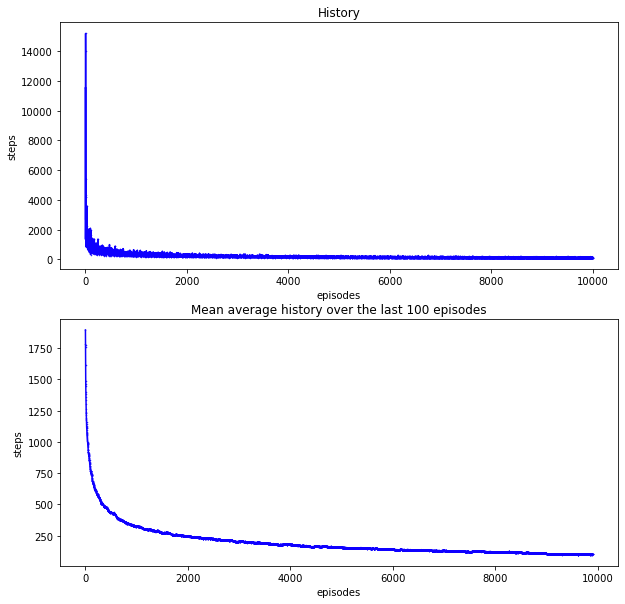

In [19]:
plot_history(history, 100)

***
<a name='11'></a>

In [22]:
X_train = []
Y_train = []
for state, prob in initial_policy.items():
    if prob[0]>1/3 or prob[1]>1/3 or prob[2]>1/3:
        X_train.append([state[0], state[1]])
        Y_train.append(prob)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [30]:
X_train.shape, Y_train.shape

((7143, 2), (7143, 3))

In [23]:
ql_policy = KNeighborsRegressor(n_neighbors=1)
ql_policy.fit(X_train, Y_train)

KNeighborsRegressor(n_neighbors=1)

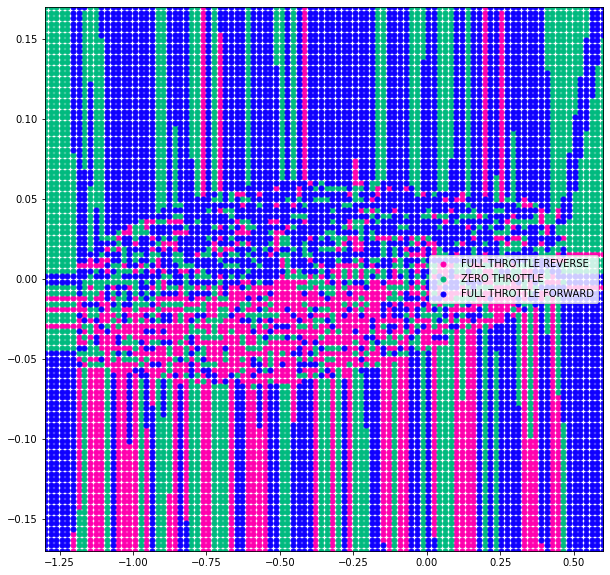

In [24]:
plot_policy_actions(ql_policy)

In [25]:
agent_info = {"discount": 1.,
              "policy": ql_policy}

montecarlo_evaluation = MonteCarloEvaluation()

In [101]:
num_episodes = 5000
max_steps_this_episode = 10000 

policy_evaluation = PolicyEvaluation(env=mountain_car, 
                                     agent=montecarlo_evaluation)

value_function, history = policy_evaluation.rl_run(env_info=env_info,
                                                   agent_info=agent_info,
                                                   num_episodes=num_episodes,
                                                   max_steps_this_episode=max_steps_this_episode)

Episode: 1/500 - Steps: 235
----- 0.438s -----
Episode: 2/500 - Steps: 166
----- 0.402s -----
Episode: 3/500 - Steps: 163
----- 0.404s -----
Episode: 4/500 - Steps: 244
----- 0.433s -----
Episode: 5/500 - Steps: 236
----- 0.427s -----
Episode: 6/500 - Steps: 194
----- 0.41s -----
Episode: 7/500 - Steps: 174
----- 0.407s -----
Episode: 8/500 - Steps: 182
----- 0.409s -----
Episode: 9/500 - Steps: 195
----- 0.414s -----
Episode: 10/500 - Steps: 199
----- 0.413s -----
Episode: 11/500 - Steps: 158
----- 0.403s -----
Episode: 12/500 - Steps: 158
----- 0.396s -----
Episode: 13/500 - Steps: 162
----- 0.402s -----
Episode: 14/500 - Steps: 163
----- 0.404s -----
Episode: 15/500 - Steps: 266
----- 0.443s -----
Episode: 16/500 - Steps: 168
----- 0.406s -----
Episode: 17/500 - Steps: 162
----- 0.401s -----
Episode: 18/500 - Steps: 185
----- 0.459s -----
Episode: 19/500 - Steps: 157
----- 0.406s -----
Episode: 20/500 - Steps: 164
----- 0.404s -----
Episode: 21/500 - Steps: 181
----- 0.412s -----
Ep

Episode: 171/500 - Steps: 238
----- 0.429s -----
Episode: 172/500 - Steps: 267
----- 0.444s -----
Episode: 173/500 - Steps: 186
----- 0.407s -----
Episode: 174/500 - Steps: 223
----- 0.422s -----
Episode: 175/500 - Steps: 246
----- 0.43s -----
Episode: 176/500 - Steps: 259
----- 0.442s -----
Episode: 177/500 - Steps: 161
----- 0.396s -----
Episode: 178/500 - Steps: 160
----- 0.395s -----
Episode: 179/500 - Steps: 159
----- 0.394s -----
Episode: 180/500 - Steps: 144
----- 0.38s -----
Episode: 181/500 - Steps: 243
----- 0.427s -----
Episode: 182/500 - Steps: 244
----- 0.427s -----
Episode: 183/500 - Steps: 182
----- 0.462s -----
Episode: 184/500 - Steps: 193
----- 0.412s -----
Episode: 185/500 - Steps: 160
----- 0.396s -----
Episode: 186/500 - Steps: 158
----- 0.395s -----
Episode: 187/500 - Steps: 198
----- 0.418s -----
Episode: 188/500 - Steps: 168
----- 0.403s -----
Episode: 189/500 - Steps: 165
----- 0.413s -----
Episode: 190/500 - Steps: 214
----- 0.426s -----
Episode: 191/500 - Ste

Episode: 339/500 - Steps: 180
----- 0.405s -----
Episode: 340/500 - Steps: 162
----- 0.396s -----
Episode: 341/500 - Steps: 165
----- 0.397s -----
Episode: 342/500 - Steps: 162
----- 0.401s -----
Episode: 343/500 - Steps: 217
----- 0.419s -----
Episode: 344/500 - Steps: 236
----- 0.425s -----
Episode: 345/500 - Steps: 245
----- 0.428s -----
Episode: 346/500 - Steps: 253
----- 0.432s -----
Episode: 347/500 - Steps: 160
----- 0.395s -----
Episode: 348/500 - Steps: 199
----- 0.412s -----
Episode: 349/500 - Steps: 173
----- 0.402s -----
Episode: 350/500 - Steps: 172
----- 0.403s -----
Episode: 351/500 - Steps: 177
----- 0.406s -----
Episode: 352/500 - Steps: 222
----- 0.419s -----
Episode: 353/500 - Steps: 261
----- 0.44s -----
Episode: 354/500 - Steps: 177
----- 0.404s -----
Episode: 355/500 - Steps: 256
----- 0.434s -----
Episode: 356/500 - Steps: 248
----- 0.43s -----
Episode: 357/500 - Steps: 193
----- 0.413s -----
Episode: 358/500 - Steps: 226
----- 0.427s -----
Episode: 359/500 - Ste

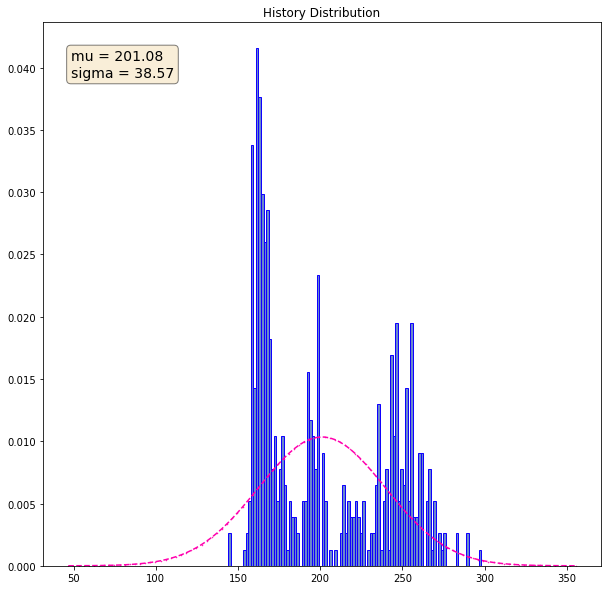

In [102]:
plot_history_histogram(history)

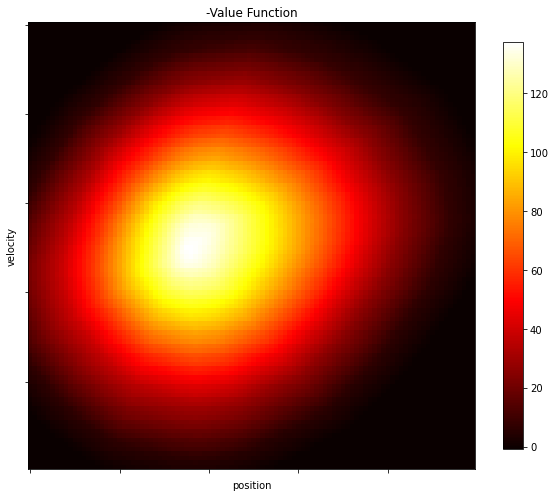

In [28]:
plot_valuefunction(value_function)

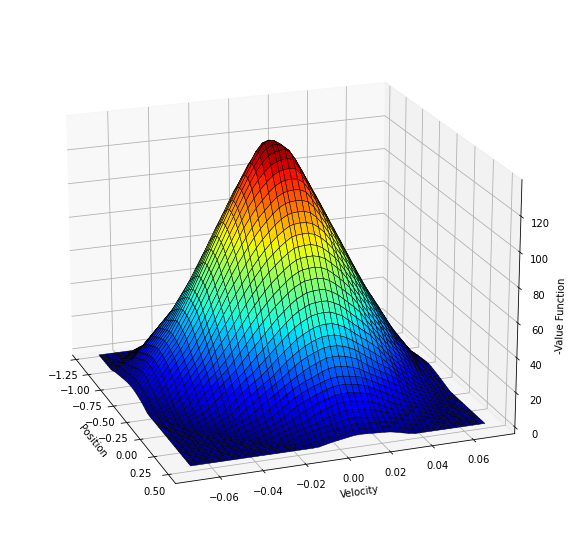

In [29]:
plot_valuefunction3d(value_function)

***
<a name='12'></a>

In [31]:
initial_policy = InitialPolicy()
initial_policy.fit(X_train, Y_train, epochs=10000)

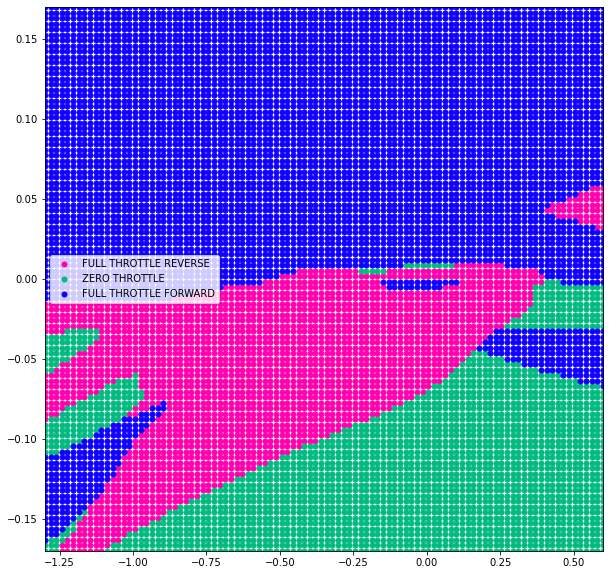

In [32]:
plot_policy_actions(initial_policy)

***
<a name='13'></a>

In [33]:
class MonteCarloControl(Agent):
    
    def agent_init(self, agent_info={}):
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        
        self.discount = agent_info.get("discount")
        self.epsilon = agent_info.get("epsilon")
        self.decay_factor = agent_info.get("decay_factor")
        
        self.initial_policy = agent_info.get("initial_policy")

        self.b = BFunction()        
        self.policy = Policy(self.initial_policy)
            
    def agent_start(self, state):
        self.episode_data = []
    
        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_step(self, reward, state):        
        self.episode_data.append((self.last_state, self.last_action, reward))
        
        action = self.agent_action(state)
        
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_end(self, reward):
        self.episode_data.append((self.last_state, self.last_action, reward))
        
        X_train = []
        Z_train = []
        Y_train = []
        
        g = 0
        for i in range(len(self.episode_data)-1, -1, -1):
            s, a, r = self.episode_data[i]
                        
            X_train.append([s[0], s[1]])
            
            g = r + self.discount*g
            Y_train.append([g])
            
            d = g - self.b.predict(np.array([[s[0], s[1]]]))

            one_hot = np.zeros((1,3))
            one_hot[0,a] = 1.
            d = d*one_hot
            
            Z_train.append(d.flatten())
            
        X_train = np.array(X_train)
        Z_train = np.array(Z_train)
        Y_train = np.array(Y_train)
        
        self.b.fit(X_train, Y_train, epochs=100)
        self.policy.fit(X_train, Z_train, dist_param=self.epsilon, epochs=100)
        
        self.agent_improvement()
                  
    def agent_cleanup(self):
        self.last_state = None
        self.last_action = None
                       
    def agent_action(self, state):
        s, t = state 
        p = self.policy.predict(np.array([[s,t]]))
        return self.rand_generator.choice(range(p.shape[1]), p=p.flatten())  
    
    def agent_improvement(self):
        self.epsilon = self.decay_factor*self.epsilon

***
<a name='14'></a>

In [34]:
agent_info = {"discount": 1.,
              "epsilon": 1.,
              "decay_factor": 0.999, 
              "initial_policy": initial_policy}

montecarlo_control = MonteCarloControl()

In [35]:
num_episodes = 500
max_steps_this_episode = 10000

policy_control = PolicyControl(env=mountain_car, 
                                   agent=montecarlo_control)

optimal_policy, history = policy_control.rl_run(env_info=env_info, 
                                                agent_info=agent_info,
                                                num_episodes=num_episodes, 
                                                max_steps_this_episode=max_steps_this_episode)

Episode: 1/500 - Steps: 4349 - Epsilon: 0.999
----- 2.803s -----
Episode: 2/500 - Steps: 10000 - Epsilon: 0.998001
----- 6.058s -----
Episode: 3/500 - Steps: 414 - Epsilon: 0.997002999
----- 0.839s -----
Episode: 4/500 - Steps: 314 - Epsilon: 0.996005996001
----- 0.784s -----
Episode: 5/500 - Steps: 325 - Epsilon: 0.995009990004999
----- 0.787s -----
Episode: 6/500 - Steps: 233 - Epsilon: 0.994014980014994
----- 0.755s -----
Episode: 7/500 - Steps: 251 - Epsilon: 0.993020965034979
----- 0.752s -----
Episode: 8/500 - Steps: 237 - Epsilon: 0.9920279440699441
----- 0.74s -----
Episode: 9/500 - Steps: 196 - Epsilon: 0.9910359161258742
----- 0.717s -----
Episode: 10/500 - Steps: 395 - Epsilon: 0.9900448802097482
----- 0.838s -----
Episode: 11/500 - Steps: 171 - Epsilon: 0.9890548353295385
----- 0.695s -----
Episode: 12/500 - Steps: 156 - Epsilon: 0.988065780494209
----- 0.748s -----
Episode: 13/500 - Steps: 286 - Epsilon: 0.9870777147137147
----- 0.799s -----
Episode: 14/500 - Steps: 241 - 

Episode: 107/500 - Steps: 161 - Epsilon: 0.8984775710829266
----- 0.688s -----
Episode: 108/500 - Steps: 160 - Epsilon: 0.8975790935118436
----- 0.697s -----
Episode: 109/500 - Steps: 256 - Epsilon: 0.8966815144183318
----- 0.742s -----
Episode: 110/500 - Steps: 195 - Epsilon: 0.8957848329039134
----- 0.72s -----
Episode: 111/500 - Steps: 236 - Epsilon: 0.8948890480710096
----- 0.736s -----
Episode: 112/500 - Steps: 234 - Epsilon: 0.8939941590229386
----- 0.735s -----
Episode: 113/500 - Steps: 242 - Epsilon: 0.8931001648639156
----- 0.739s -----
Episode: 114/500 - Steps: 170 - Epsilon: 0.8922070646990518
----- 0.691s -----
Episode: 115/500 - Steps: 230 - Epsilon: 0.8913148576343527
----- 0.728s -----
Episode: 116/500 - Steps: 243 - Epsilon: 0.8904235427767183
----- 0.74s -----
Episode: 117/500 - Steps: 160 - Epsilon: 0.8895331192339416
----- 0.69s -----
Episode: 118/500 - Steps: 199 - Epsilon: 0.8886435861147077
----- 0.722s -----
Episode: 119/500 - Steps: 197 - Epsilon: 0.887754942528

Episode: 212/500 - Steps: 259 - Epsilon: 0.8088788946494789
----- 0.752s -----
Episode: 213/500 - Steps: 249 - Epsilon: 0.8080700157548294
----- 0.744s -----
Episode: 214/500 - Steps: 196 - Epsilon: 0.8072619457390746
----- 0.711s -----
Episode: 215/500 - Steps: 156 - Epsilon: 0.8064546837933355
----- 0.709s -----
Episode: 216/500 - Steps: 161 - Epsilon: 0.8056482291095421
----- 0.686s -----
Episode: 217/500 - Steps: 164 - Epsilon: 0.8048425808804326
----- 0.681s -----
Episode: 218/500 - Steps: 191 - Epsilon: 0.8040377382995522
----- 0.712s -----
Episode: 219/500 - Steps: 162 - Epsilon: 0.8032337005612527
----- 0.684s -----
Episode: 220/500 - Steps: 236 - Epsilon: 0.8024304668606914
----- 0.739s -----
Episode: 221/500 - Steps: 227 - Epsilon: 0.8016280363938307
----- 0.727s -----
Episode: 222/500 - Steps: 205 - Epsilon: 0.8008264083574369
----- 0.722s -----
Episode: 223/500 - Steps: 257 - Epsilon: 0.8000255819490795
----- 0.746s -----
Episode: 224/500 - Steps: 206 - Epsilon: 0.799225556

Episode: 316/500 - Steps: 199 - Epsilon: 0.7289441910343799
----- 0.719s -----
Episode: 317/500 - Steps: 161 - Epsilon: 0.7282152468433455
----- 0.709s -----
Episode: 318/500 - Steps: 205 - Epsilon: 0.7274870315965022
----- 0.725s -----
Episode: 319/500 - Steps: 190 - Epsilon: 0.7267595445649057
----- 0.702s -----
Episode: 320/500 - Steps: 219 - Epsilon: 0.7260327850203407
----- 0.728s -----
Episode: 321/500 - Steps: 196 - Epsilon: 0.7253067522353204
----- 0.713s -----
Episode: 322/500 - Steps: 232 - Epsilon: 0.724581445483085
----- 0.73s -----
Episode: 323/500 - Steps: 161 - Epsilon: 0.723856864037602
----- 0.714s -----
Episode: 324/500 - Steps: 168 - Epsilon: 0.7231330071735643
----- 0.695s -----
Episode: 325/500 - Steps: 200 - Epsilon: 0.7224098741663908
----- 0.713s -----
Episode: 326/500 - Steps: 189 - Epsilon: 0.7216874642922244
----- 0.706s -----
Episode: 327/500 - Steps: 256 - Epsilon: 0.7209657768279322
----- 0.745s -----
Episode: 328/500 - Steps: 246 - Epsilon: 0.720244811051

Episode: 421/500 - Steps: 241 - Epsilon: 0.6562518536710664
----- 0.735s -----
Episode: 422/500 - Steps: 249 - Epsilon: 0.6555956018173954
----- 0.742s -----
Episode: 423/500 - Steps: 181 - Epsilon: 0.654940006215578
----- 0.696s -----
Episode: 424/500 - Steps: 161 - Epsilon: 0.6542850662093624
----- 0.678s -----
Episode: 425/500 - Steps: 319 - Epsilon: 0.6536307811431531
----- 0.769s -----
Episode: 426/500 - Steps: 163 - Epsilon: 0.65297715036201
----- 0.685s -----
Episode: 427/500 - Steps: 254 - Epsilon: 0.6523241732116479
----- 0.738s -----
Episode: 428/500 - Steps: 173 - Epsilon: 0.6516718490384363
----- 0.773s -----
Episode: 429/500 - Steps: 156 - Epsilon: 0.6510201771893979
----- 0.689s -----
Episode: 430/500 - Steps: 158 - Epsilon: 0.6503691570122084
----- 0.677s -----
Episode: 431/500 - Steps: 236 - Epsilon: 0.6497187878551962
----- 0.726s -----
Episode: 432/500 - Steps: 228 - Epsilon: 0.649069069067341
----- 0.726s -----
Episode: 433/500 - Steps: 171 - Epsilon: 0.6484199999982

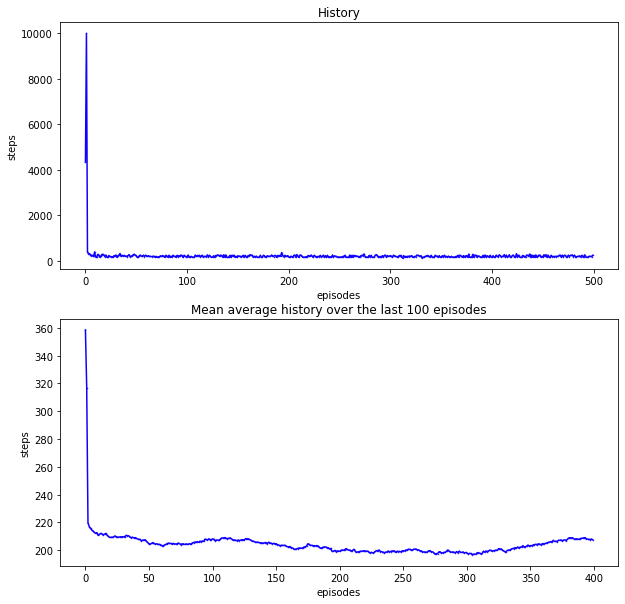

In [36]:
plot_history(history, 100)

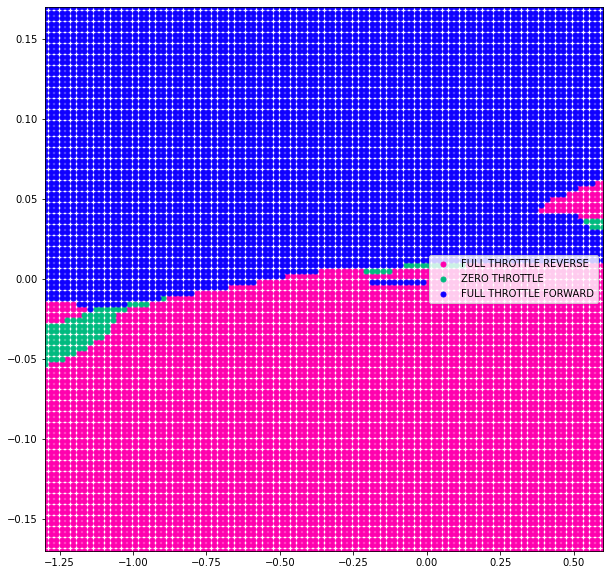

In [37]:
plot_policy_actions(optimal_policy)

***
<a name='15'></a>

In [34]:
class DeterministicPolicy():
    
    def __init__(self, optimal_policy):
        self.optimal_policy = optimal_policy
                
    def predict(self, inputs):
        I = np.array([[1., 0., 0.],
                      [0., 1. ,0.],
                      [0., 0., 1.]])
        w = np.argmax(self.optimal_policy.predict(inputs), axis=1).reshape((-1,1))
        return I[w].reshape((-1,3))

In [35]:
deterministic_policy = DeterministicPolicy(optimal_policy)

In [37]:
plot_animation(deterministic_policy, 'optimal_policy.gif')

***
<a name='16'></a>

In [39]:
agent_info = {"discount": 1.,
              "policy": deterministic_policy} 

montecarlo_evaluation = MonteCarloEvaluation()

In [40]:
num_episodes = 5000
max_steps_this_episode = 10000 

policy_evaluation = PolicyEvaluation(env=mountain_car, 
                                     agent=montecarlo_evaluation)

value_function, history = policy_evaluation.rl_run(env_info=env_info,
                                                   agent_info=agent_info,
                                                   num_episodes=num_episodes,
                                                   max_steps_this_episode=max_steps_this_episode)

Episode: 1/5000 - Steps: 89
----- 0.402s -----
Episode: 2/5000 - Steps: 151
----- 0.391s -----
Episode: 3/5000 - Steps: 149
----- 0.39s -----
Episode: 4/5000 - Steps: 151
----- 0.405s -----
Episode: 5/5000 - Steps: 88
----- 0.363s -----
Episode: 6/5000 - Steps: 113
----- 0.372s -----
Episode: 7/5000 - Steps: 113
----- 0.376s -----
Episode: 8/5000 - Steps: 113
----- 0.381s -----
Episode: 9/5000 - Steps: 89
----- 0.365s -----
Episode: 10/5000 - Steps: 148
----- 0.393s -----
Episode: 11/5000 - Steps: 153
----- 0.406s -----
Episode: 12/5000 - Steps: 112
----- 0.374s -----
Episode: 13/5000 - Steps: 89
----- 0.364s -----
Episode: 14/5000 - Steps: 148
----- 0.393s -----
Episode: 15/5000 - Steps: 98
----- 0.366s -----
Episode: 16/5000 - Steps: 114
----- 0.377s -----
Episode: 17/5000 - Steps: 112
----- 0.371s -----
Episode: 18/5000 - Steps: 95
----- 0.372s -----
Episode: 19/5000 - Steps: 112
----- 0.439s -----
Episode: 20/5000 - Steps: 159
----- 0.404s -----
Episode: 21/5000 - Steps: 87
----- 0

Episode: 169/5000 - Steps: 158
----- 0.418s -----
Episode: 170/5000 - Steps: 114
----- 0.372s -----
Episode: 171/5000 - Steps: 152
----- 0.399s -----
Episode: 172/5000 - Steps: 156
----- 0.423s -----
Episode: 173/5000 - Steps: 83
----- 0.374s -----
Episode: 174/5000 - Steps: 87
----- 0.391s -----
Episode: 175/5000 - Steps: 144
----- 0.396s -----
Episode: 176/5000 - Steps: 114
----- 0.383s -----
Episode: 177/5000 - Steps: 113
----- 0.374s -----
Episode: 178/5000 - Steps: 152
----- 0.399s -----
Episode: 179/5000 - Steps: 113
----- 0.418s -----
Episode: 180/5000 - Steps: 113
----- 0.376s -----
Episode: 181/5000 - Steps: 145
----- 0.386s -----
Episode: 182/5000 - Steps: 84
----- 0.361s -----
Episode: 183/5000 - Steps: 158
----- 0.402s -----
Episode: 184/5000 - Steps: 163
----- 0.428s -----
Episode: 185/5000 - Steps: 147
----- 0.401s -----
Episode: 186/5000 - Steps: 156
----- 0.412s -----
Episode: 187/5000 - Steps: 112
----- 0.369s -----
Episode: 188/5000 - Steps: 147
----- 0.399s -----
Epi

Episode: 335/5000 - Steps: 86
----- 0.368s -----
Episode: 336/5000 - Steps: 158
----- 0.403s -----
Episode: 337/5000 - Steps: 161
----- 0.402s -----
Episode: 338/5000 - Steps: 112
----- 0.369s -----
Episode: 339/5000 - Steps: 147
----- 0.386s -----
Episode: 340/5000 - Steps: 144
----- 0.385s -----
Episode: 341/5000 - Steps: 148
----- 0.386s -----
Episode: 342/5000 - Steps: 114
----- 0.372s -----
Episode: 343/5000 - Steps: 113
----- 0.373s -----
Episode: 344/5000 - Steps: 156
----- 0.416s -----
Episode: 345/5000 - Steps: 114
----- 0.457s -----
Episode: 346/5000 - Steps: 146
----- 0.391s -----
Episode: 347/5000 - Steps: 161
----- 0.404s -----
Episode: 348/5000 - Steps: 112
----- 0.374s -----
Episode: 349/5000 - Steps: 112
----- 0.368s -----
Episode: 350/5000 - Steps: 85
----- 0.36s -----
Episode: 351/5000 - Steps: 112
----- 0.371s -----
Episode: 352/5000 - Steps: 148
----- 0.39s -----
Episode: 353/5000 - Steps: 112
----- 0.369s -----
Episode: 354/5000 - Steps: 86
----- 0.361s -----
Episo

Episode: 501/5000 - Steps: 114
----- 0.403s -----
Episode: 502/5000 - Steps: 112
----- 0.38s -----
Episode: 503/5000 - Steps: 150
----- 0.403s -----
Episode: 504/5000 - Steps: 90
----- 0.386s -----
Episode: 505/5000 - Steps: 163
----- 0.407s -----
Episode: 506/5000 - Steps: 86
----- 0.362s -----
Episode: 507/5000 - Steps: 145
----- 0.392s -----
Episode: 508/5000 - Steps: 112
----- 0.369s -----
Episode: 509/5000 - Steps: 114
----- 0.396s -----
Episode: 510/5000 - Steps: 152
----- 0.401s -----
Episode: 511/5000 - Steps: 112
----- 0.369s -----
Episode: 512/5000 - Steps: 89
----- 0.365s -----
Episode: 513/5000 - Steps: 114
----- 0.387s -----
Episode: 514/5000 - Steps: 88
----- 0.36s -----
Episode: 515/5000 - Steps: 163
----- 0.403s -----
Episode: 516/5000 - Steps: 83
----- 0.375s -----
Episode: 517/5000 - Steps: 151
----- 0.39s -----
Episode: 518/5000 - Steps: 94
----- 0.368s -----
Episode: 519/5000 - Steps: 159
----- 0.402s -----
Episode: 520/5000 - Steps: 91
----- 0.364s -----
Episode: 5

Episode: 667/5000 - Steps: 112
----- 0.409s -----
Episode: 668/5000 - Steps: 112
----- 0.375s -----
Episode: 669/5000 - Steps: 113
----- 0.389s -----
Episode: 670/5000 - Steps: 89
----- 0.37s -----
Episode: 671/5000 - Steps: 145
----- 0.42s -----
Episode: 672/5000 - Steps: 145
----- 0.387s -----
Episode: 673/5000 - Steps: 94
----- 0.401s -----
Episode: 674/5000 - Steps: 152
----- 0.425s -----
Episode: 675/5000 - Steps: 85
----- 0.373s -----
Episode: 676/5000 - Steps: 148
----- 0.415s -----
Episode: 677/5000 - Steps: 112
----- 0.464s -----
Episode: 678/5000 - Steps: 147
----- 0.409s -----
Episode: 679/5000 - Steps: 144
----- 0.39s -----
Episode: 680/5000 - Steps: 86
----- 0.371s -----
Episode: 681/5000 - Steps: 84
----- 0.376s -----
Episode: 682/5000 - Steps: 147
----- 0.524s -----
Episode: 683/5000 - Steps: 112
----- 0.399s -----
Episode: 684/5000 - Steps: 87
----- 0.373s -----
Episode: 685/5000 - Steps: 153
----- 0.416s -----
Episode: 686/5000 - Steps: 144
----- 0.396s -----
Episode: 

Episode: 833/5000 - Steps: 95
----- 0.364s -----
Episode: 834/5000 - Steps: 149
----- 0.386s -----
Episode: 835/5000 - Steps: 112
----- 0.369s -----
Episode: 836/5000 - Steps: 114
----- 0.371s -----
Episode: 837/5000 - Steps: 114
----- 0.37s -----
Episode: 838/5000 - Steps: 113
----- 0.37s -----
Episode: 839/5000 - Steps: 145
----- 0.385s -----
Episode: 840/5000 - Steps: 112
----- 0.521s -----
Episode: 841/5000 - Steps: 83
----- 0.374s -----
Episode: 842/5000 - Steps: 113
----- 0.371s -----
Episode: 843/5000 - Steps: 145
----- 0.385s -----
Episode: 844/5000 - Steps: 88
----- 0.36s -----
Episode: 845/5000 - Steps: 113
----- 0.378s -----
Episode: 846/5000 - Steps: 90
----- 0.364s -----
Episode: 847/5000 - Steps: 112
----- 0.368s -----
Episode: 848/5000 - Steps: 145
----- 0.385s -----
Episode: 849/5000 - Steps: 112
----- 0.368s -----
Episode: 850/5000 - Steps: 152
----- 0.398s -----
Episode: 851/5000 - Steps: 83
----- 0.36s -----
Episode: 852/5000 - Steps: 144
----- 0.385s -----
Episode: 

Episode: 999/5000 - Steps: 90
----- 0.364s -----
Episode: 1000/5000 - Steps: 112
----- 0.368s -----
Episode: 1001/5000 - Steps: 114
----- 0.37s -----
Episode: 1002/5000 - Steps: 114
----- 0.37s -----
Episode: 1003/5000 - Steps: 114
----- 0.371s -----
Episode: 1004/5000 - Steps: 114
----- 0.376s -----
Episode: 1005/5000 - Steps: 94
----- 0.363s -----
Episode: 1006/5000 - Steps: 114
----- 0.376s -----
Episode: 1007/5000 - Steps: 150
----- 0.386s -----
Episode: 1008/5000 - Steps: 114
----- 0.371s -----
Episode: 1009/5000 - Steps: 146
----- 0.385s -----
Episode: 1010/5000 - Steps: 149
----- 0.387s -----
Episode: 1011/5000 - Steps: 112
----- 0.368s -----
Episode: 1012/5000 - Steps: 84
----- 0.36s -----
Episode: 1013/5000 - Steps: 112
----- 0.369s -----
Episode: 1014/5000 - Steps: 113
----- 0.369s -----
Episode: 1015/5000 - Steps: 144
----- 0.393s -----
Episode: 1016/5000 - Steps: 146
----- 0.387s -----
Episode: 1017/5000 - Steps: 112
----- 0.368s -----
Episode: 1018/5000 - Steps: 112
----- 

Episode: 1162/5000 - Steps: 114
----- 0.371s -----
Episode: 1163/5000 - Steps: 161
----- 0.402s -----
Episode: 1164/5000 - Steps: 87
----- 0.361s -----
Episode: 1165/5000 - Steps: 113
----- 0.371s -----
Episode: 1166/5000 - Steps: 112
----- 0.368s -----
Episode: 1167/5000 - Steps: 145
----- 0.385s -----
Episode: 1168/5000 - Steps: 146
----- 0.385s -----
Episode: 1169/5000 - Steps: 112
----- 0.371s -----
Episode: 1170/5000 - Steps: 156
----- 0.399s -----
Episode: 1171/5000 - Steps: 144
----- 0.385s -----
Episode: 1172/5000 - Steps: 86
----- 0.359s -----
Episode: 1173/5000 - Steps: 85
----- 0.36s -----
Episode: 1174/5000 - Steps: 147
----- 0.386s -----
Episode: 1175/5000 - Steps: 144
----- 0.44s -----
Episode: 1176/5000 - Steps: 145
----- 0.404s -----
Episode: 1177/5000 - Steps: 113
----- 0.37s -----
Episode: 1178/5000 - Steps: 113
----- 0.37s -----
Episode: 1179/5000 - Steps: 97
----- 0.363s -----
Episode: 1180/5000 - Steps: 144
----- 0.384s -----
Episode: 1181/5000 - Steps: 149
----- 0

Episode: 1325/5000 - Steps: 86
----- 0.358s -----
Episode: 1326/5000 - Steps: 91
----- 0.366s -----
Episode: 1327/5000 - Steps: 113
----- 0.37s -----
Episode: 1328/5000 - Steps: 114
----- 0.37s -----
Episode: 1329/5000 - Steps: 147
----- 0.386s -----
Episode: 1330/5000 - Steps: 94
----- 0.363s -----
Episode: 1331/5000 - Steps: 112
----- 0.367s -----
Episode: 1332/5000 - Steps: 150
----- 0.387s -----
Episode: 1333/5000 - Steps: 161
----- 0.407s -----
Episode: 1334/5000 - Steps: 157
----- 0.409s -----
Episode: 1335/5000 - Steps: 112
----- 0.368s -----
Episode: 1336/5000 - Steps: 112
----- 0.368s -----
Episode: 1337/5000 - Steps: 112
----- 0.368s -----
Episode: 1338/5000 - Steps: 92
----- 0.361s -----
Episode: 1339/5000 - Steps: 113
----- 0.37s -----
Episode: 1340/5000 - Steps: 113
----- 0.369s -----
Episode: 1341/5000 - Steps: 112
----- 0.381s -----
Episode: 1342/5000 - Steps: 152
----- 0.398s -----
Episode: 1343/5000 - Steps: 158
----- 0.399s -----
Episode: 1344/5000 - Steps: 151
----- 

Episode: 1488/5000 - Steps: 112
----- 0.367s -----
Episode: 1489/5000 - Steps: 152
----- 0.397s -----
Episode: 1490/5000 - Steps: 112
----- 0.367s -----
Episode: 1491/5000 - Steps: 91
----- 0.363s -----
Episode: 1492/5000 - Steps: 112
----- 0.368s -----
Episode: 1493/5000 - Steps: 85
----- 0.426s -----
Episode: 1494/5000 - Steps: 86
----- 0.375s -----
Episode: 1495/5000 - Steps: 167
----- 0.409s -----
Episode: 1496/5000 - Steps: 113
----- 0.369s -----
Episode: 1497/5000 - Steps: 114
----- 0.37s -----
Episode: 1498/5000 - Steps: 112
----- 0.367s -----
Episode: 1499/5000 - Steps: 97
----- 0.364s -----
Episode: 1500/5000 - Steps: 112
----- 0.381s -----
Episode: 1501/5000 - Steps: 145
----- 0.385s -----
Episode: 1502/5000 - Steps: 112
----- 0.395s -----
Episode: 1503/5000 - Steps: 112
----- 0.375s -----
Episode: 1504/5000 - Steps: 113
----- 0.405s -----
Episode: 1505/5000 - Steps: 113
----- 0.37s -----
Episode: 1506/5000 - Steps: 156
----- 0.411s -----
Episode: 1507/5000 - Steps: 150
-----

Episode: 1651/5000 - Steps: 150
----- 0.388s -----
Episode: 1652/5000 - Steps: 96
----- 0.371s -----
Episode: 1653/5000 - Steps: 89
----- 0.36s -----
Episode: 1654/5000 - Steps: 88
----- 0.358s -----
Episode: 1655/5000 - Steps: 147
----- 0.406s -----
Episode: 1656/5000 - Steps: 114
----- 0.388s -----
Episode: 1657/5000 - Steps: 144
----- 0.413s -----
Episode: 1658/5000 - Steps: 84
----- 0.387s -----
Episode: 1659/5000 - Steps: 84
----- 0.377s -----
Episode: 1660/5000 - Steps: 112
----- 0.383s -----
Episode: 1661/5000 - Steps: 149
----- 0.407s -----
Episode: 1662/5000 - Steps: 145
----- 0.408s -----
Episode: 1663/5000 - Steps: 144
----- 0.411s -----
Episode: 1664/5000 - Steps: 112
----- 0.393s -----
Episode: 1665/5000 - Steps: 112
----- 0.383s -----
Episode: 1666/5000 - Steps: 114
----- 0.388s -----
Episode: 1667/5000 - Steps: 112
----- 0.375s -----
Episode: 1668/5000 - Steps: 92
----- 0.363s -----
Episode: 1669/5000 - Steps: 112
----- 0.368s -----
Episode: 1670/5000 - Steps: 144
----- 

Episode: 1813/5000 - Steps: 112
----- 0.368s -----
Episode: 1814/5000 - Steps: 84
----- 0.36s -----
Episode: 1815/5000 - Steps: 83
----- 0.36s -----
Episode: 1816/5000 - Steps: 152
----- 0.408s -----
Episode: 1817/5000 - Steps: 114
----- 0.371s -----
Episode: 1818/5000 - Steps: 112
----- 0.376s -----
Episode: 1819/5000 - Steps: 112
----- 0.368s -----
Episode: 1820/5000 - Steps: 113
----- 0.37s -----
Episode: 1821/5000 - Steps: 86
----- 0.359s -----
Episode: 1822/5000 - Steps: 88
----- 0.36s -----
Episode: 1823/5000 - Steps: 113
----- 0.401s -----
Episode: 1824/5000 - Steps: 114
----- 0.371s -----
Episode: 1825/5000 - Steps: 113
----- 0.37s -----
Episode: 1826/5000 - Steps: 91
----- 0.363s -----
Episode: 1827/5000 - Steps: 88
----- 0.359s -----
Episode: 1828/5000 - Steps: 86
----- 0.374s -----
Episode: 1829/5000 - Steps: 145
----- 0.386s -----
Episode: 1830/5000 - Steps: 149
----- 0.386s -----
Episode: 1831/5000 - Steps: 95
----- 0.364s -----
Episode: 1832/5000 - Steps: 98
----- 0.364s 

Episode: 1976/5000 - Steps: 144
----- 0.385s -----
Episode: 1977/5000 - Steps: 86
----- 0.366s -----
Episode: 1978/5000 - Steps: 86
----- 0.364s -----
Episode: 1979/5000 - Steps: 168
----- 0.409s -----
Episode: 1980/5000 - Steps: 91
----- 0.365s -----
Episode: 1981/5000 - Steps: 144
----- 0.386s -----
Episode: 1982/5000 - Steps: 114
----- 0.371s -----
Episode: 1983/5000 - Steps: 114
----- 0.371s -----
Episode: 1984/5000 - Steps: 112
----- 0.368s -----
Episode: 1985/5000 - Steps: 149
----- 0.386s -----
Episode: 1986/5000 - Steps: 86
----- 0.414s -----
Episode: 1987/5000 - Steps: 148
----- 0.389s -----
Episode: 1988/5000 - Steps: 158
----- 0.405s -----
Episode: 1989/5000 - Steps: 113
----- 0.371s -----
Episode: 1990/5000 - Steps: 112
----- 0.367s -----
Episode: 1991/5000 - Steps: 97
----- 0.363s -----
Episode: 1992/5000 - Steps: 89
----- 0.361s -----
Episode: 1993/5000 - Steps: 87
----- 0.361s -----
Episode: 1994/5000 - Steps: 157
----- 0.4s -----
Episode: 1995/5000 - Steps: 148
----- 0.

Episode: 2139/5000 - Steps: 114
----- 0.37s -----
Episode: 2140/5000 - Steps: 147
----- 0.39s -----
Episode: 2141/5000 - Steps: 86
----- 0.364s -----
Episode: 2142/5000 - Steps: 84
----- 0.359s -----
Episode: 2143/5000 - Steps: 113
----- 0.373s -----
Episode: 2144/5000 - Steps: 95
----- 0.363s -----
Episode: 2145/5000 - Steps: 113
----- 0.384s -----
Episode: 2146/5000 - Steps: 93
----- 0.389s -----
Episode: 2147/5000 - Steps: 150
----- 0.387s -----
Episode: 2148/5000 - Steps: 114
----- 0.371s -----
Episode: 2149/5000 - Steps: 113
----- 0.37s -----
Episode: 2150/5000 - Steps: 85
----- 0.358s -----
Episode: 2151/5000 - Steps: 148
----- 0.386s -----
Episode: 2152/5000 - Steps: 148
----- 0.385s -----
Episode: 2153/5000 - Steps: 93
----- 0.363s -----
Episode: 2154/5000 - Steps: 84
----- 0.36s -----
Episode: 2155/5000 - Steps: 86
----- 0.358s -----
Episode: 2156/5000 - Steps: 86
----- 0.358s -----
Episode: 2157/5000 - Steps: 168
----- 0.408s -----
Episode: 2158/5000 - Steps: 84
----- 0.365s 

Episode: 2302/5000 - Steps: 113
----- 0.37s -----
Episode: 2303/5000 - Steps: 83
----- 0.359s -----
Episode: 2304/5000 - Steps: 152
----- 0.412s -----
Episode: 2305/5000 - Steps: 114
----- 0.371s -----
Episode: 2306/5000 - Steps: 113
----- 0.369s -----
Episode: 2307/5000 - Steps: 90
----- 0.361s -----
Episode: 2308/5000 - Steps: 90
----- 0.361s -----
Episode: 2309/5000 - Steps: 150
----- 0.387s -----
Episode: 2310/5000 - Steps: 148
----- 0.39s -----
Episode: 2311/5000 - Steps: 90
----- 0.394s -----
Episode: 2312/5000 - Steps: 114
----- 0.396s -----
Episode: 2313/5000 - Steps: 90
----- 0.362s -----
Episode: 2314/5000 - Steps: 85
----- 0.365s -----
Episode: 2315/5000 - Steps: 112
----- 0.372s -----
Episode: 2316/5000 - Steps: 90
----- 0.37s -----
Episode: 2317/5000 - Steps: 112
----- 0.368s -----
Episode: 2318/5000 - Steps: 147
----- 0.386s -----
Episode: 2319/5000 - Steps: 89
----- 0.361s -----
Episode: 2320/5000 - Steps: 148
----- 0.386s -----
Episode: 2321/5000 - Steps: 113
----- 0.37

Episode: 2464/5000 - Steps: 145
----- 0.383s -----
Episode: 2465/5000 - Steps: 87
----- 0.358s -----
Episode: 2466/5000 - Steps: 114
----- 0.368s -----
Episode: 2467/5000 - Steps: 147
----- 0.384s -----
Episode: 2468/5000 - Steps: 84
----- 0.357s -----
Episode: 2469/5000 - Steps: 114
----- 0.368s -----
Episode: 2470/5000 - Steps: 114
----- 0.382s -----
Episode: 2471/5000 - Steps: 83
----- 0.367s -----
Episode: 2472/5000 - Steps: 148
----- 0.385s -----
Episode: 2473/5000 - Steps: 84
----- 0.358s -----
Episode: 2474/5000 - Steps: 149
----- 0.385s -----
Episode: 2475/5000 - Steps: 113
----- 0.368s -----
Episode: 2476/5000 - Steps: 112
----- 0.366s -----
Episode: 2477/5000 - Steps: 161
----- 0.399s -----
Episode: 2478/5000 - Steps: 147
----- 0.384s -----
Episode: 2479/5000 - Steps: 160
----- 0.398s -----
Episode: 2480/5000 - Steps: 145
----- 0.461s -----
Episode: 2481/5000 - Steps: 94
----- 0.368s -----
Episode: 2482/5000 - Steps: 160
----- 0.398s -----
Episode: 2483/5000 - Steps: 113
----

Episode: 2626/5000 - Steps: 84
----- 0.357s -----
Episode: 2627/5000 - Steps: 112
----- 0.364s -----
Episode: 2628/5000 - Steps: 112
----- 0.364s -----
Episode: 2629/5000 - Steps: 84
----- 0.357s -----
Episode: 2630/5000 - Steps: 112
----- 0.37s -----
Episode: 2631/5000 - Steps: 113
----- 0.366s -----
Episode: 2632/5000 - Steps: 144
----- 0.39s -----
Episode: 2633/5000 - Steps: 144
----- 0.397s -----
Episode: 2634/5000 - Steps: 87
----- 0.363s -----
Episode: 2635/5000 - Steps: 85
----- 0.362s -----
Episode: 2636/5000 - Steps: 113
----- 0.367s -----
Episode: 2637/5000 - Steps: 158
----- 0.396s -----
Episode: 2638/5000 - Steps: 113
----- 0.367s -----
Episode: 2639/5000 - Steps: 151
----- 0.385s -----
Episode: 2640/5000 - Steps: 93
----- 0.361s -----
Episode: 2641/5000 - Steps: 112
----- 0.365s -----
Episode: 2642/5000 - Steps: 148
----- 0.385s -----
Episode: 2643/5000 - Steps: 112
----- 0.364s -----
Episode: 2644/5000 - Steps: 112
----- 0.365s -----
Episode: 2645/5000 - Steps: 114
----- 

Episode: 2788/5000 - Steps: 150
----- 0.383s -----
Episode: 2789/5000 - Steps: 148
----- 0.383s -----
Episode: 2790/5000 - Steps: 165
----- 0.4s -----
Episode: 2791/5000 - Steps: 113
----- 0.368s -----
Episode: 2792/5000 - Steps: 160
----- 0.398s -----
Episode: 2793/5000 - Steps: 84
----- 0.357s -----
Episode: 2794/5000 - Steps: 97
----- 0.361s -----
Episode: 2795/5000 - Steps: 112
----- 0.365s -----
Episode: 2796/5000 - Steps: 84
----- 0.357s -----
Episode: 2797/5000 - Steps: 165
----- 0.4s -----
Episode: 2798/5000 - Steps: 91
----- 0.359s -----
Episode: 2799/5000 - Steps: 112
----- 0.378s -----
Episode: 2800/5000 - Steps: 114
----- 0.37s -----
Episode: 2801/5000 - Steps: 94
----- 0.363s -----
Episode: 2802/5000 - Steps: 89
----- 0.357s -----
Episode: 2803/5000 - Steps: 112
----- 0.365s -----
Episode: 2804/5000 - Steps: 83
----- 0.357s -----
Episode: 2805/5000 - Steps: 84
----- 0.358s -----
Episode: 2806/5000 - Steps: 112
----- 0.365s -----
Episode: 2807/5000 - Steps: 84
----- 0.357s 

Episode: 2950/5000 - Steps: 90
----- 0.359s -----
Episode: 2951/5000 - Steps: 89
----- 0.357s -----
Episode: 2952/5000 - Steps: 88
----- 0.377s -----
Episode: 2953/5000 - Steps: 112
----- 0.375s -----
Episode: 2954/5000 - Steps: 148
----- 0.389s -----
Episode: 2955/5000 - Steps: 113
----- 0.367s -----
Episode: 2956/5000 - Steps: 88
----- 0.355s -----
Episode: 2957/5000 - Steps: 144
----- 0.383s -----
Episode: 2958/5000 - Steps: 91
----- 0.36s -----
Episode: 2959/5000 - Steps: 114
----- 0.368s -----
Episode: 2960/5000 - Steps: 114
----- 0.37s -----
Episode: 2961/5000 - Steps: 113
----- 0.369s -----
Episode: 2962/5000 - Steps: 144
----- 0.382s -----
Episode: 2963/5000 - Steps: 112
----- 0.365s -----
Episode: 2964/5000 - Steps: 112
----- 0.365s -----
Episode: 2965/5000 - Steps: 145
----- 0.383s -----
Episode: 2966/5000 - Steps: 112
----- 0.366s -----
Episode: 2967/5000 - Steps: 112
----- 0.365s -----
Episode: 2968/5000 - Steps: 112
----- 0.365s -----
Episode: 2969/5000 - Steps: 148
----- 

Episode: 3112/5000 - Steps: 112
----- 0.365s -----
Episode: 3113/5000 - Steps: 112
----- 0.366s -----
Episode: 3114/5000 - Steps: 113
----- 0.367s -----
Episode: 3115/5000 - Steps: 149
----- 0.383s -----
Episode: 3116/5000 - Steps: 151
----- 0.385s -----
Episode: 3117/5000 - Steps: 84
----- 0.358s -----
Episode: 3118/5000 - Steps: 147
----- 0.382s -----
Episode: 3119/5000 - Steps: 112
----- 0.365s -----
Episode: 3120/5000 - Steps: 114
----- 0.462s -----
Episode: 3121/5000 - Steps: 147
----- 0.521s -----
Episode: 3122/5000 - Steps: 94
----- 0.421s -----
Episode: 3123/5000 - Steps: 112
----- 0.368s -----
Episode: 3124/5000 - Steps: 152
----- 0.55s -----
Episode: 3125/5000 - Steps: 85
----- 0.506s -----
Episode: 3126/5000 - Steps: 86
----- 0.39s -----
Episode: 3127/5000 - Steps: 144
----- 0.411s -----
Episode: 3128/5000 - Steps: 144
----- 0.421s -----
Episode: 3129/5000 - Steps: 114
----- 0.401s -----
Episode: 3130/5000 - Steps: 148
----- 0.415s -----
Episode: 3131/5000 - Steps: 88
----- 

Episode: 3274/5000 - Steps: 112
----- 0.375s -----
Episode: 3275/5000 - Steps: 112
----- 0.374s -----
Episode: 3276/5000 - Steps: 159
----- 0.403s -----
Episode: 3277/5000 - Steps: 150
----- 0.404s -----
Episode: 3278/5000 - Steps: 88
----- 0.4s -----
Episode: 3279/5000 - Steps: 114
----- 0.46s -----
Episode: 3280/5000 - Steps: 113
----- 0.379s -----
Episode: 3281/5000 - Steps: 112
----- 0.374s -----
Episode: 3282/5000 - Steps: 145
----- 0.42s -----
Episode: 3283/5000 - Steps: 153
----- 0.482s -----
Episode: 3284/5000 - Steps: 158
----- 0.494s -----
Episode: 3285/5000 - Steps: 156
----- 0.468s -----
Episode: 3286/5000 - Steps: 90
----- 0.39s -----
Episode: 3287/5000 - Steps: 90
----- 0.382s -----
Episode: 3288/5000 - Steps: 147
----- 0.417s -----
Episode: 3289/5000 - Steps: 152
----- 0.403s -----
Episode: 3290/5000 - Steps: 112
----- 0.368s -----
Episode: 3291/5000 - Steps: 112
----- 0.368s -----
Episode: 3292/5000 - Steps: 112
----- 0.366s -----
Episode: 3293/5000 - Steps: 84
----- 0.

Episode: 3436/5000 - Steps: 145
----- 0.4s -----
Episode: 3437/5000 - Steps: 92
----- 0.372s -----
Episode: 3438/5000 - Steps: 148
----- 0.392s -----
Episode: 3439/5000 - Steps: 145
----- 0.384s -----
Episode: 3440/5000 - Steps: 150
----- 0.386s -----
Episode: 3441/5000 - Steps: 112
----- 0.368s -----
Episode: 3442/5000 - Steps: 152
----- 0.397s -----
Episode: 3443/5000 - Steps: 112
----- 0.368s -----
Episode: 3444/5000 - Steps: 114
----- 0.386s -----
Episode: 3445/5000 - Steps: 147
----- 0.391s -----
Episode: 3446/5000 - Steps: 112
----- 0.366s -----
Episode: 3447/5000 - Steps: 89
----- 0.367s -----
Episode: 3448/5000 - Steps: 112
----- 0.367s -----
Episode: 3449/5000 - Steps: 94
----- 0.362s -----
Episode: 3450/5000 - Steps: 84
----- 0.417s -----
Episode: 3451/5000 - Steps: 87
----- 0.381s -----
Episode: 3452/5000 - Steps: 113
----- 0.386s -----
Episode: 3453/5000 - Steps: 112
----- 0.371s -----
Episode: 3454/5000 - Steps: 96
----- 0.362s -----
Episode: 3455/5000 - Steps: 113
----- 0

Episode: 3599/5000 - Steps: 148
----- 0.384s -----
Episode: 3600/5000 - Steps: 112
----- 0.365s -----
Episode: 3601/5000 - Steps: 151
----- 0.386s -----
Episode: 3602/5000 - Steps: 87
----- 0.357s -----
Episode: 3603/5000 - Steps: 113
----- 0.367s -----
Episode: 3604/5000 - Steps: 114
----- 0.368s -----
Episode: 3605/5000 - Steps: 86
----- 0.356s -----
Episode: 3606/5000 - Steps: 158
----- 0.397s -----
Episode: 3607/5000 - Steps: 112
----- 0.366s -----
Episode: 3608/5000 - Steps: 144
----- 0.388s -----
Episode: 3609/5000 - Steps: 114
----- 0.369s -----
Episode: 3610/5000 - Steps: 112
----- 0.365s -----
Episode: 3611/5000 - Steps: 93
----- 0.36s -----
Episode: 3612/5000 - Steps: 145
----- 0.383s -----
Episode: 3613/5000 - Steps: 153
----- 0.395s -----
Episode: 3614/5000 - Steps: 113
----- 0.368s -----
Episode: 3615/5000 - Steps: 149
----- 0.384s -----
Episode: 3616/5000 - Steps: 87
----- 0.359s -----
Episode: 3617/5000 - Steps: 145
----- 0.382s -----
Episode: 3618/5000 - Steps: 84
-----

Episode: 3761/5000 - Steps: 84
----- 0.357s -----
Episode: 3762/5000 - Steps: 148
----- 0.384s -----
Episode: 3763/5000 - Steps: 150
----- 0.384s -----
Episode: 3764/5000 - Steps: 114
----- 0.368s -----
Episode: 3765/5000 - Steps: 113
----- 0.367s -----
Episode: 3766/5000 - Steps: 149
----- 0.393s -----
Episode: 3767/5000 - Steps: 112
----- 0.366s -----
Episode: 3768/5000 - Steps: 90
----- 0.359s -----
Episode: 3769/5000 - Steps: 83
----- 0.377s -----
Episode: 3770/5000 - Steps: 160
----- 0.4s -----
Episode: 3771/5000 - Steps: 112
----- 0.368s -----
Episode: 3772/5000 - Steps: 113
----- 0.371s -----
Episode: 3773/5000 - Steps: 148
----- 0.392s -----
Episode: 3774/5000 - Steps: 87
----- 0.36s -----
Episode: 3775/5000 - Steps: 153
----- 0.402s -----
Episode: 3776/5000 - Steps: 83
----- 0.358s -----
Episode: 3777/5000 - Steps: 112
----- 0.372s -----
Episode: 3778/5000 - Steps: 94
----- 0.368s -----
Episode: 3779/5000 - Steps: 87
----- 0.361s -----
Episode: 3780/5000 - Steps: 112
----- 0.3

Episode: 3923/5000 - Steps: 158
----- 0.402s -----
Episode: 3924/5000 - Steps: 113
----- 0.366s -----
Episode: 3925/5000 - Steps: 149
----- 0.384s -----
Episode: 3926/5000 - Steps: 148
----- 0.385s -----
Episode: 3927/5000 - Steps: 114
----- 0.368s -----
Episode: 3928/5000 - Steps: 145
----- 0.382s -----
Episode: 3929/5000 - Steps: 112
----- 0.37s -----
Episode: 3930/5000 - Steps: 85
----- 0.356s -----
Episode: 3931/5000 - Steps: 153
----- 0.395s -----
Episode: 3932/5000 - Steps: 144
----- 0.382s -----
Episode: 3933/5000 - Steps: 144
----- 0.382s -----
Episode: 3934/5000 - Steps: 149
----- 0.384s -----
Episode: 3935/5000 - Steps: 114
----- 0.368s -----
Episode: 3936/5000 - Steps: 114
----- 0.367s -----
Episode: 3937/5000 - Steps: 156
----- 0.397s -----
Episode: 3938/5000 - Steps: 91
----- 0.359s -----
Episode: 3939/5000 - Steps: 112
----- 0.37s -----
Episode: 3940/5000 - Steps: 145
----- 0.384s -----
Episode: 3941/5000 - Steps: 85
----- 0.36s -----
Episode: 3942/5000 - Steps: 83
----- 

Episode: 4085/5000 - Steps: 113
----- 0.381s -----
Episode: 4086/5000 - Steps: 150
----- 0.45s -----
Episode: 4087/5000 - Steps: 153
----- 0.397s -----
Episode: 4088/5000 - Steps: 83
----- 0.357s -----
Episode: 4089/5000 - Steps: 144
----- 0.386s -----
Episode: 4090/5000 - Steps: 152
----- 0.396s -----
Episode: 4091/5000 - Steps: 112
----- 0.366s -----
Episode: 4092/5000 - Steps: 160
----- 0.399s -----
Episode: 4093/5000 - Steps: 86
----- 0.358s -----
Episode: 4094/5000 - Steps: 147
----- 0.387s -----
Episode: 4095/5000 - Steps: 113
----- 0.367s -----
Episode: 4096/5000 - Steps: 145
----- 0.383s -----
Episode: 4097/5000 - Steps: 112
----- 0.365s -----
Episode: 4098/5000 - Steps: 112
----- 0.365s -----
Episode: 4099/5000 - Steps: 147
----- 0.383s -----
Episode: 4100/5000 - Steps: 114
----- 0.368s -----
Episode: 4101/5000 - Steps: 88
----- 0.357s -----
Episode: 4102/5000 - Steps: 147
----- 0.385s -----
Episode: 4103/5000 - Steps: 112
----- 0.366s -----
Episode: 4104/5000 - Steps: 112
---

Episode: 4247/5000 - Steps: 114
----- 0.368s -----
Episode: 4248/5000 - Steps: 90
----- 0.359s -----
Episode: 4249/5000 - Steps: 152
----- 0.395s -----
Episode: 4250/5000 - Steps: 88
----- 0.357s -----
Episode: 4251/5000 - Steps: 144
----- 0.383s -----
Episode: 4252/5000 - Steps: 152
----- 0.398s -----
Episode: 4253/5000 - Steps: 89
----- 0.365s -----
Episode: 4254/5000 - Steps: 145
----- 0.383s -----
Episode: 4255/5000 - Steps: 113
----- 0.367s -----
Episode: 4256/5000 - Steps: 112
----- 0.369s -----
Episode: 4257/5000 - Steps: 152
----- 0.395s -----
Episode: 4258/5000 - Steps: 113
----- 0.367s -----
Episode: 4259/5000 - Steps: 114
----- 0.368s -----
Episode: 4260/5000 - Steps: 113
----- 0.366s -----
Episode: 4261/5000 - Steps: 145
----- 0.446s -----
Episode: 4262/5000 - Steps: 112
----- 0.376s -----
Episode: 4263/5000 - Steps: 153
----- 0.396s -----
Episode: 4264/5000 - Steps: 85
----- 0.355s -----
Episode: 4265/5000 - Steps: 86
----- 0.356s -----
Episode: 4266/5000 - Steps: 163
----

Episode: 4409/5000 - Steps: 151
----- 0.387s -----
Episode: 4410/5000 - Steps: 112
----- 0.365s -----
Episode: 4411/5000 - Steps: 159
----- 0.4s -----
Episode: 4412/5000 - Steps: 113
----- 0.372s -----
Episode: 4413/5000 - Steps: 114
----- 0.368s -----
Episode: 4414/5000 - Steps: 113
----- 0.366s -----
Episode: 4415/5000 - Steps: 91
----- 0.359s -----
Episode: 4416/5000 - Steps: 147
----- 0.383s -----
Episode: 4417/5000 - Steps: 150
----- 0.387s -----
Episode: 4418/5000 - Steps: 144
----- 0.382s -----
Episode: 4419/5000 - Steps: 112
----- 0.364s -----
Episode: 4420/5000 - Steps: 147
----- 0.557s -----
Episode: 4421/5000 - Steps: 112
----- 0.369s -----
Episode: 4422/5000 - Steps: 112
----- 0.366s -----
Episode: 4423/5000 - Steps: 145
----- 0.383s -----
Episode: 4424/5000 - Steps: 113
----- 0.368s -----
Episode: 4425/5000 - Steps: 90
----- 0.359s -----
Episode: 4426/5000 - Steps: 112
----- 0.365s -----
Episode: 4427/5000 - Steps: 112
----- 0.365s -----
Episode: 4428/5000 - Steps: 84
----

Episode: 4571/5000 - Steps: 112
----- 0.372s -----
Episode: 4572/5000 - Steps: 161
----- 0.416s -----
Episode: 4573/5000 - Steps: 112
----- 0.381s -----
Episode: 4574/5000 - Steps: 153
----- 0.4s -----
Episode: 4575/5000 - Steps: 87
----- 0.363s -----
Episode: 4576/5000 - Steps: 112
----- 0.368s -----
Episode: 4577/5000 - Steps: 144
----- 0.388s -----
Episode: 4578/5000 - Steps: 152
----- 0.445s -----
Episode: 4579/5000 - Steps: 158
----- 0.408s -----
Episode: 4580/5000 - Steps: 112
----- 0.368s -----
Episode: 4581/5000 - Steps: 112
----- 0.372s -----
Episode: 4582/5000 - Steps: 114
----- 0.369s -----
Episode: 4583/5000 - Steps: 96
----- 0.362s -----
Episode: 4584/5000 - Steps: 114
----- 0.374s -----
Episode: 4585/5000 - Steps: 153
----- 0.398s -----
Episode: 4586/5000 - Steps: 161
----- 0.401s -----
Episode: 4587/5000 - Steps: 89
----- 0.364s -----
Episode: 4588/5000 - Steps: 113
----- 0.369s -----
Episode: 4589/5000 - Steps: 150
----- 0.389s -----
Episode: 4590/5000 - Steps: 161
----

Episode: 4733/5000 - Steps: 89
----- 0.365s -----
Episode: 4734/5000 - Steps: 112
----- 0.367s -----
Episode: 4735/5000 - Steps: 112
----- 0.408s -----
Episode: 4736/5000 - Steps: 90
----- 0.361s -----
Episode: 4737/5000 - Steps: 90
----- 0.36s -----
Episode: 4738/5000 - Steps: 89
----- 0.359s -----
Episode: 4739/5000 - Steps: 149
----- 0.387s -----
Episode: 4740/5000 - Steps: 113
----- 0.369s -----
Episode: 4741/5000 - Steps: 84
----- 0.359s -----
Episode: 4742/5000 - Steps: 114
----- 0.369s -----
Episode: 4743/5000 - Steps: 93
----- 0.361s -----
Episode: 4744/5000 - Steps: 152
----- 0.399s -----
Episode: 4745/5000 - Steps: 148
----- 0.405s -----
Episode: 4746/5000 - Steps: 152
----- 0.419s -----
Episode: 4747/5000 - Steps: 148
----- 0.387s -----
Episode: 4748/5000 - Steps: 112
----- 0.367s -----
Episode: 4749/5000 - Steps: 149
----- 0.387s -----
Episode: 4750/5000 - Steps: 112
----- 0.367s -----
Episode: 4751/5000 - Steps: 112
----- 0.366s -----
Episode: 4752/5000 - Steps: 144
----- 

Episode: 4895/5000 - Steps: 83
----- 0.374s -----
Episode: 4896/5000 - Steps: 113
----- 0.377s -----
Episode: 4897/5000 - Steps: 88
----- 0.384s -----
Episode: 4898/5000 - Steps: 149
----- 0.405s -----
Episode: 4899/5000 - Steps: 161
----- 0.411s -----
Episode: 4900/5000 - Steps: 84
----- 0.37s -----
Episode: 4901/5000 - Steps: 148
----- 0.396s -----
Episode: 4902/5000 - Steps: 86
----- 0.383s -----
Episode: 4903/5000 - Steps: 91
----- 0.369s -----
Episode: 4904/5000 - Steps: 95
----- 0.365s -----
Episode: 4905/5000 - Steps: 149
----- 0.401s -----
Episode: 4906/5000 - Steps: 148
----- 0.395s -----
Episode: 4907/5000 - Steps: 147
----- 0.391s -----
Episode: 4908/5000 - Steps: 87
----- 0.374s -----
Episode: 4909/5000 - Steps: 145
----- 0.395s -----
Episode: 4910/5000 - Steps: 148
----- 0.41s -----
Episode: 4911/5000 - Steps: 85
----- 0.369s -----
Episode: 4912/5000 - Steps: 152
----- 0.427s -----
Episode: 4913/5000 - Steps: 152
----- 0.404s -----
Episode: 4914/5000 - Steps: 89
----- 0.36

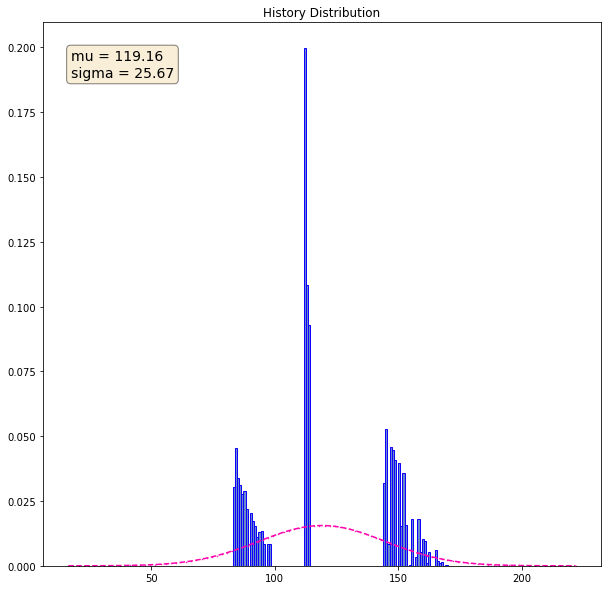

In [99]:
plot_history_histogram(history)

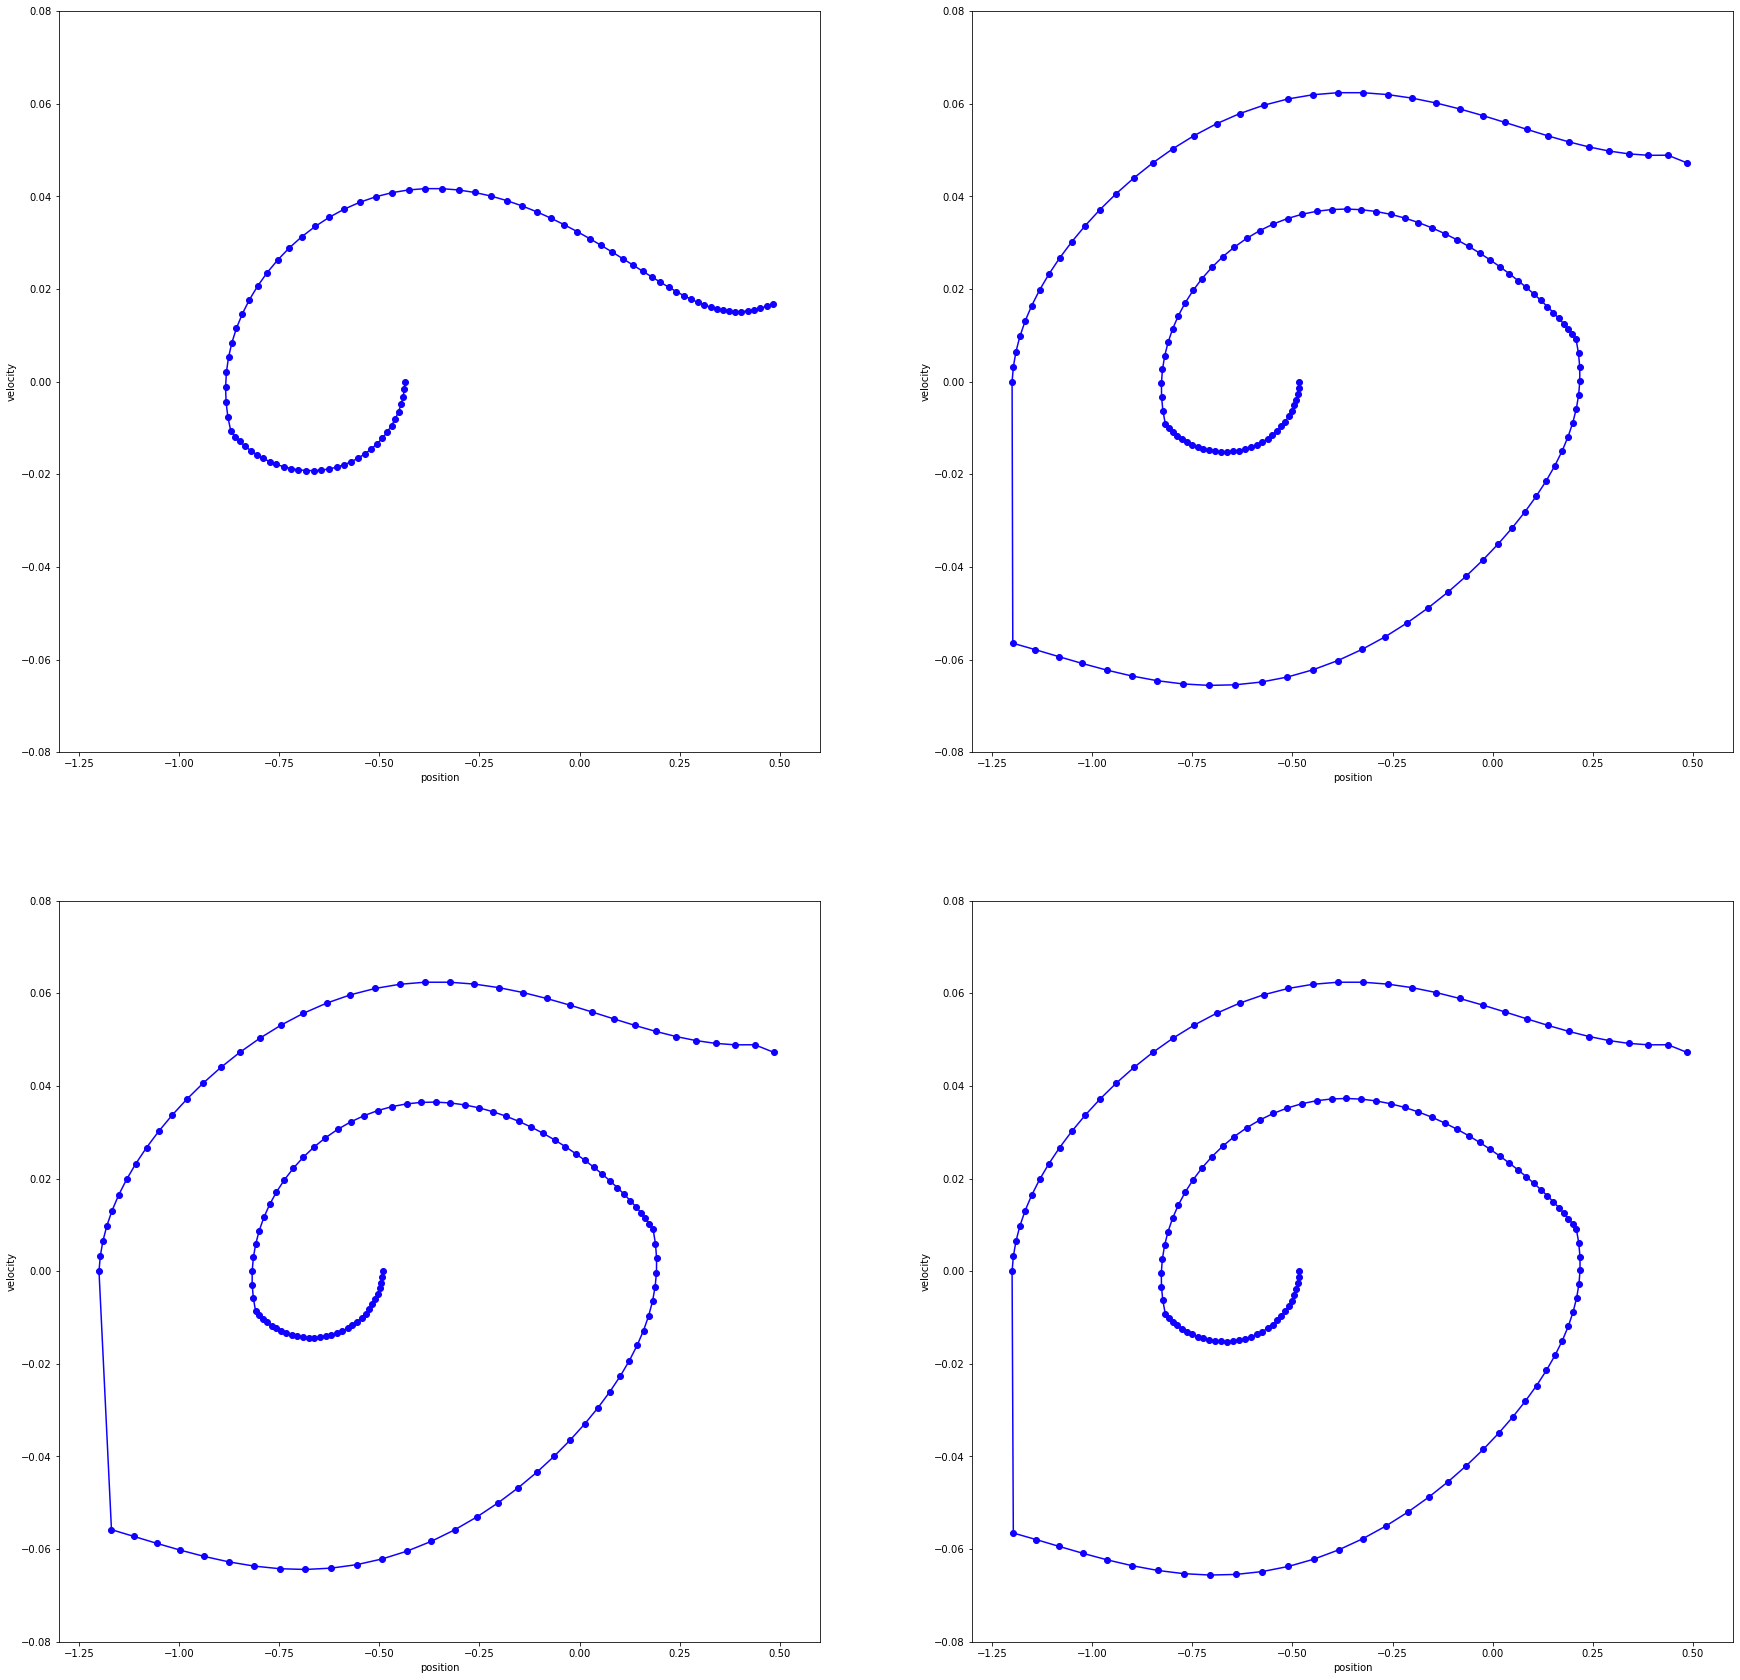

In [42]:
plot_phasespace_matrix(policy_evaluation, 2, 2)

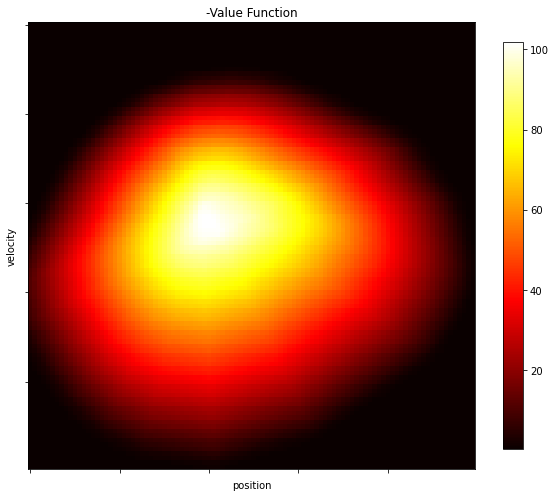

In [43]:
plot_valuefunction(value_function)

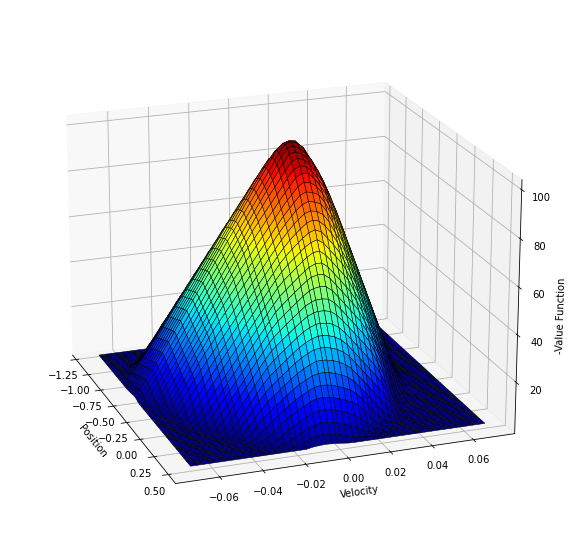

In [44]:
plot_valuefunction3d(value_function)

***
<a name='17'></a>

In [45]:
def OptimalPolicy():
    mu = np.array([[-0.35, 0.]])
    sigma = np.array([[0.5, 0.04]])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=[2]))
    model.add(tf.keras.layers.Lambda(function=lambda x: (x-mu)/sigma))
    model.add(tf.keras.layers.Dense(units=32, 
                                    activation='sigmoid', 
                                    kernel_initializer='he_uniform', 
                                    bias_initializer='zeros'))
    model.add(tf.keras.layers.Dense(units=32, 
                                    activation='sigmoid', 
                                    kernel_initializer='he_uniform', 
                                    bias_initializer='zeros'))
    model.add(tf.keras.layers.Dense(3, 
                                    activation='softmax', 
                                    kernel_initializer='he_uniform', 
                                    bias_initializer='zeros'))    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, 
                                         beta_1=0.9, 
                                         beta_2=0.999, 
                                         epsilon=1e-07)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    model.summary()
    return model

In [46]:
op = OptimalPolicy()

weights = []

for i in range(len(optimal_policy.weights)):
    weight = op.get_weights()[i]
    shape = weight.shape
    w = optimal_policy.weights[i].numpy()
    weights.append(w.reshape(shape))
    
op.set_weights(weights)

op.save('model.keras')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


2025-05-17 21:32:08.143674: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model__/assets
